deterministic action

In [1]:
import os
os.environ['OPENAI_REMOTE_VERBOSE'] = '0'

In [2]:
import gym
import universe

n_envs = 1

In [3]:
import math

import time
import random
import pickle

from collections import deque

%matplotlib notebook
import matplotlib as mpl
plt = mpl.pyplot
# mpl.pylab.rcParams['figure.figsize'] = (12, 9)

import numpy as np
import torch as tch
F = tch.nn.functional

In [4]:
# pytorch auxiliar functions
def np2var(input):
    output = tch.autograd.Variable(tch.from_numpy(input))
    if tch.cuda.is_available():
        output = output.cuda()
    return output

tanh2sigmoid = lambda x: (x + 1) / 2

def postprocess(tch_img):
    return (tch_img * 255).byte().data.cpu().numpy().squeeze()

def val2action(values):
    action_n = [[('KeyEvent', 'ArrowLeft', 0.5 < values[0]),
                 ('KeyEvent', 'ArrowRight', 0.5 < values[1]),
                 ('KeyEvent', 'space', 0.5 < values[2]),
                ] for _ in range(n_envs)]
    
    return action_n

# screen slicing00
top = 86
left = 20 + 100
height = 300
width = 500 - 200
gamescreen_slice = (slice(top,  top + height), slice(left, left + width))
game_center = (top + height // 2, left + width // 2) # y, x
game_center = game_center[::-1]

# average pooling for downscaling
s = downscale_size = 2
pool2d_downscale = tch.nn.AvgPool2d((s, s), stride=(s, s))
downscale_n = 1
downscale = downscale_size ** downscale_n
dummy_img = np.zeros((height // downscale, width // downscale, 1))

<IPython.core.display.Javascript object>


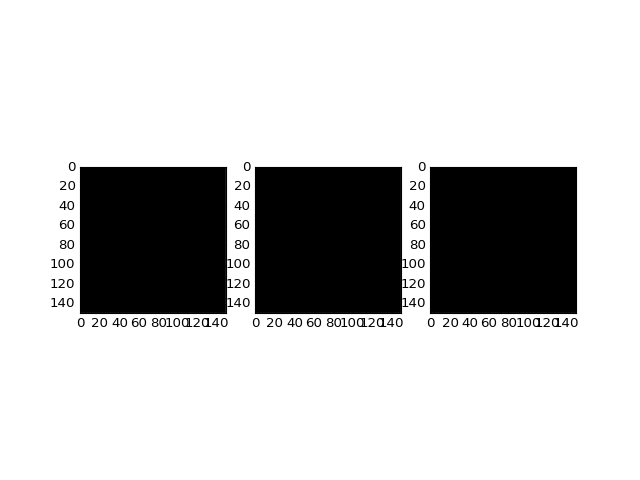

<IPython.core.display.Javascript object>


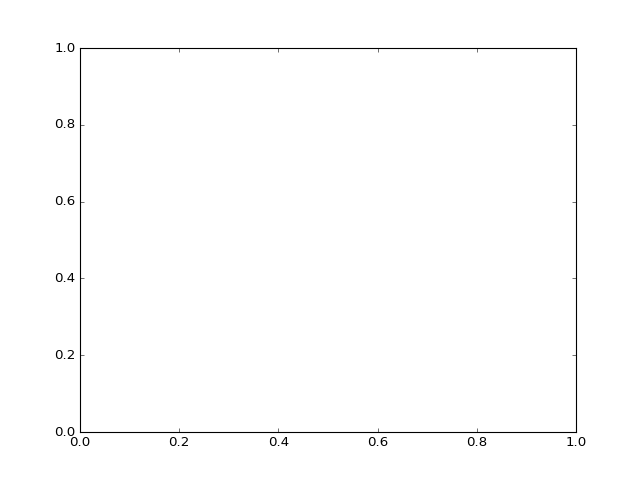

In [5]:
# visualization
fig, axes = mpl.pyplot.subplots(1, 3)

# initialization of visualization
imgs = [ax.imshow(dummy_img.squeeze(), interpolation='none', vmin=0, vmax=255, cmap='gray') for ax in axes]

fig_loss, ax_loss = plt.subplots()

In [6]:
env = gym.make('internet.SlitherIO-v0')
env.configure(remotes=1)  # automatically creates a local docker container

observation_n = env.reset()

# sys.stdout = nb_stdout

[2017-08-26 20:46:17,373] Making new env: internet.SlitherIO-v0
[2017-08-26 20:46:17,386] Writing logs to file: /tmp/universe-4382.log
[2017-08-26 20:46:17,409] Ports used: dict_keys([])
[2017-08-26 20:46:17,410] [0] Creating container: image=quay.io/openai/universe.flashgames:0.20.28. Run the same thing by hand as: docker run -p 5900:5900 -p 15900:15900 --ipc host --privileged --cap-add SYS_ADMIN quay.io/openai/universe.flashgames:0.20.28
[2017-08-26 20:46:17,775] Remote closed: address=localhost:5900
[2017-08-26 20:46:17,807] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 20:46:18,809] Remote closed: address=localhost:5900
[2017-08-26 20:46:18,809] Remote closed: address=localhost:15900
[2017-08-26 20:46:18,811] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 20:46:19,813] Using the golang VNC implementation
[2017-08-26 20:46:19,814] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_q

In [7]:
# observation_n = env.reset()

total_ae_loss = 0
total_pred_loss = 0

train_steps = 0

hidden = None

action_n = val2action(np.random.random(3))

episode = []
episode_nr = 123

time_0 = time.time()
time_episode = 0

while episode_nr < 500:

    time.sleep(max(0, 1/12 - (time.time() - time_0)))
    time_1 = time.time()
    time_d = time_1 - time_0
#     print(time_1 - time_0)
    time_0 = time_1
    
    # your agent here
    try:
        observation_n, reward_n, done_n, info = env.step(action_n)
    except:
        print('env CRASHED !!! ************************************')
        env = gym.make('internet.SlitherIO-v0')
        env.configure(remotes=1)  # automatically creates a local docker container
        observation_n = env.reset()
        
        episode = []
        time_episode = 0

    if observation_n[0] is None:
        time.sleep(1)
        time_0 = time.time()
    
    # choose new action
    if random.random() < 1.1:
        # randomly choose action
        action = np.random.random(3).astype(np.float32)
        action_n = val2action(action)

    if observation_n[0] is not None:
        print('.', end='')
        time_episode += time_d
        
        # preprocessing
        gamescreen = observation_n[0]['vision'][gamescreen_slice]
        gamescreen = gamescreen.transpose(2, 0, 1)
        gamescreen = np2var(gamescreen).float() / 255
        gamescreen = gamescreen.unsqueeze(0)
        # downscaling
        gamescreen = pool2d_downscale(gamescreen)
        gamescreen = gamescreen.max(dim=1, keepdim=True)[0]


        #displaying
        gamescreen = postprocess(gamescreen)
#             decoded_gamescreen = postprocess(decoded_gamescreen)
#             decoded_pred_gamescreen = postprocess(decoded_pred_gamescreen)
#         imgs[0].set_data(gamescreen)
#             imgs[1].set_data(decoded_gamescreen)
#             imgs[2].set_data(decoded_pred_gamescreen)
#         fig.canvas.draw()
    
        episode.append([action, gamescreen, reward_n])

    if np.any(done_n):
        if len(episode) > 0:
            print(time_episode / len(episode))
            time_episode = 0
        if len(episode) > 32:
            pickle.dump(episode, open('./game_dataset_action/'+str(episode_nr)+'.pickle', 'wb'))
            episode_nr += 1
        episode = []
        

[2017-08-26 20:46:21,058] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 20:46:22,145] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-26 20:46:23,231] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-26 20:46:24,317] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:46:25,402] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:46:26,488] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:46:27,574] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:46:28,660] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 20:46:29,747] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-26 20:46:30,832] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:46:31,918] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-26 20:46:33,004] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-26 20:46:34,090] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 20:46:35,177]

[2017-08-26 20:48:13,086] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:48:14,181] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 20:48:15,273] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 20:48:16,363] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:48:17,452] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:48:18,545] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 20:48:19,635] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 20:48:20,727] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 20:48:21,823] Throttle fell behind by 1.07s; lost 64.11 frames
[2017-08-26 20:48:22,910] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 20:48:24,002] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 20:48:25,093] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:48:26,183] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:48:27,279]

.0.08350682258605957
........................................................................................................................................................................................................................................................................................................

[2017-08-26 20:49:57,825] Throttle fell behind by 1.07s; lost 64.21 frames


0.11762176252700188


[2017-08-26 20:49:58,913] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:50:00,003] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:50:01,092] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:50:02,180] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 20:50:03,270] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:50:04,362] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 20:50:05,454] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 20:50:06,544] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:50:07,632] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:50:08,720] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 20:50:09,809] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:50:10,898] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:50:11,989] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 20:50:13,079]

......................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:50:51,412] Throttle fell behind by 1.07s; lost 64.33 frames


0.0836718011959433


[2017-08-26 20:50:52,506] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 20:50:53,597] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:50:54,691] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:50:55,780] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:50:56,868] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 20:50:57,957] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:50:59,044] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 20:51:00,133] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:51:01,221] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:51:02,310] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:51:03,400] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:51:04,491] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 20:51:05,582] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:51:06,671]

.0.0835123062133789
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:52:14,598] Throttle fell behind by 1.09s; lost 65.34 frames


0.08383496450341266


[2017-08-26 20:52:15,688] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:52:16,776] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:52:17,868] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:52:18,956] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 20:52:20,046] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:52:21,136] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:52:22,225] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:52:23,313] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:52:24,403] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:52:25,492] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:52:26,581] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:52:27,670] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:52:28,762] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 20:52:29,853]

...................................................................................................

[2017-08-26 20:52:44,774] Throttle fell behind by 1.07s; lost 64.29 frames


0.08427182592526831


[2017-08-26 20:52:45,865] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:52:46,959] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 20:52:48,053] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 20:52:49,143] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:52:50,233] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:52:51,322] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:52:52,413] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 20:52:53,508] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-26 20:52:54,598] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:52:55,689] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:52:56,779] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:52:57,868] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:52:58,956] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:53:00,048]

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:53:52,255] Throttle fell behind by 1.07s; lost 64.22 frames


0.08388382387251055


[2017-08-26 20:53:53,344] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:53:54,434] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:53:55,524] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 20:53:56,615] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:53:57,705] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:53:58,797] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-26 20:53:59,887] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:54:00,976] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:54:02,065] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:54:03,155] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:54:04,245] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:54:05,336] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:54:06,425] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:54:07,515]

.0.08907365798950195
................................................................................................................................................................................................................................................................................

[2017-08-26 20:54:52,372] Throttle fell behind by 1.07s; lost 64.34 frames


0.08429226279258728


[2017-08-26 20:54:53,462] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:54:54,552] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:54:55,640] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:54:56,730] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:54:57,829] Throttle fell behind by 1.08s; lost 64.51 frames
[2017-08-26 20:54:58,930] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:55:00,019] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:55:01,109] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:55:02,199] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 20:55:03,290] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 20:55:04,379] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:55:05,467] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 20:55:06,557] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:55:07,647]

.0.08411741256713867
..............................................................................................................................................

[2017-08-26 20:55:41,524] Throttle fell behind by 1.07s; lost 64.20 frames


0.08396982475065849


[2017-08-26 20:55:42,613] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:55:43,703] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:55:44,792] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:55:45,880] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 20:55:46,970] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 20:55:48,060] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:55:49,148] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:55:50,237] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:55:51,326] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:55:52,416] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:55:53,505] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:55:54,594] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:55:55,683] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:55:56,774]

.0.08351278305053711
...................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:57:01,549] Throttle fell behind by 1.07s; lost 64.22 frames


0.08385073702100297


[2017-08-26 20:57:02,639] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:57:03,729] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:57:04,818] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:57:05,909] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:57:07,000] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 20:57:08,092] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:57:09,181] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:57:10,271] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 20:57:11,367] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:57:12,456] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:57:13,551] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:57:14,640] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 20:57:15,729] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:57:16,817]

.........................................................................................................................................................................................................................................................................................

[2017-08-26 20:57:46,984] Throttle fell behind by 1.07s; lost 64.40 frames


0.08397491292172904


[2017-08-26 20:57:48,074] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:57:49,164] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:57:50,255] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 20:57:51,362] Throttle fell behind by 1.08s; lost 64.68 frames
[2017-08-26 20:57:52,459] Throttle fell behind by 1.08s; lost 64.59 frames
[2017-08-26 20:57:53,549] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:57:54,644] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-26 20:57:55,734] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:57:56,825] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 20:57:57,917] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 20:57:59,006] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:58:00,095] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 20:58:01,187] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 20:58:02,280]

.......................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:58:37,413] Throttle fell behind by 1.07s; lost 64.25 frames


0.08401979729305349


[2017-08-26 20:58:38,501] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:58:39,590] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:58:40,681] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 20:58:41,773] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 20:58:42,861] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 20:58:43,950] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:58:45,039] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:58:46,128] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:58:47,216] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:58:48,306] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:58:49,404] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:58:50,494] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 20:58:51,585] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 20:58:52,674]

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 20:59:39,056] Throttle fell behind by 1.07s; lost 64.22 frames


0.08400682878494263


[2017-08-26 20:59:40,144] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:59:41,234] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:59:42,326] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 20:59:43,417] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:59:44,519] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-26 20:59:45,611] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 20:59:46,702] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 20:59:47,793] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 20:59:48,884] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 20:59:49,972] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 20:59:51,062] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 20:59:52,152] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 20:59:53,242] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 20:59:54,331]

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:01:09,936] Throttle fell behind by 1.09s; lost 65.62 frames


0.0841641405405756


[2017-08-26 21:01:11,026] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:01:12,120] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:01:13,215] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:01:14,305] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:01:15,394] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:01:16,484] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:01:17,574] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:01:18,664] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:01:19,752] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:01:20,845] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:01:21,934] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:01:23,024] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:01:24,114] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:01:25,203]

................................................................................................................................................................................................................................................................

[2017-08-26 21:01:54,440] Throttle fell behind by 1.09s; lost 65.12 frames


0.08419076446443796


[2017-08-26 21:01:55,542] Throttle fell behind by 1.08s; lost 64.67 frames
[2017-08-26 21:01:56,632] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:01:57,728] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:01:58,820] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:01:59,919] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:02:01,016] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:02:02,107] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 21:02:03,214] Throttle fell behind by 1.08s; lost 64.77 frames
[2017-08-26 21:02:04,310] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:02:05,401] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:02:06,491] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:02:07,580] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:02:08,676] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:02:09,769]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:04:47,798] Throttle fell behind by 1.26s; lost 75.48 frames
[2017-08-26 21:04:48,887] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:04:49,981] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-26 21:04:51,072] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:04:52,173] Throttle fell behind by 1.08s; lost 64.74 frames
[2017-08-26 21:04:53,263] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:04:54,354] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:04:55,452] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:04:56,547] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:04:57,637] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:04:58,726] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:04:59,815] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:05:00,904] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:05:01,999]

.0.08583426475524902
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:06:46,031] Throttle fell behind by 1.09s; lost 65.34 frames


0.08413485913980202


[2017-08-26 21:06:47,121] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:06:48,219] Throttle fell behind by 1.08s; lost 64.66 frames
[2017-08-26 21:06:49,308] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:06:50,398] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:06:51,488] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:06:52,585] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:06:53,689] Throttle fell behind by 1.08s; lost 64.84 frames
[2017-08-26 21:06:54,785] Throttle fell behind by 1.08s; lost 64.63 frames
[2017-08-26 21:06:55,875] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:06:56,969] Throttle fell behind by 1.07s; lost 64.49 frames
[2017-08-26 21:06:58,073] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-26 21:06:59,166] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:07:00,262] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:07:01,353]

...........................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:07:38,036] Throttle fell behind by 1.07s; lost 64.26 frames


0.08431782247076582


[2017-08-26 21:07:39,127] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:07:40,218] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:07:41,310] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:07:42,410] Throttle fell behind by 1.08s; lost 64.56 frames
[2017-08-26 21:07:43,505] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:07:44,595] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:07:45,685] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:07:46,774] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:07:47,864] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:07:48,953] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:07:50,042] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:07:51,131] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:07:52,222] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:07:53,311]

.0.08346843719482422
..........................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:08:42,899] Throttle fell behind by 1.07s; lost 64.21 frames


0.08443318278926193


[2017-08-26 21:08:43,988] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:08:45,080] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-26 21:08:46,170] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:08:47,262] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-26 21:08:48,359] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 21:08:49,448] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:08:50,538] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:08:51,628] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:08:52,718] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:08:53,808] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:08:54,900] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:08:55,989] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:08:57,079] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:08:58,168]

.0.08347630500793457
......................................................................................................................................................................................................................................

[2017-08-26 21:09:41,642] Throttle fell behind by 1.07s; lost 64.21 frames


0.08419812762218973


[2017-08-26 21:09:42,732] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:09:43,824] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 21:09:44,914] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:09:46,004] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:09:47,100] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:09:48,193] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:09:49,290] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:09:50,382] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:09:51,478] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 21:09:52,587] Throttle fell behind by 1.09s; lost 65.23 frames
[2017-08-26 21:09:53,682] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:09:54,772] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:09:55,862] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:09:56,952]

.0.08711385726928711
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:12:29,433] Throttle fell behind by 1.19s; lost 71.49 frames
[2017-08-26 21:12:30,522] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:12:31,613] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 21:12:32,708] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:12:33,799] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:12:34,888] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:12:35,977] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:12:37,069] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 21:12:38,159] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:12:39,249] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:12:40,342] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-26 21:12:41,432] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:12:42,521] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:12:43,614]

env CRASHED !!! ************************************


[2017-08-26 21:13:29,457] Remote closed: address=localhost:15901
[2017-08-26 21:13:29,468] Remote closed: address=localhost:5901
[2017-08-26 21:13:29,477] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:13:30,484] Remote closed: address=localhost:5901
[2017-08-26 21:13:30,490] Remote closed: address=localhost:15901
[2017-08-26 21:13:30,493] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:13:31,501] Using the golang VNC implementation
[2017-08-26 21:13:31,507] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:13:31,533] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 21:13:31,541] Kill

.........................................................................

[2017-08-26 21:14:35,452] Throttle fell behind by 1.07s; lost 64.22 frames


0.08449247765214477


[2017-08-26 21:14:36,540] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:14:37,630] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:14:38,723] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 21:14:39,812] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:14:40,901] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:14:41,998] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:14:43,088] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:14:44,177] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:14:45,267] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:14:46,357] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:14:47,448] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:14:48,543] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-26 21:14:49,638] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:14:50,730]

...............................................................................................................................................................................................................................

[2017-08-26 21:15:14,936] Throttle fell behind by 1.07s; lost 64.22 frames


0.08410506077411463


[2017-08-26 21:15:16,025] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:15:17,117] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-26 21:15:18,211] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:15:19,303] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-26 21:15:20,392] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:15:21,485] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:15:22,574] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:15:23,663] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:15:24,752] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:15:25,840] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:15:26,932] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:15:28,022] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:15:29,115] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:15:30,205]

.0.08347105979919434
.....................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:16:41,596] Throttle fell behind by 1.07s; lost 64.22 frames


0.08391330870766538


[2017-08-26 21:16:42,684] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:16:43,773] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:16:44,865] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 21:16:45,957] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 21:16:47,050] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-26 21:16:48,140] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:16:49,229] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:16:50,318] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:16:51,407] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:16:52,497] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:16:53,587] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:16:54,676] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:16:55,766] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:16:56,855]

env CRASHED !!! ************************************


[2017-08-26 21:17:41,877] Remote closed: address=localhost:15900
[2017-08-26 21:17:41,881] Remote closed: address=localhost:5900
[2017-08-26 21:17:41,886] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:17:42,895] Remote closed: address=localhost:5900
[2017-08-26 21:17:42,901] Remote closed: address=localhost:15900
[2017-08-26 21:17:42,905] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:17:43,911] Using the golang VNC implementation
[2017-08-26 21:17:43,918] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:17:43,955] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 21:17:43,965] Kill

env CRASHED !!! ************************************


[2017-08-26 21:19:10,103] Remote closed: address=localhost:5901
[2017-08-26 21:19:10,107] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:19:11,111] Remote closed: address=localhost:15901
[2017-08-26 21:19:11,123] Remote closed: address=localhost:5901
[2017-08-26 21:19:11,127] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:19:12,142] Using the golang VNC implementation
[2017-08-26 21:19:12,145] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:19:12,235] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 21:19:12,243] Killing and removing container: id=5b56678f6456cc0cb0be0474aee9e114db

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:20:55,450] Throttle fell behind by 1.07s; lost 64.27 frames


0.08431272400963691


[2017-08-26 21:20:56,541] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 21:20:57,632] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:20:58,722] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:20:59,812] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:21:00,901] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:21:01,989] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:21:03,080] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:21:04,173] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 21:21:05,262] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:21:06,352] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:21:07,444] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-26 21:21:08,534] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:21:09,624] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:21:10,718]

....................................................................................................................................................................................................

[2017-08-26 21:21:30,484] Throttle fell behind by 1.07s; lost 64.25 frames


0.08408267279060519


[2017-08-26 21:21:31,572] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:21:32,664] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:21:33,754] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:21:34,843] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:21:35,933] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:21:37,023] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:21:38,112] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:21:39,201] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:21:40,291] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:21:41,380] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:21:42,471] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:21:43,561] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:21:44,653] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:21:45,743]

............................................................................................................................

[2017-08-26 21:22:00,597] Throttle fell behind by 1.07s; lost 64.23 frames


0.08453846362329298


[2017-08-26 21:22:01,692] Throttle fell behind by 1.08s; lost 64.55 frames
[2017-08-26 21:22:02,788] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-26 21:22:03,881] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:22:04,970] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:06,060] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:22:07,149] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:08,239] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:09,334] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:10,425] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:22:11,521] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:22:12,610] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:22:13,702] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:22:14,792] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:22:15,885]

.................................................................................................................................................................................................................................

[2017-08-26 21:22:40,272] Throttle fell behind by 1.07s; lost 64.23 frames


0.08412177827623156


[2017-08-26 21:22:41,363] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 21:22:42,455] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 21:22:43,545] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:44,637] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:45,731] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:22:46,823] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:22:47,913] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:22:49,007] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:22:50,101] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:51,194] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:22:52,284] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:22:53,374] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:22:54,468] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-26 21:22:55,564]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:24:34,926] Throttle fell behind by 1.15s; lost 69.07 frames


0.0841207553452975


[2017-08-26 21:24:36,016] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:37,105] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:24:38,205] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:24:39,294] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:40,385] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 21:24:41,475] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:24:42,564] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:24:43,654] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:44,745] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:45,835] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:46,925] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:24:48,019] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 21:24:49,109] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:24:50,204]

...................................................................................................................................................................................................................................................

[2017-08-26 21:25:17,285] Throttle fell behind by 1.07s; lost 64.17 frames


0.0844490743958901


[2017-08-26 21:25:18,373] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:25:19,464] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 21:25:20,559] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-26 21:25:21,649] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:25:22,743] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-26 21:25:23,834] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:25:24,927] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:25:26,023] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:25:27,113] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:25:28,206] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-26 21:25:29,304] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:25:30,393] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:25:31,487] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:25:32,585]

.0.08349442481994629
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:27:20,993] Throttle fell behind by 1.15s; lost 68.91 frames


0.0841468504429804


[2017-08-26 21:27:22,082] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:27:23,172] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:27:24,262] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:27:25,353] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:27:26,461] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:27:27,550] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:27:28,644] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:27:29,733] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:27:30,827] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:27:31,918] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:27:33,007] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:27:34,096] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:27:35,192] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:27:36,285]

env CRASHED !!! ************************************


[2017-08-26 21:28:21,148] Remote closed: address=localhost:15900
[2017-08-26 21:28:21,160] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:28:22,171] Remote closed: address=localhost:5900
[2017-08-26 21:28:22,180] Remote closed: address=localhost:15900
[2017-08-26 21:28:22,186] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:28:23,191] Using the golang VNC implementation
[2017-08-26 21:28:23,194] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:28:23,222] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 21:28:23,227] Killing and removing container: id=3f61bb3119223d5bfe5e7d1e8f3dab25e

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:29:58,745] Throttle fell behind by 1.07s; lost 64.23 frames


0.08414925267343563


[2017-08-26 21:29:59,838] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:30:00,930] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 21:30:02,020] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:30:03,113] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-26 21:30:04,203] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:30:05,293] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:30:06,383] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:30:07,472] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:30:08,563] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:30:09,652] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:30:10,742] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:30:11,833] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 21:30:12,925] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:30:14,014]

.0.0839834213256836
................................................

[2017-08-26 21:30:39,945] Throttle fell behind by 1.07s; lost 64.18 frames


0.0839044451713562


[2017-08-26 21:30:41,032] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 21:30:42,123] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 21:30:43,215] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 21:30:44,305] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:30:45,393] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:30:46,483] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:30:47,571] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:30:48,659] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:30:49,749] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:30:50,837] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 21:30:51,926] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:30:53,015] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:30:54,104] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:30:55,194]

.0.08420944213867188
......................................................................................................

[2017-08-26 21:31:24,546] Throttle fell behind by 1.07s; lost 64.23 frames


0.08368891126969281


[2017-08-26 21:31:25,635] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:31:26,727] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:31:27,816] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:31:28,905] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:31:29,994] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:31:31,082] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:31:32,171] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:31:33,260] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:31:34,349] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:31:35,437] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:31:36,528] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:31:37,618] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:31:38,708] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:31:39,797]

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:32:30,293] Throttle fell behind by 1.07s; lost 64.22 frames


0.08369776331786569


[2017-08-26 21:32:31,382] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:32:32,471] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:32:33,566] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:32:34,655] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:32:35,745] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:32:36,834] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:32:37,923] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:32:39,012] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:32:40,100] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:32:41,188] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:32:42,276] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:32:43,366] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:32:44,456] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:32:45,553]

.0.08346986770629883
.............................................................................................................

[2017-08-26 21:33:29,632] Throttle fell behind by 1.07s; lost 64.20 frames


0.08377433041913794


[2017-08-26 21:33:30,720] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:33:31,808] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:33:32,897] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:33:33,986] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:33:35,076] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:33:36,164] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:33:37,254] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:33:38,343] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:33:39,432] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:33:40,524] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:33:41,613] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:33:42,711] Throttle fell behind by 1.08s; lost 64.75 frames
[2017-08-26 21:33:43,801] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:33:44,890]

.............................................................................................................................................................................................

[2017-08-26 21:34:02,911] Throttle fell behind by 1.07s; lost 64.25 frames


0.08381118345512915


[2017-08-26 21:34:04,000] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:34:05,093] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-26 21:34:06,192] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:34:07,284] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:34:08,374] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:34:09,464] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:34:10,553] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:34:11,651] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:34:12,740] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:34:13,828] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:34:14,918] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:34:16,012] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:34:17,100] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:34:18,194]

env CRASHED !!! ************************************


[2017-08-26 21:35:04,024] Remote closed: address=localhost:5901
[2017-08-26 21:35:04,027] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:35:05,031] Remote closed: address=localhost:15901
[2017-08-26 21:35:05,034] Remote closed: address=localhost:5901
[2017-08-26 21:35:05,037] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:35:06,046] Remote closed: address=localhost:15901
[2017-08-26 21:35:06,051] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:35:07,059] Using the golang VNC implementation
[2017-08-26 21:35:07,066] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:35:07,098] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser V

..............................................................................................................................................................

[2017-08-26 21:36:19,123] Throttle fell behind by 1.07s; lost 64.20 frames


0.08406628234476983


[2017-08-26 21:36:20,212] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:36:21,301] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:36:22,390] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:36:23,482] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:36:24,571] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:36:25,660] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:36:26,748] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:36:27,839] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:36:28,930] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:36:30,018] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:36:31,107] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:36:32,195] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:36:33,284] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:36:34,372]

...................................................................................................................................................................................................................................................................................

[2017-08-26 21:37:00,685] Throttle fell behind by 1.07s; lost 64.21 frames


0.08378289396112615


[2017-08-26 21:37:01,774] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:02,864] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:03,953] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:37:05,043] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:37:06,132] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:07,220] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:37:08,309] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:09,397] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:37:10,487] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:37:11,576] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:37:12,664] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:37:13,754] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:14,845] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 21:37:15,933]

.0.0839998722076416
...........................................................................................

[2017-08-26 21:37:43,258] Throttle fell behind by 1.07s; lost 64.21 frames


0.08372453280857631


[2017-08-26 21:37:44,347] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:37:45,436] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:46,524] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:37:47,612] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:37:48,701] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:37:49,790] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:37:50,879] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:37:51,968] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:37:53,057] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:37:54,146] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:37:55,235] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:37:56,334] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-26 21:37:57,426] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 21:37:58,516]

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:38:50,786] Throttle fell behind by 1.07s; lost 64.25 frames


0.08373840806309353


[2017-08-26 21:38:51,875] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:38:52,964] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:38:54,054] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:38:55,143] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:38:56,232] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:38:57,321] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:38:58,410] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:38:59,503] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:39:00,592] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:39:01,684] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-26 21:39:02,774] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:39:03,862] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:39:04,957] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-26 21:39:06,053]

......................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:39:36,364] Throttle fell behind by 1.07s; lost 64.26 frames


0.08367094224499118


[2017-08-26 21:39:37,452] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:39:38,542] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:39:39,630] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:39:40,720] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:39:41,809] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:39:42,898] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:39:43,988] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:39:45,077] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:39:46,165] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:39:47,255] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:39:48,344] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:39:49,434] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:39:50,523] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:39:51,615]

...................................................................................

[2017-08-26 21:40:00,775] Throttle fell behind by 1.07s; lost 64.20 frames


0.08412866994559047


[2017-08-26 21:40:01,863] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:40:02,952] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:40:04,042] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:40:05,133] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:40:06,222] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:40:07,311] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:40:08,406] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 21:40:09,495] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:40:10,585] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:40:11,672] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-26 21:40:12,760] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:40:13,849] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:40:14,938] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:40:16,027]

.0.08350205421447754
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:41:15,900] Throttle fell behind by 1.07s; lost 64.24 frames


0.08369645917633242


[2017-08-26 21:41:16,988] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:41:18,077] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:41:19,166] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:41:20,256] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:41:21,345] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:41:22,435] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:41:23,524] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:41:24,613] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:41:25,704] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:41:26,794] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:41:27,884] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:41:28,972] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:41:30,061] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:41:31,154]

.0.08343839645385742
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:42:26,414] Throttle fell behind by 1.07s; lost 64.24 frames


0.08380254946256939


[2017-08-26 21:42:27,503] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:42:28,593] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 21:42:29,682] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:42:30,772] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:42:31,860] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:42:32,949] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:42:34,039] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:42:35,128] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:42:36,216] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:42:37,304] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:42:38,394] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:42:39,484] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:42:40,579] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-26 21:42:41,669]

.............................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:43:15,239] Throttle fell behind by 1.07s; lost 64.21 frames


0.08368652597880978


[2017-08-26 21:43:16,328] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:43:17,419] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 21:43:18,514] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-26 21:43:19,604] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:43:20,693] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:43:21,783] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:43:22,872] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:43:23,961] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:43:25,050] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:43:26,143] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-26 21:43:27,232] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:43:28,320] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:43:29,410] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:43:30,498]

env CRASHED !!! ************************************


[2017-08-26 21:44:15,071] Remote closed: address=localhost:5900
[2017-08-26 21:44:15,074] Remote closed: address=localhost:15900
[2017-08-26 21:44:15,079] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:44:16,086] Remote closed: address=localhost:5900
[2017-08-26 21:44:16,090] Remote closed: address=localhost:15900
[2017-08-26 21:44:16,094] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:44:17,099] Using the golang VNC implementation
[2017-08-26 21:44:17,107] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:44:17,135] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 21:44:17,142] Kill

env CRASHED !!! ************************************


[2017-08-26 21:45:24,756] Remote closed: address=localhost:5900
[2017-08-26 21:45:24,759] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:45:25,763] Remote closed: address=localhost:15900
[2017-08-26 21:45:25,775] Remote closed: address=localhost:5900
[2017-08-26 21:45:25,779] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:45:26,784] Using the golang VNC implementation
[2017-08-26 21:45:26,789] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:45:26,797] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 21:45:26,802] Killing and removing container: id=33a2025489ce0d32545c0c6fe7c57e78c8

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:47:00,434] Throttle fell behind by 1.07s; lost 64.30 frames


0.08380393160889481


[2017-08-26 21:47:01,523] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:47:02,615] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-26 21:47:03,705] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:47:04,797] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 21:47:05,886] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:47:06,975] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:47:08,064] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:47:09,153] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:47:10,243] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:47:11,332] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:47:12,421] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:47:13,510] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:47:14,600] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:47:15,691]

env CRASHED !!! ************************************


[2017-08-26 21:48:01,635] Remote closed: address=localhost:5901
[2017-08-26 21:48:01,638] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:48:02,645] Remote closed: address=localhost:5901
[2017-08-26 21:48:02,649] Remote closed: address=localhost:15901
[2017-08-26 21:48:02,653] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:48:03,658] Using the golang VNC implementation
[2017-08-26 21:48:03,665] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:48:03,705] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 21:48:03,710] Killing and removing container: id=3926b54403392a7c242334c44c1a0b0be3

.....................................................................................................................

[2017-08-26 21:49:12,245] Throttle fell behind by 1.07s; lost 64.23 frames


0.08409840021377955


[2017-08-26 21:49:13,334] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:14,423] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:49:15,512] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:16,608] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-26 21:49:17,698] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:49:18,788] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:49:19,876] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:49:20,965] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:22,054] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:23,143] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:24,233] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:49:25,323] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:49:26,412] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:49:27,505]

.0.08345985412597656
................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:50:35,998] Throttle fell behind by 1.07s; lost 64.22 frames


0.08382015705108642


[2017-08-26 21:50:37,087] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:50:38,176] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:50:39,264] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:50:40,357] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:50:41,451] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:50:42,541] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:50:43,631] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:50:44,720] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:50:45,808] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:50:46,899] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 21:50:47,996] Throttle fell behind by 1.08s; lost 64.66 frames
[2017-08-26 21:50:49,086] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:50:50,176] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:50:51,269]

.0.08350586891174316
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:52:04,979] Throttle fell behind by 1.07s; lost 64.23 frames


0.08374273704540404


[2017-08-26 21:52:06,067] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:07,156] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:52:08,246] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:52:09,335] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:52:10,424] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:52:11,513] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:12,602] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:52:13,690] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:52:14,779] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:52:15,869] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:52:16,958] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:52:18,047] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:52:19,137] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:52:20,228]

.......................................................................

[2017-08-26 21:52:28,363] Throttle fell behind by 1.07s; lost 64.24 frames


0.083736218197245


[2017-08-26 21:52:29,454] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 21:52:30,543] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:31,638] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 21:52:32,728] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:52:33,818] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:34,907] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:35,998] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 21:52:37,087] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:38,180] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 21:52:39,268] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:52:40,371] Throttle fell behind by 1.08s; lost 65.02 frames
[2017-08-26 21:52:41,461] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:52:42,550] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:52:43,644]

env CRASHED !!! ************************************


[2017-08-26 21:53:29,452] Remote closed: address=localhost:5900
[2017-08-26 21:53:29,457] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:53:30,467] Remote closed: address=localhost:5900
[2017-08-26 21:53:30,479] Remote closed: address=localhost:15900
[2017-08-26 21:53:30,482] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 21:53:31,496] Using the golang VNC implementation
[2017-08-26 21:53:31,501] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 21:53:31,563] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 21:53:31,586] Killing and removing container: id=751121098eaefa27ff1546c73e92843656

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:55:07,464] Throttle fell behind by 1.07s; lost 64.26 frames


0.08373609975653688


[2017-08-26 21:55:08,552] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:55:09,641] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:55:10,729] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 21:55:11,818] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:55:12,911] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:55:14,000] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:55:15,088] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:55:16,176] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 21:55:17,266] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:55:18,356] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:55:19,445] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:55:20,534] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:55:21,623] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 21:55:22,713]

.0.08347892761230469
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:57:08,988] Throttle fell behind by 1.13s; lost 67.67 frames


0.0837516186284084


[2017-08-26 21:57:10,077] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:57:11,170] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:57:12,259] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:57:13,348] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:57:14,436] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:57:15,526] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:57:16,615] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:57:17,705] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:57:18,794] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:57:19,883] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:57:20,973] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:57:22,063] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:57:23,152] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:57:24,244]

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 21:58:21,233] Throttle fell behind by 1.07s; lost 64.25 frames


0.08367255246527841


[2017-08-26 21:58:22,322] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:23,412] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 21:58:24,502] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:25,591] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:58:26,679] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:58:27,767] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 21:58:28,857] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:58:29,946] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:58:31,035] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:32,123] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 21:58:33,212] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:58:34,300] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:35,389] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:36,492]

...........................................

[2017-08-26 21:58:46,642] Throttle fell behind by 1.07s; lost 64.22 frames


0.08373137961986453


[2017-08-26 21:58:47,731] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:58:48,820] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:58:49,910] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:51,002] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-26 21:58:52,094] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:58:53,183] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:58:54,273] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 21:58:55,363] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:58:56,452] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:58:57,541] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 21:58:58,629] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 21:58:59,718] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:59:00,807] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:59:01,897]

.0.08345508575439453
...............................................................................................................................................................................................

[2017-08-26 21:59:55,047] Throttle fell behind by 1.07s; lost 64.26 frames


0.08384752523212533


[2017-08-26 21:59:56,136] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 21:59:57,225] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:59:58,314] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 21:59:59,405] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:00:00,497] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:00:01,586] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:00:02,675] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:00:03,764] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:00:04,853] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:00:05,942] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:00:07,031] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:00:08,121] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:00:09,210] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:00:10,300]

.0.08703446388244629
................................................................................................................

[2017-08-26 22:00:54,632] Throttle fell behind by 1.07s; lost 64.22 frames


0.08371839565890175


[2017-08-26 22:00:55,720] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:00:56,809] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:00:57,903] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-26 22:00:58,993] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:00,082] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:01,171] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:02,260] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:03,349] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:01:04,438] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:05,527] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:01:06,617] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:01:07,706] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:01:08,796] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:01:09,894]

...................................................................................................................................

[2017-08-26 22:01:23,065] Throttle fell behind by 1.07s; lost 64.23 frames


0.08391362656163805


[2017-08-26 22:01:24,155] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:25,246] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:01:26,336] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:27,427] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:01:28,519] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:01:29,612] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:30,701] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:31,790] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:01:32,878] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:33,967] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:35,056] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:36,145] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:01:37,234] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:01:38,326]

.0.08347415924072266
..................................................................................................................................................

[2017-08-26 22:02:08,099] Throttle fell behind by 1.07s; lost 64.21 frames


0.08395373331357354


[2017-08-26 22:02:09,188] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:02:10,277] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:02:11,366] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:02:12,456] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:02:13,544] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:02:14,634] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:02:15,723] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:02:16,812] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:02:17,902] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:02:18,991] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:02:20,078] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:02:21,168] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:02:22,262] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 22:02:23,353]

......................................................................................................................

[2017-08-26 22:02:35,428] Throttle fell behind by 1.07s; lost 64.23 frames


0.08384624376135358


[2017-08-26 22:02:36,516] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:02:37,607] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:02:38,698] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:02:39,791] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-26 22:02:40,880] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:02:41,969] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:02:43,059] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:02:44,148] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:02:45,240] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:02:46,330] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:02:47,420] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:02:48,510] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:02:49,599] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:02:50,689]

.0.08347511291503906
.............................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:03:53,552] Throttle fell behind by 1.07s; lost 64.23 frames


0.08382491163305335


[2017-08-26 22:03:54,641] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:03:55,732] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 22:03:56,826] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-26 22:03:57,918] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:03:59,011] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:04:00,100] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:04:01,190] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:04:02,278] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:04:03,368] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 22:04:04,456] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:04:05,545] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:04:06,633] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:04:07,723] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:04:08,812]

.0.08347773551940918
..............................................................................................................................................................

[2017-08-26 22:04:42,859] Throttle fell behind by 1.07s; lost 64.23 frames


0.08377394193335425


[2017-08-26 22:04:43,948] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:04:45,037] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:04:46,135] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 22:04:47,228] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:04:48,316] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:04:49,405] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 22:04:50,493] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:04:51,583] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:04:52,673] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:04:53,763] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:04:54,852] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:04:55,942] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:04:57,032] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:04:58,121]

.0.08349204063415527
........................................................................................................................................................................................................................................

[2017-08-26 22:05:58,198] Throttle fell behind by 1.07s; lost 64.24 frames


0.0842289462171752


[2017-08-26 22:05:59,298] Throttle fell behind by 1.08s; lost 64.85 frames
[2017-08-26 22:06:00,390] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:06:01,495] Throttle fell behind by 1.08s; lost 64.60 frames
[2017-08-26 22:06:02,588] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:06:03,686] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:06:04,779] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:06:05,873] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:06:06,966] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:06:08,056] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:06:09,148] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:06:10,238] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:06:11,344] Throttle fell behind by 1.08s; lost 64.83 frames
[2017-08-26 22:06:12,442] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:06:13,539]

env CRASHED !!! ************************************


[2017-08-26 22:06:58,575] Remote closed: address=localhost:5901
[2017-08-26 22:06:58,584] Remote closed: address=localhost:15901
[2017-08-26 22:06:58,588] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:06:59,597] Remote closed: address=localhost:15901
[2017-08-26 22:06:59,639] Remote closed: address=localhost:5901
[2017-08-26 22:06:59,651] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:07:00,671] Using the golang VNC implementation
[2017-08-26 22:07:00,695] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:07:00,773] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 22:07:00,778] Kill

....................................................................................................

[2017-08-26 22:08:05,962] Throttle fell behind by 1.07s; lost 64.19 frames


0.08435690879821778


[2017-08-26 22:08:07,050] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:08:08,141] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 22:08:09,233] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:08:10,322] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:08:11,411] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:08:12,507] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:08:13,597] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:08:14,687] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:08:15,785] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-26 22:08:16,875] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:17,964] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:08:19,054] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:20,146] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:08:21,238]

.......................................................................................................................................................................................

[2017-08-26 22:08:41,005] Throttle fell behind by 1.07s; lost 64.24 frames


0.0840336455673468


[2017-08-26 22:08:42,095] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:43,185] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:08:44,285] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 22:08:45,382] Throttle fell behind by 1.08s; lost 64.64 frames
[2017-08-26 22:08:46,485] Throttle fell behind by 1.08s; lost 64.82 frames
[2017-08-26 22:08:47,576] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:48,666] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:49,756] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:08:50,844] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:08:51,938] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:53,028] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:08:54,118] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:08:55,216] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:08:56,307]

...................................................................................................................................

[2017-08-26 22:09:11,726] Throttle fell behind by 1.07s; lost 64.22 frames


0.08424159952702413


[2017-08-26 22:09:12,816] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:09:13,904] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:14,994] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:09:16,088] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:17,177] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:18,267] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:19,362] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-26 22:09:20,451] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:09:21,540] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:22,629] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:09:23,719] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:09:24,808] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:09:25,901] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:09:26,994]

............................................................................................................................................................................

[2017-08-26 22:09:45,774] Throttle fell behind by 1.07s; lost 64.22 frames


0.08383242474045864


[2017-08-26 22:09:46,863] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:47,953] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:09:49,042] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:50,131] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:51,219] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:52,309] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:09:53,398] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:54,487] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:09:55,576] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:09:56,665] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:09:57,754] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:09:58,849] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 22:09:59,940] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:10:01,034]

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:11:09,527] Throttle fell behind by 1.11s; lost 66.42 frames


0.08378971358497836


[2017-08-26 22:11:10,616] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:11:11,705] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:11:12,798] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:11:13,886] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:11:14,974] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:11:16,064] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:11:17,152] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:11:18,241] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:11:19,330] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:11:20,419] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:11:21,508] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:11:22,598] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:11:23,687] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:11:24,778]

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:12:45,085] Throttle fell behind by 1.11s; lost 66.57 frames


0.08369145924358935


[2017-08-26 22:12:46,174] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:12:47,264] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:12:48,353] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:12:49,445] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:12:50,539] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-26 22:12:51,628] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:12:52,716] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:12:53,805] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:12:54,894] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:12:55,983] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:12:57,072] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:12:58,161] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:12:59,250] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:13:00,339]

.0.08350300788879395
.............................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:13:54,886] Throttle fell behind by 1.07s; lost 64.20 frames


0.08377474560326352


[2017-08-26 22:13:55,975] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:13:57,064] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:13:58,158] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:13:59,247] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:14:00,336] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:14:01,425] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:14:02,513] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:14:03,603] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:14:04,693] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:14:05,782] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:14:06,871] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:14:07,960] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:14:09,050] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:14:10,145]

...........................................................

[2017-08-26 22:14:19,467] Throttle fell behind by 1.07s; lost 64.22 frames


0.08400632971424167


[2017-08-26 22:14:20,556] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:14:21,645] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:14:22,734] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:14:23,826] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:14:24,914] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:14:26,004] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:14:27,093] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:14:28,182] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:14:29,271] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:14:30,362] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 22:14:31,453] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:14:32,543] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:14:33,632] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:14:34,721]

.0.08347773551940918
..............................................................................................................................................................................................................

[2017-08-26 22:15:10,584] Throttle fell behind by 1.07s; lost 64.22 frames


0.08376548243957815


[2017-08-26 22:15:11,672] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:15:12,770] Throttle fell behind by 1.08s; lost 64.72 frames
[2017-08-26 22:15:13,859] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:15:14,949] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:15:16,040] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 22:15:17,128] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:15:18,220] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:15:19,309] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:15:20,398] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:15:21,487] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:15:22,576] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:15:23,664] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:15:24,753] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:15:25,844]

.0.08347845077514648
................................

[2017-08-26 22:15:51,518] Throttle fell behind by 1.07s; lost 64.22 frames


0.08412464708089828


[2017-08-26 22:15:52,607] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:15:53,696] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:15:54,784] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:15:55,873] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:15:56,962] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:15:58,051] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:15:59,139] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:16:00,228] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:16:01,316] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:16:02,405] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:16:03,494] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:16:04,583] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:16:05,677] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-26 22:16:06,767]

.........................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:16:44,277] Throttle fell behind by 1.07s; lost 64.22 frames


0.08369395318998976


[2017-08-26 22:16:45,366] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:16:46,458] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-26 22:16:47,549] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 22:16:48,640] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:16:49,728] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:16:50,818] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:16:51,907] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:16:52,996] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:16:54,084] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:16:55,172] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:16:56,262] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:16:57,351] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:16:58,449] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-26 22:16:59,539]

env CRASHED !!! ************************************


[2017-08-26 22:18:05,767] Remote closed: address=localhost:5900
[2017-08-26 22:18:05,770] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:18:06,775] Remote closed: address=localhost:15900
[2017-08-26 22:18:06,782] Remote closed: address=localhost:5900
[2017-08-26 22:18:06,786] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:18:07,791] Using the golang VNC implementation
[2017-08-26 22:18:07,795] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:18:07,811] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 22:18:07,839] Killing and removing container: id=7b374143fd08011095ceaeb67876192ffc

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:23:01,962] Throttle fell behind by 1.42s; lost 85.41 frames
[2017-08-26 22:23:03,051] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:23:04,140] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:23:05,235] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:23:06,327] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:23:07,416] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:23:08,505] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:23:09,593] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:23:10,682] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:23:11,772] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:23:12,861] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:23:13,955] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-26 22:23:15,044] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:23:16,134]

.0.08350753784179688
............................................................................................................................................................

[2017-08-26 22:23:52,162] Throttle fell behind by 1.07s; lost 64.24 frames


0.08377730846405029


[2017-08-26 22:23:53,251] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:23:54,341] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:23:55,431] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:23:56,520] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:23:57,610] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:23:58,699] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:23:59,788] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:24:00,878] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:24:01,968] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:24:03,056] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:24:04,148] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:24:05,237] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:24:06,327] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:24:07,416]

env CRASHED !!! ************************************


[2017-08-26 22:24:53,224] Remote closed: address=localhost:5901
[2017-08-26 22:24:53,227] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:24:54,231] Remote closed: address=localhost:15901
[2017-08-26 22:24:54,235] Remote closed: address=localhost:5901
[2017-08-26 22:24:54,237] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:24:55,242] Using the golang VNC implementation
[2017-08-26 22:24:55,244] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:24:55,266] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 22:24:55,271] Killing and removing container: id=cdab65eae450cf4c985fd731d44c38269a

...........................................................................................................................................................................................................

[2017-08-26 22:26:11,069] Throttle fell behind by 1.07s; lost 64.24 frames


0.08396586526203625


[2017-08-26 22:26:12,158] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:26:13,246] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:26:14,335] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:15,424] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:26:16,512] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:26:17,601] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:18,690] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:26:19,779] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:26:20,868] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:21,959] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:26:23,048] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:26:24,138] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:26:25,229] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:26,318]

....................................................................................................................................................................................................................

[2017-08-26 22:26:48,472] Throttle fell behind by 1.07s; lost 64.21 frames


0.08382682980231519


[2017-08-26 22:26:49,561] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:50,653] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-26 22:26:51,745] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:26:52,839] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:26:53,932] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:55,021] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:26:56,109] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:26:57,211] Throttle fell behind by 1.08s; lost 64.95 frames
[2017-08-26 22:26:58,300] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:26:59,390] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:27:00,480] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 22:27:01,569] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:27:02,659] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:27:03,749]

.0.08347153663635254
................................................................................................................

[2017-08-26 22:27:49,199] Throttle fell behind by 1.07s; lost 64.22 frames


0.0839155742100307


[2017-08-26 22:27:50,288] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:27:51,377] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:27:52,467] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:27:53,561] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:27:54,654] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:27:55,744] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 22:27:56,837] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:27:57,926] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:27:59,015] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:28:00,104] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:28:01,192] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:28:02,282] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:28:03,372] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:28:04,460]

.0.08347630500793457
................................................................................................................................................................

[2017-08-26 22:28:53,924] Throttle fell behind by 1.07s; lost 64.19 frames


0.08380410224199294


[2017-08-26 22:28:55,013] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:28:56,103] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:28:57,196] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:28:58,291] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:28:59,381] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:29:00,471] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:29:01,560] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:29:02,651] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:29:03,744] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-26 22:29:04,835] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 22:29:05,927] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 22:29:07,016] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:29:08,106] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:29:09,197]

.0.08394885063171387
...............................................................................................................................................

[2017-08-26 22:29:39,812] Throttle fell behind by 1.07s; lost 64.22 frames


0.08382839589685827


[2017-08-26 22:29:40,901] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:29:41,990] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:29:43,079] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:29:44,168] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:29:45,256] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:29:46,345] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:29:47,434] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:29:48,522] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:29:49,611] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:29:50,700] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:29:51,790] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:29:52,883] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:29:53,973] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:29:55,067]

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:31:16,032] Throttle fell behind by 1.11s; lost 66.61 frames


0.08367757766837142


[2017-08-26 22:31:17,121] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:31:18,211] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:31:19,303] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:31:20,393] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:31:21,482] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:31:22,571] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:31:23,661] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:31:24,750] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:31:25,843] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:31:26,932] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:31:28,020] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-26 22:31:29,109] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:31:30,199] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:31:31,295]

env CRASHED !!! ************************************


[2017-08-26 22:32:15,949] Remote closed: address=localhost:5900
[2017-08-26 22:32:15,952] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:32:16,958] Remote closed: address=localhost:5900
[2017-08-26 22:32:16,961] Remote closed: address=localhost:15900
[2017-08-26 22:32:16,970] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:32:17,977] Using the golang VNC implementation
[2017-08-26 22:32:17,986] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:32:18,033] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 22:32:18,037] Killing and removing container: id=ef1c0a05da6ac00262727fc51a944f04d0

.......................................................................................................................................................................................................................................................

[2017-08-26 22:33:31,001] Throttle fell behind by 1.07s; lost 64.24 frames


0.08386116471850438


[2017-08-26 22:33:32,091] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:33:33,180] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:33:34,269] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:33:35,360] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 22:33:36,448] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:33:37,538] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:33:38,627] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:33:39,715] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:33:40,804] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:33:41,892] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:33:42,981] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:33:44,080] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:33:45,169] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:33:46,261]

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:35:03,073] Throttle fell behind by 1.08s; lost 64.59 frames


0.08374513174068032


[2017-08-26 22:35:04,162] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:35:05,252] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:35:06,342] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:35:07,432] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:35:08,534] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:35:09,631] Throttle fell behind by 1.08s; lost 64.69 frames
[2017-08-26 22:35:10,720] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:35:11,811] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:35:12,901] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:35:13,992] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:35:15,081] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:35:16,169] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:35:17,260] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 22:35:18,363]

.0.08347678184509277
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:38:24,845] Throttle fell behind by 1.23s; lost 73.99 frames
[2017-08-26 22:38:25,934] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:38:27,023] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:38:28,117] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:38:29,206] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:38:30,299] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:38:31,389] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 22:38:32,478] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:38:33,570] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:38:34,659] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:38:35,747] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 22:38:36,835] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:38:37,924] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:38:39,014]

.0.08350110054016113
.........................................................................................................

[2017-08-26 22:39:26,047] Throttle fell behind by 1.07s; lost 64.21 frames


0.0837461199079241


[2017-08-26 22:39:27,137] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:39:28,232] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:39:29,325] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-26 22:39:30,414] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:39:31,508] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-26 22:39:32,596] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:39:33,685] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:39:34,775] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:39:35,864] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:39:36,952] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:39:38,041] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:39:39,131] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:39:40,221] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:39:41,309]

.0.08350586891174316
.................................................................................................................................................................................................................................................................

[2017-08-26 22:40:24,723] Throttle fell behind by 1.07s; lost 64.20 frames


0.08368707074265536


[2017-08-26 22:40:25,812] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:40:26,901] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:40:27,997] Throttle fell behind by 1.08s; lost 64.63 frames
[2017-08-26 22:40:29,087] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:40:30,178] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:40:31,268] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:40:32,388] Throttle fell behind by 1.10s; lost 66.05 frames
[2017-08-26 22:40:33,479] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:40:34,567] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:40:35,657] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:40:36,746] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:40:37,836] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:40:38,924] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:40:40,014]

env CRASHED !!! ************************************


[2017-08-26 22:41:25,675] Remote closed: address=localhost:15901
[2017-08-26 22:41:25,677] Remote closed: address=localhost:5901
[2017-08-26 22:41:25,686] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:41:26,691] Remote closed: address=localhost:5901
[2017-08-26 22:41:26,701] Remote closed: address=localhost:15901
[2017-08-26 22:41:26,704] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:41:27,715] Using the golang VNC implementation
[2017-08-26 22:41:27,731] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:41:27,783] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 22:41:27,804] Kill

env CRASHED !!! ************************************


[2017-08-26 22:42:53,810] Remote closed: address=localhost:15900
[2017-08-26 22:42:53,814] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:42:54,818] Remote closed: address=localhost:15900
[2017-08-26 22:42:54,822] Remote closed: address=localhost:5900
[2017-08-26 22:42:54,833] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:42:55,839] Using the golang VNC implementation
[2017-08-26 22:42:55,843] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:42:55,931] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 22:42:55,948] Killing and removing container: id=1b04e533563ebf5b0f8e883367b9421ef

.................................................................................................................................................................................................

[2017-08-26 22:44:07,743] Throttle fell behind by 1.07s; lost 64.22 frames


0.0837923628060929


[2017-08-26 22:44:08,832] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:09,921] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:11,010] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:12,099] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:13,188] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:44:14,276] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:44:15,365] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:16,454] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:17,543] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:44:18,632] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:19,722] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:44:20,812] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:44:21,902] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:22,998]

...........................................................................................................................................

[2017-08-26 22:44:39,030] Throttle fell behind by 1.07s; lost 64.22 frames


0.08373024652330138


[2017-08-26 22:44:40,119] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:41,208] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:44:42,302] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:44:43,390] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:44,479] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:45,568] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:44:46,656] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:47,745] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:44:48,837] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-26 22:44:49,926] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:44:51,015] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:44:52,104] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:44:53,193] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:44:54,287]

..........................................................................................................................................................................

[2017-08-26 22:45:11,823] Throttle fell behind by 1.07s; lost 64.30 frames


0.08388783931732177


[2017-08-26 22:45:12,913] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 22:45:14,002] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:45:15,093] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:45:16,182] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:45:17,271] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:45:18,361] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:45:19,450] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:45:20,539] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:45:21,629] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:45:22,725] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-26 22:45:23,815] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:45:24,904] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:45:26,001] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 22:45:27,093]

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:46:33,825] Throttle fell behind by 1.10s; lost 65.87 frames


0.08379268614745046


[2017-08-26 22:46:34,914] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:46:36,003] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:46:37,092] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:46:38,185] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:46:39,274] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:46:40,364] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:46:41,453] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:46:42,544] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:46:43,632] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:46:44,720] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:46:45,810] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:46:46,900] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:46:47,989] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:46:49,079]

..................................................................................................................................................................................................................................................................

[2017-08-26 22:47:16,172] Throttle fell behind by 1.07s; lost 64.18 frames


0.08382544776265935


[2017-08-26 22:47:17,261] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:47:18,350] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:47:19,440] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:47:20,528] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:47:21,616] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:47:22,705] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:47:23,793] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:47:24,882] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:47:25,972] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:47:27,061] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:47:28,150] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:47:29,241] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 22:47:30,333] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:47:31,435]

.......................................................

[2017-08-26 22:47:39,317] Throttle fell behind by 1.07s; lost 64.19 frames


0.08393256014043635


[2017-08-26 22:47:40,405] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:47:41,493] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:47:42,582] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:47:43,674] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:47:44,763] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:47:45,852] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:47:46,941] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:47:48,030] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:47:49,118] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:47:50,209] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-26 22:47:51,298] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:47:52,386] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:47:53,477] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 22:47:54,568]

.................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:48:27,684] Throttle fell behind by 1.07s; lost 64.23 frames


0.08379571160003745


[2017-08-26 22:48:28,773] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:48:29,863] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 22:48:30,956] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:48:32,046] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:48:33,136] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:48:34,225] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:48:35,316] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:48:36,405] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:48:37,498] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:48:38,587] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:48:39,677] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:48:40,766] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:48:41,855] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:48:42,944]

.0.08350634574890137
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:51:39,116] Throttle fell behind by 1.25s; lost 74.81 frames
[2017-08-26 22:51:40,205] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:51:41,298] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:51:42,387] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:51:43,477] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:51:44,567] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:51:45,656] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:51:46,744] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:51:47,835] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:51:48,924] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:51:50,014] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:51:51,103] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:51:52,191] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:51:53,281]

env CRASHED !!! ************************************


[2017-08-26 22:52:39,076] Remote closed: address=localhost:5901
[2017-08-26 22:52:39,079] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:52:40,083] Remote closed: address=localhost:15901
[2017-08-26 22:52:40,090] Remote closed: address=localhost:5901
[2017-08-26 22:52:40,102] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:52:41,109] Using the golang VNC implementation
[2017-08-26 22:52:41,112] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:52:41,144] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 22:52:41,149] Killing and removing container: id=bfb5e5362316ef3cf1659051efd1695fbb

.......................................................................

[2017-08-26 22:53:42,609] Throttle fell behind by 1.07s; lost 64.20 frames


0.08408143822575959


[2017-08-26 22:53:43,698] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:53:44,793] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-26 22:53:45,882] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:53:46,972] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:53:48,060] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:53:49,149] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:53:50,238] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:53:51,326] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 22:53:52,416] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:53:53,504] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:53:54,598] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:53:55,688] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:53:56,776] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:53:57,868]

..............................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:54:31,289] Throttle fell behind by 1.07s; lost 64.24 frames


0.08372635755710259


[2017-08-26 22:54:32,377] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:54:33,466] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:54:34,555] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:54:35,644] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:54:36,733] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:54:37,824] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 22:54:38,912] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:54:40,000] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:54:41,089] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:54:42,181] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:54:43,270] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:54:44,365] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-26 22:54:45,457] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 22:54:46,551]

..................................................................................................................................................................................................................................................................................................

[2017-08-26 22:55:13,057] Throttle fell behind by 1.07s; lost 64.27 frames


0.08386298376938392


[2017-08-26 22:55:14,146] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:55:15,237] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 22:55:16,326] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:55:17,415] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:55:18,504] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:55:19,593] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:55:20,682] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:55:21,771] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:55:22,860] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:55:23,953] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:55:25,048] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 22:55:26,137] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:55:27,227] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:55:28,317]

...............................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:56:06,085] Throttle fell behind by 1.07s; lost 64.18 frames


0.08373727117265974


[2017-08-26 22:56:07,174] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:56:08,263] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:56:09,352] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:56:10,445] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-26 22:56:11,534] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:56:12,630] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-26 22:56:13,720] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:56:14,808] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:56:15,896] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:56:16,984] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 22:56:18,073] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:56:19,163] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:56:20,253] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:56:21,342]

env CRASHED !!! ************************************


[2017-08-26 22:57:07,281] Remote closed: address=localhost:15900
[2017-08-26 22:57:07,284] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:57:08,287] Remote closed: address=localhost:5900
[2017-08-26 22:57:08,294] Remote closed: address=localhost:15900
[2017-08-26 22:57:08,307] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 22:57:09,311] Using the golang VNC implementation
[2017-08-26 22:57:09,318] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 22:57:09,338] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 22:57:09,365] Killing and removing container: id=ca7ac37a0635be6a3b8f0fec128cd42c5

[2017-08-26 22:58:41,955] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 22:58:43,046] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:58:44,134] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:58:45,223] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:58:46,312] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:58:47,401] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 22:58:48,490] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 22:58:49,579] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:58:50,668] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:58:51,757] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:58:52,846] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:58:53,938] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:58:55,026] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 22:58:56,115]

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 22:59:47,336] Throttle fell behind by 1.08s; lost 64.60 frames


0.08367400893143245


[2017-08-26 22:59:48,425] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:59:49,512] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 22:59:50,603] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 22:59:51,694] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:59:52,783] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 22:59:53,876] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-26 22:59:54,965] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 22:59:56,054] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 22:59:57,144] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 22:59:58,233] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 22:59:59,321] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:00:00,411] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:00:01,500] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:00:02,588]

env CRASHED !!! ************************************


[2017-08-26 23:00:48,148] Remote closed: address=localhost:5901
[2017-08-26 23:00:48,156] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:00:49,163] Remote closed: address=localhost:5901
[2017-08-26 23:00:49,167] Remote closed: address=localhost:15901
[2017-08-26 23:00:49,172] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:00:50,177] Using the golang VNC implementation
[2017-08-26 23:00:50,180] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:00:50,216] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:00:50,253] Killing and removing container: id=86a63b4c65582e2ba0fed1616dc7281690

.....................................................................

[2017-08-26 23:01:55,789] Throttle fell behind by 1.07s; lost 64.18 frames


0.08408897856007451


[2017-08-26 23:01:56,878] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:01:57,969] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:01:59,059] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:02:00,150] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:02:01,240] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:02:02,329] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:02:03,418] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:02:04,507] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:02:05,596] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:02:06,684] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:02:07,774] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:02:08,862] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:02:09,951] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:02:11,043]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:08:01,309] Throttle fell behind by 1.62s; lost 97.06 frames
[2017-08-26 23:08:02,398] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:03,488] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:08:04,576] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:08:05,664] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:08:06,753] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:07,842] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:08:08,931] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:08:10,019] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:11,109] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:08:12,198] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:13,287] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:08:14,377] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:08:15,467]

...........................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:08:55,314] Throttle fell behind by 1.07s; lost 64.22 frames


0.08368361953401217


[2017-08-26 23:08:56,403] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:57,495] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 23:08:58,585] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:08:59,674] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:09:00,763] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:09:01,852] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:09:02,940] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:09:04,029] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:09:05,117] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:09:06,205] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:09:07,295] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:09:08,386] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:09:09,476] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:09:10,564]

.0.08359289169311523
...............................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:09:58,085] Throttle fell behind by 1.08s; lost 64.75 frames


0.08372354881143121


[2017-08-26 23:09:59,172] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:10:00,262] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:10:01,351] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:10:02,446] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-26 23:10:03,535] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:10:04,624] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:10:05,713] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:10:06,806] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:10:07,895] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:10:08,984] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:10:10,073] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:10:11,161] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:10:12,253] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 23:10:13,367]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:11:17,353] Throttle fell behind by 1.07s; lost 64.23 frames


0.08373468109730924


[2017-08-26 23:11:18,450] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:11:19,540] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:11:20,629] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:11:21,717] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:11:22,806] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:11:23,895] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:11:24,985] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:11:26,074] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:11:27,164] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:11:28,253] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:11:29,342] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:11:30,431] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:11:31,520] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:11:32,614]

env CRASHED !!! ************************************


[2017-08-26 23:12:17,481] Remote closed: address=localhost:15900
[2017-08-26 23:12:17,484] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:12:18,495] Remote closed: address=localhost:15900
[2017-08-26 23:12:18,512] Remote closed: address=localhost:5900
[2017-08-26 23:12:18,516] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:12:19,535] Using the golang VNC implementation
[2017-08-26 23:12:19,545] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:12:19,639] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:12:19,652] Killing and removing container: id=3feedb2104873a60847e254e27ffb743c

.............................................................................................................................................................................................................................................................

[2017-08-26 23:13:33,141] Throttle fell behind by 1.07s; lost 64.26 frames


0.08382952354642242


[2017-08-26 23:13:34,231] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:13:35,321] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:13:36,410] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:13:37,500] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:13:38,590] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:13:39,679] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:13:40,768] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:13:41,856] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:13:42,944] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:13:44,033] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:13:45,122] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:13:46,212] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:13:47,305] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-26 23:13:48,402]

.........................................................................................................................................................

[2017-08-26 23:14:03,408] Throttle fell behind by 1.07s; lost 64.22 frames


0.08384416305940914


[2017-08-26 23:14:04,497] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:14:05,589] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 23:14:06,678] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:14:07,768] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:14:08,856] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:14:09,952] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-26 23:14:11,041] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:14:12,130] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:14:13,219] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:14:14,309] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:14:15,398] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:14:16,487] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:14:17,577] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:14:18,666]

...............................................................................................................................................................................................................................................................

[2017-08-26 23:14:42,244] Throttle fell behind by 1.07s; lost 64.16 frames


0.08392948169334262


[2017-08-26 23:14:43,332] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:14:44,422] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:14:45,512] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:14:46,612] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 23:14:47,700] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:14:48,789] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:14:49,879] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:14:50,968] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:14:52,058] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:14:53,147] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:14:54,244] Throttle fell behind by 1.08s; lost 64.64 frames
[2017-08-26 23:14:55,332] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:14:56,426] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-26 23:14:57,518]

.0.08399057388305664
..................................................................................................................................................................................................

[2017-08-26 23:15:33,477] Throttle fell behind by 1.07s; lost 64.20 frames


0.08379810495474904


[2017-08-26 23:15:34,566] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:15:35,655] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:15:36,745] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:15:37,835] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:15:38,923] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:15:40,014] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 23:15:41,103] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:15:42,200] Throttle fell behind by 1.08s; lost 64.70 frames
[2017-08-26 23:15:43,289] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:15:44,379] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:15:45,468] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:15:46,561] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-26 23:15:47,651] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:15:48,740]

.0.08347296714782715
..............................................................................................................................................................................................................................................................

[2017-08-26 23:16:30,829] Throttle fell behind by 1.07s; lost 64.20 frames


0.08383034157940722


[2017-08-26 23:16:31,918] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:16:33,011] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-26 23:16:34,100] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:16:35,190] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:16:36,280] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:16:37,370] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:16:38,459] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:16:39,548] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:16:40,637] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:16:41,726] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:16:42,816] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:16:43,905] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:16:44,994] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:16:46,084]

.0.08347702026367188
..............................................................................................

[2017-08-26 23:17:31,109] Throttle fell behind by 1.07s; lost 64.21 frames


0.08380964715430077


[2017-08-26 23:17:32,198] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:17:33,290] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:17:34,381] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 23:17:35,477] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 23:17:36,566] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:17:37,655] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:17:38,744] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:17:39,835] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:17:40,924] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:17:42,012] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:17:43,102] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:17:44,192] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:17:45,281] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:17:46,377]

.0.08519697189331055
.............................................................................................................

[2017-08-26 23:18:14,136] Throttle fell behind by 1.07s; lost 64.37 frames


0.08400974142442055


[2017-08-26 23:18:15,224] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-26 23:18:16,314] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:18:17,405] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-26 23:18:18,495] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:18:19,584] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:18:20,673] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:18:21,762] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:18:22,852] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:18:23,941] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:18:25,030] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:18:26,119] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:18:27,211] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:18:28,301] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:18:29,389]

env CRASHED !!! ************************************


[2017-08-26 23:19:14,398] Remote closed: address=localhost:5901
[2017-08-26 23:19:14,406] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:19:15,411] Remote closed: address=localhost:15901
[2017-08-26 23:19:15,419] Remote closed: address=localhost:5901
[2017-08-26 23:19:15,426] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:19:16,435] Using the golang VNC implementation
[2017-08-26 23:19:16,438] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:19:16,452] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:19:16,460] Killing and removing container: id=c624e0895affc27c7f4a5b5d99a77e547c

env CRASHED !!! ************************************


[2017-08-26 23:20:43,195] Remote closed: address=localhost:5900
[2017-08-26 23:20:43,226] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:20:44,236] Remote closed: address=localhost:15900
[2017-08-26 23:20:44,242] Remote closed: address=localhost:5900
[2017-08-26 23:20:44,261] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:20:45,282] Using the golang VNC implementation
[2017-08-26 23:20:45,285] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:20:45,350] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:20:45,378] Killing and removing container: id=e9d97047267db156186cccb8d8ab0f299b

..............................................................................

[2017-08-26 23:21:57,891] Throttle fell behind by 1.07s; lost 64.21 frames


0.0843436504021669


[2017-08-26 23:21:58,980] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:22:00,068] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:22:01,157] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:22:02,247] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:03,337] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:04,426] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:22:05,514] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:22:06,604] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:22:07,693] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:08,783] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:22:09,872] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:22:10,963] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 23:22:12,054] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:22:13,148]

........................................

[2017-08-26 23:22:19,772] Throttle fell behind by 1.07s; lost 64.25 frames


0.08377718925476074


[2017-08-26 23:22:20,862] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:22:21,952] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:22:23,042] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:24,131] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:25,220] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:26,309] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:27,398] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:22:28,493] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:22:29,582] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:22:30,671] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:22:31,760] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:32,849] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:22:33,938] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:22:35,028]

env CRASHED !!! ************************************


[2017-08-26 23:23:20,644] Remote closed: address=localhost:5901
[2017-08-26 23:23:20,648] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:23:21,659] Remote closed: address=localhost:15901
[2017-08-26 23:23:21,668] Remote closed: address=localhost:5901
[2017-08-26 23:23:21,672] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:23:22,677] Using the golang VNC implementation
[2017-08-26 23:23:22,681] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:23:22,726] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:23:22,731] Killing and removing container: id=50b4017dab9b5e4a31bdcadb82c7df1afb

........................................................................................................................................................................................

[2017-08-26 23:24:34,722] Throttle fell behind by 1.07s; lost 64.27 frames


0.08412612391554791


[2017-08-26 23:24:35,811] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:24:36,901] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 23:24:37,990] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:24:39,079] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:24:40,172] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:24:41,261] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:24:42,352] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 23:24:43,441] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:24:44,530] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:24:45,617] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:24:46,708] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 23:24:47,798] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:24:48,887] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:24:49,977]

.............................................................................

[2017-08-26 23:24:59,717] Throttle fell behind by 1.07s; lost 64.23 frames


0.08398898545797769


[2017-08-26 23:25:00,808] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-26 23:25:01,897] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:02,987] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:25:04,085] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:05,174] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:06,263] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:25:07,351] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:25:08,439] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:25:09,528] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:25:10,616] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:25:11,710] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 23:25:12,800] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:25:13,889] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:25:14,979]

.0.08347392082214355
...........................................................................................................................................................

[2017-08-26 23:25:45,522] Throttle fell behind by 1.07s; lost 64.20 frames


0.0840547546263664


[2017-08-26 23:25:46,611] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:25:47,706] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:48,796] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:25:49,886] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:25:50,975] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:25:52,064] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:25:53,153] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:25:54,242] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:55,331] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:25:56,420] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:25:57,510] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:25:58,599] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:25:59,689] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:26:00,778]

.0.08599853515625
.............................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:26:56,142] Throttle fell behind by 1.07s; lost 64.20 frames


0.08368740993896928


[2017-08-26 23:26:57,230] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:26:58,319] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:26:59,408] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:27:00,497] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:01,585] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:27:02,674] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:27:03,763] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:27:04,852] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:27:05,941] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:27:07,030] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:27:08,119] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:27:09,208] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:10,297] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:27:11,403]

.............................................................................................

[2017-08-26 23:27:21,379] Throttle fell behind by 1.07s; lost 64.20 frames


0.08377149797254993


[2017-08-26 23:27:22,468] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:23,557] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:27:24,654] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:27:25,743] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:27:26,832] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:27,920] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:27:29,010] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:27:30,099] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:27:31,188] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:32,280] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:33,368] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:27:34,457] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:27:35,548] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:27:36,640]

env CRASHED !!! ************************************


[2017-08-26 23:28:22,460] Remote closed: address=localhost:15900
[2017-08-26 23:28:22,464] Remote closed: address=localhost:5900
[2017-08-26 23:28:22,468] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:28:23,475] Remote closed: address=localhost:15900
[2017-08-26 23:28:23,479] Remote closed: address=localhost:5900
[2017-08-26 23:28:23,489] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:28:24,495] Using the golang VNC implementation
[2017-08-26 23:28:24,498] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:28:24,599] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:28:24,605] Kill

.............................................................................................................................................................................................................................

[2017-08-26 23:29:39,725] Throttle fell behind by 1.07s; lost 64.20 frames


0.08391726178820856


[2017-08-26 23:29:40,814] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:29:41,903] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:29:42,993] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:29:44,082] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:29:45,170] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:29:46,259] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:29:47,348] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:29:48,437] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:29:49,526] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:29:50,616] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:29:51,705] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:29:52,795] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:29:53,884] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:29:54,978]

...........................................................................

[2017-08-26 23:30:05,635] Throttle fell behind by 1.07s; lost 64.20 frames


0.08385550816853841


[2017-08-26 23:30:06,724] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:30:07,814] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:30:08,904] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:30:09,994] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:30:11,087] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:30:12,176] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:30:13,266] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:30:14,358] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-26 23:30:15,449] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:30:16,539] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:30:17,629] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:30:18,718] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:30:19,807] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:30:20,896]

env CRASHED !!! ************************************


[2017-08-26 23:31:06,545] Remote closed: address=localhost:5901
[2017-08-26 23:31:06,549] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:31:07,559] Remote closed: address=localhost:15901
[2017-08-26 23:31:07,566] Remote closed: address=localhost:5901
[2017-08-26 23:31:07,578] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:31:08,591] Using the golang VNC implementation
[2017-08-26 23:31:08,595] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:31:08,627] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:31:08,631] Killing and removing container: id=e31090e96617cf651cf9df5a8ab05f3a8a

................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:32:43,752] Throttle fell behind by 1.07s; lost 64.21 frames


0.08395099963830865


[2017-08-26 23:32:44,840] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:32:45,929] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:32:47,018] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:32:48,108] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:32:49,196] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:32:50,285] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:32:51,374] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:32:52,463] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:32:53,552] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:32:54,640] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:32:55,729] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:32:56,819] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:32:57,915] Throttle fell behind by 1.08s; lost 64.59 frames
[2017-08-26 23:32:59,005]

env CRASHED !!! ************************************


[2017-08-26 23:33:44,812] Remote closed: address=localhost:5900
[2017-08-26 23:33:44,815] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:33:45,823] Remote closed: address=localhost:15900
[2017-08-26 23:33:45,832] Remote closed: address=localhost:5900
[2017-08-26 23:33:45,836] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:33:46,841] Using the golang VNC implementation
[2017-08-26 23:33:46,844] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:33:46,886] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:33:46,899] Killing and removing container: id=5622446112bbcf3169b1cc14a6c82c724a

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:35:34,478] Throttle fell behind by 1.07s; lost 64.34 frames


0.08385726279801484


[2017-08-26 23:35:35,567] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:35:36,656] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:35:37,746] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:35:38,835] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:35:39,924] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:35:41,012] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:35:42,103] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:35:43,192] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:35:44,282] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:35:45,371] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:35:46,460] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:35:47,550] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:35:48,640] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:35:49,733]

..........................................................................................................................................................................................................................

[2017-08-26 23:36:13,496] Throttle fell behind by 1.07s; lost 64.22 frames


0.08399022609815684


[2017-08-26 23:36:14,584] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:36:15,675] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 23:36:16,768] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-26 23:36:17,862] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:36:18,950] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-26 23:36:20,039] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:36:21,128] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:36:22,217] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:36:23,306] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:36:24,396] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:36:25,487] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:36:26,577] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:36:27,666] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:36:28,756]

.0.08352470397949219
...............................................................................................................................................................................

[2017-08-26 23:37:06,389] Throttle fell behind by 1.07s; lost 64.22 frames


0.08375795364379883


[2017-08-26 23:37:07,478] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:37:08,570] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 23:37:09,661] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:37:10,751] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:37:11,839] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:37:12,928] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:37:14,017] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:37:15,105] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:37:16,194] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:37:17,283] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:37:18,372] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:37:19,462] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:37:20,551] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:37:21,641]

.0.08971285820007324
.............................................................................................................................................................................................................................................................

[2017-08-26 23:38:01,456] Throttle fell behind by 1.07s; lost 64.23 frames


0.08379539482207167


[2017-08-26 23:38:02,544] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:38:03,634] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:38:04,724] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:38:05,816] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:38:06,905] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:38:07,993] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:38:09,082] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:38:10,171] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:38:11,259] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:38:12,348] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:38:13,437] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:38:14,530] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:38:15,621] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:38:16,710]

.0.08347296714782715
.......................................................................................................................................................................................................

[2017-08-26 23:39:09,459] Throttle fell behind by 1.07s; lost 64.22 frames


0.08377703230584686


[2017-08-26 23:39:10,548] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:39:11,637] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:39:12,726] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:39:13,815] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:39:14,907] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-26 23:39:15,995] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:39:17,084] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:39:18,172] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:39:19,262] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:39:20,351] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:39:21,443] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-26 23:39:22,534] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:39:23,624] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:39:24,713]

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-26 23:40:38,816] Throttle fell behind by 1.11s; lost 66.36 frames


0.0837606446355836


[2017-08-26 23:40:39,904] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:40:40,996] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-26 23:40:42,086] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:40:43,176] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:40:44,265] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:40:45,354] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:40:46,443] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:40:47,532] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:40:48,622] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:40:49,711] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:40:50,800] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:40:51,888] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:40:52,978] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:40:54,068]

env CRASHED !!! ************************************


[2017-08-26 23:41:38,997] Remote closed: address=localhost:5901
[2017-08-26 23:41:39,000] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:41:40,003] Remote closed: address=localhost:15901
[2017-08-26 23:41:40,008] Remote closed: address=localhost:5901
[2017-08-26 23:41:40,011] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:41:41,019] Using the golang VNC implementation
[2017-08-26 23:41:41,022] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:41:41,057] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:41:41,063] Killing and removing container: id=d8fdc08b0553801769b9c5e1cd218037eb

..................................................................................................

[2017-08-26 23:42:45,928] Throttle fell behind by 1.07s; lost 64.22 frames


0.08402821239160031


[2017-08-26 23:42:47,016] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:42:48,109] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-26 23:42:49,199] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:42:50,289] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:42:51,378] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:42:52,466] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:42:53,555] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:42:54,645] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:42:55,734] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:42:56,828] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:42:57,917] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:42:59,008] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 23:43:00,096] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:43:01,185]

env CRASHED !!! ************************************


[2017-08-26 23:43:46,900] Remote closed: address=localhost:15900
[2017-08-26 23:43:46,904] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:43:47,909] Remote closed: address=localhost:15900
[2017-08-26 23:43:47,912] Remote closed: address=localhost:5900
[2017-08-26 23:43:47,917] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:43:48,921] Using the golang VNC implementation
[2017-08-26 23:43:48,924] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:43:48,943] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:43:48,983] Killing and removing container: id=a5113b67812a8d478e68f640bfa636505

...........................................................................

[2017-08-26 23:44:50,946] Throttle fell behind by 1.07s; lost 64.13 frames


0.08416207949320476


[2017-08-26 23:44:52,035] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:44:53,125] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:44:54,216] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:44:55,304] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-26 23:44:56,392] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:44:57,482] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-26 23:44:58,575] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:44:59,664] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:45:00,753] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:45:01,843] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:45:02,933] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-26 23:45:04,022] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:45:05,112] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:45:06,206]

env CRASHED !!! ************************************


[2017-08-26 23:45:51,119] Remote closed: address=localhost:5901
[2017-08-26 23:45:51,121] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:45:52,124] Remote closed: address=localhost:15901
[2017-08-26 23:45:52,127] Remote closed: address=localhost:5901
[2017-08-26 23:45:52,141] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:45:53,146] Using the golang VNC implementation
[2017-08-26 23:45:53,149] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:45:53,170] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:45:53,182] Killing and removing container: id=d0275b45bfca082c2ef8e0035dc2b95a30

.............................................................................

[2017-08-26 23:46:57,287] Throttle fell behind by 1.07s; lost 64.21 frames


0.08379432442900422


[2017-08-26 23:46:58,377] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-26 23:46:59,468] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:47:00,557] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:47:01,646] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:47:02,736] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:47:03,825] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:47:04,914] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:47:06,003] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:47:07,093] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:47:08,182] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:47:09,271] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:47:10,370] Throttle fell behind by 1.08s; lost 64.78 frames
[2017-08-26 23:47:11,467] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:47:12,561]

..........................................................................................................................................................................................................................................................................................................

[2017-08-26 23:47:39,695] Throttle fell behind by 1.07s; lost 64.22 frames


0.08371593728161499


[2017-08-26 23:47:40,784] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:47:41,873] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:47:42,963] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:47:44,052] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:47:45,141] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:47:46,230] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:47:47,324] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:47:48,412] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-26 23:47:49,502] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:47:50,591] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:47:51,680] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:47:52,772] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-26 23:47:53,864] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-26 23:47:54,968]

..........................................................................................................................................................................................................

[2017-08-26 23:48:14,083] Throttle fell behind by 1.07s; lost 64.25 frames


0.08383126188032698


[2017-08-26 23:48:15,172] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:48:16,261] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:48:17,353] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-26 23:48:18,447] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:48:19,540] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:48:20,629] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:48:21,718] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:48:22,811] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-26 23:48:23,900] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:48:24,990] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:48:26,080] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:48:27,170] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:48:28,261] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:48:29,350]

env CRASHED !!! ************************************


[2017-08-26 23:49:15,069] Remote closed: address=localhost:15900
[2017-08-26 23:49:15,073] Remote closed: address=localhost:5900
[2017-08-26 23:49:15,076] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:49:16,079] Remote closed: address=localhost:15900
[2017-08-26 23:49:16,089] Remote closed: address=localhost:5900
[2017-08-26 23:49:16,093] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:49:17,101] Using the golang VNC implementation
[2017-08-26 23:49:17,111] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:49:17,146] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:49:17,154] Kill

env CRASHED !!! ************************************


[2017-08-26 23:50:43,195] Remote closed: address=localhost:15901
[2017-08-26 23:50:43,204] Remote closed: address=localhost:5901
[2017-08-26 23:50:43,208] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:50:44,215] Remote closed: address=localhost:5901
[2017-08-26 23:50:44,224] Remote closed: address=localhost:15901
[2017-08-26 23:50:44,241] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:50:45,259] Using the golang VNC implementation
[2017-08-26 23:50:45,269] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:50:45,406] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:50:45,434] Kill

...................................................................................................................................

[2017-08-26 23:51:51,830] Throttle fell behind by 1.07s; lost 64.20 frames


0.08389067103844562


[2017-08-26 23:51:52,918] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:51:54,008] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:51:55,098] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:51:56,187] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:51:57,279] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:51:58,369] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-26 23:51:59,469] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-26 23:52:00,558] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:52:01,654] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:52:02,742] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:52:03,832] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:52:04,920] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-26 23:52:06,011] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-26 23:52:07,100]

env CRASHED !!! ************************************


[2017-08-26 23:52:51,824] Remote closed: address=localhost:15900
[2017-08-26 23:52:51,829] Remote closed: address=localhost:5900
[2017-08-26 23:52:51,836] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:52:52,846] Remote closed: address=localhost:15900
[2017-08-26 23:52:52,853] Remote closed: address=localhost:5900
[2017-08-26 23:52:52,863] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:52:53,867] Using the golang VNC implementation
[2017-08-26 23:52:53,872] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:52:53,890] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-26 23:52:53,907] Kill

[2017-08-26 23:54:25,435] Throttle fell behind by 1.08s; lost 64.63 frames
[2017-08-26 23:54:26,525] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:54:27,614] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:54:28,703] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:54:29,793] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:54:30,885] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-26 23:54:31,979] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-26 23:54:33,069] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:54:34,159] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:54:35,251] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:54:36,343] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:54:37,433] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:54:38,523] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:54:39,618]

.0.08477473258972168
..........................................................................................................................

[2017-08-26 23:55:49,902] Throttle fell behind by 1.07s; lost 64.23 frames


0.08386820457020744


[2017-08-26 23:55:50,991] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:55:52,080] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:55:53,181] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-26 23:55:54,273] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-26 23:55:55,363] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:55:56,452] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:55:57,542] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-26 23:55:58,631] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:55:59,719] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-26 23:56:00,807] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:56:01,896] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-26 23:56:02,986] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-26 23:56:04,075] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-26 23:56:05,169]

env CRASHED !!! ************************************


[2017-08-26 23:56:50,938] Remote closed: address=localhost:5901
[2017-08-26 23:56:50,942] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:56:51,946] Remote closed: address=localhost:15901
[2017-08-26 23:56:51,950] Remote closed: address=localhost:5901
[2017-08-26 23:56:51,953] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-26 23:56:52,959] Using the golang VNC implementation
[2017-08-26 23:56:52,966] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-26 23:56:53,015] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-26 23:56:53,042] Killing and removing container: id=fc7c3d6dcd9cb878ad4406bf79bc094a52

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:05:02,707] Throttle fell behind by 1.69s; lost 101.50 frames
[2017-08-27 00:05:03,795] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:05:04,884] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:05:05,976] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:05:07,065] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:05:08,154] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:05:09,251] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 00:05:10,340] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:05:11,428] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:05:12,517] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:05:13,606] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:05:14,695] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:05:15,783] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:05:16,872

.0.08347535133361816
....................................................................................................................................................

[2017-08-27 00:05:55,521] Throttle fell behind by 1.07s; lost 64.28 frames


0.08372178593197384


[2017-08-27 00:05:56,609] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:05:57,698] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:05:58,789] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 00:05:59,884] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:06:00,973] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:06:02,062] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:06:03,151] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:06:04,240] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:06:05,329] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:06:06,418] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:06:07,507] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:06:08,596] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:06:09,695] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:06:10,784]

env CRASHED !!! ************************************


[2017-08-27 00:06:56,655] Remote closed: address=localhost:15900
[2017-08-27 00:06:56,671] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:06:57,675] Remote closed: address=localhost:15900
[2017-08-27 00:06:57,678] Remote closed: address=localhost:5900
[2017-08-27 00:06:57,687] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:06:58,699] Using the golang VNC implementation
[2017-08-27 00:06:58,702] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:06:58,792] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 00:06:58,799] Killing and removing container: id=778afeda5f3b3878cd07cd90561223743

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:08:52,893] Throttle fell behind by 1.10s; lost 65.87 frames


0.08417668692221322


[2017-08-27 00:08:53,986] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:08:55,082] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:08:56,183] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:08:57,292] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-27 00:08:58,388] Throttle fell behind by 1.08s; lost 64.56 frames
[2017-08-27 00:08:59,484] Throttle fell behind by 1.08s; lost 64.63 frames
[2017-08-27 00:09:00,574] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:09:01,666] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 00:09:02,755] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:09:03,845] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:09:04,934] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:09:06,036] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:09:07,126] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:09:08,218]

.0.08350157737731934
.........................................

[2017-08-27 00:09:39,184] Throttle fell behind by 1.08s; lost 64.71 frames


0.08408211498725705


[2017-08-27 00:09:40,274] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:09:41,372] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:09:42,464] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:09:43,561] Throttle fell behind by 1.08s; lost 64.69 frames
[2017-08-27 00:09:44,665] Throttle fell behind by 1.08s; lost 64.63 frames
[2017-08-27 00:09:45,759] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:09:46,849] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:09:47,951] Throttle fell behind by 1.08s; lost 64.79 frames
[2017-08-27 00:09:49,049] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:09:50,138] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:09:51,229] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:09:52,318] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:09:53,408] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:09:54,498]

env CRASHED !!! ************************************


[2017-08-27 00:10:40,057] Remote closed: address=localhost:15901
[2017-08-27 00:10:40,064] Remote closed: address=localhost:5901
[2017-08-27 00:10:40,074] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:10:41,111] Remote closed: address=localhost:15901
[2017-08-27 00:10:41,118] Remote closed: address=localhost:5901
[2017-08-27 00:10:41,122] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:10:42,127] Remote closed: address=localhost:15901
[2017-08-27 00:10:42,136] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:10:43,151] Using the golang VNC implementation
[2017-08-27 00:10:43,158] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:10:43,259] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:13:31,307] Throttle fell behind by 1.22s; lost 73.50 frames
[2017-08-27 00:13:32,398] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 00:13:33,487] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:13:34,577] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:13:35,667] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:13:36,757] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:13:37,846] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:13:38,940] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:13:40,030] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:13:41,123] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:13:42,216] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:13:43,313] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:13:44,402] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:13:45,492]

.....................................................................................................................................................................................

[2017-08-27 00:14:08,425] Throttle fell behind by 1.07s; lost 64.40 frames


0.08443867435771457


[2017-08-27 00:14:09,517] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 00:14:10,608] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:14:11,706] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 00:14:12,795] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:14:13,888] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:14:14,977] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:14:16,072] Throttle fell behind by 1.08s; lost 64.55 frames
[2017-08-27 00:14:17,165] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 00:14:18,259] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:14:19,351] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:14:20,452] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:14:21,541] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:14:22,631] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:14:23,720]

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:15:13,429] Throttle fell behind by 1.07s; lost 64.24 frames


0.08395410488859752


[2017-08-27 00:15:14,518] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:15:15,611] Throttle fell behind by 1.07s; lost 64.49 frames
[2017-08-27 00:15:16,704] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:15:17,802] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:15:18,897] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:15:19,986] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:15:21,075] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:15:22,164] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:15:23,254] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:15:24,343] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:15:25,432] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:15:26,520] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:15:27,609] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:15:28,698]

.0.08348679542541504
...........................................................................................................

[2017-08-27 00:15:58,480] Throttle fell behind by 1.07s; lost 64.18 frames


0.08390586621293397


[2017-08-27 00:15:59,571] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 00:16:00,661] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:16:01,752] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:16:02,842] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:16:03,931] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:16:05,020] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:16:06,110] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:16:07,198] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:16:08,287] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:16:09,377] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:16:10,466] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:16:11,555] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:16:12,644] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:16:13,732]

env CRASHED !!! ************************************


[2017-08-27 00:17:09,651] Remote closed: address=localhost:5900
[2017-08-27 00:17:09,655] Remote closed: address=localhost:15900
[2017-08-27 00:17:09,658] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:17:10,662] Remote closed: address=localhost:15900
[2017-08-27 00:17:10,672] Remote closed: address=localhost:5900
[2017-08-27 00:17:10,678] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:17:11,687] Remote closed: address=localhost:15900
[2017-08-27 00:17:11,696] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:17:12,703] Using the golang VNC implementation
[2017-08-27 00:17:12,706] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:17:12,819] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such

...............................................................................................................................................................................................................................................................

[2017-08-27 00:18:31,662] Throttle fell behind by 1.07s; lost 64.26 frames


0.0843020149305755


[2017-08-27 00:18:32,751] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:18:33,841] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:18:34,930] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:18:36,020] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:18:37,110] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:18:38,199] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:18:39,293] Throttle fell behind by 1.07s; lost 64.49 frames
[2017-08-27 00:18:40,386] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 00:18:41,482] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:18:42,573] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:18:43,663] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:18:44,754] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:18:45,845] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:18:46,942]

.0.08347630500793457
.....................................................................................................

[2017-08-27 00:19:18,465] Throttle fell behind by 1.07s; lost 64.24 frames


0.08459857902904548


[2017-08-27 00:19:19,554] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:20,644] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:21,733] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:22,823] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:19:23,912] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:19:25,002] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:26,098] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:19:27,188] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:28,279] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:19:29,369] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:19:30,459] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:19:31,548] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:19:32,637] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:33,732]

....................................................................................................................................................................

[2017-08-27 00:19:53,015] Throttle fell behind by 1.07s; lost 64.25 frames


0.08430233088935293


[2017-08-27 00:19:54,107] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-27 00:19:55,197] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:19:56,291] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:19:57,382] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:19:58,473] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:19:59,561] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:20:00,651] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:20:01,742] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 00:20:02,836] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:20:03,925] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:20:05,014] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:20:06,104] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:20:07,194] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:20:08,287]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:20:53,436] Throttle fell behind by 1.07s; lost 64.34 frames


0.08404964410652549


[2017-08-27 00:20:54,525] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:20:55,614] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:20:56,719] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-27 00:20:57,808] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:20:58,901] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 00:20:59,999] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 00:21:01,094] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:21:02,184] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:21:03,278] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:21:04,366] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:21:05,456] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:21:06,544] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:21:07,636] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:21:08,724]

.0.08350133895874023
...............................................................................................................................

[2017-08-27 00:21:39,086] Throttle fell behind by 1.07s; lost 64.20 frames


0.0839805452842412


[2017-08-27 00:21:40,176] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:21:41,266] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:21:42,360] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 00:21:43,454] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:21:44,542] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:21:45,631] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:21:46,720] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:21:47,815] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:21:48,904] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:21:49,994] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:21:51,085] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:21:52,174] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:21:53,266] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:21:54,356]

.0.08346176147460938
...................................................

[2017-08-27 00:23:09,632] Throttle fell behind by 1.07s; lost 64.21 frames


0.08401382670683019


[2017-08-27 00:23:10,720] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:23:11,809] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:23:12,898] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:23:13,986] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:23:15,076] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:23:16,164] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:23:17,252] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:23:18,340] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:23:19,429] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:23:20,518] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:23:21,617] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-27 00:23:22,707] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:23:23,798] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:23:24,895]

...........................................................................................................................................................................................................................................................

[2017-08-27 00:23:50,328] Throttle fell behind by 1.07s; lost 64.23 frames


0.08391067041343901


[2017-08-27 00:23:51,416] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:23:52,505] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:23:53,598] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:23:54,692] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:23:55,783] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:23:56,873] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:23:57,965] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:23:59,053] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:24:00,141] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:24:01,231] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:24:02,320] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:24:03,411] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:24:04,500] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:24:05,589]

env CRASHED !!! ************************************


[2017-08-27 00:24:51,469] Remote closed: address=localhost:5901
[2017-08-27 00:24:51,473] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:24:52,483] Remote closed: address=localhost:15901
[2017-08-27 00:24:52,488] Remote closed: address=localhost:5901
[2017-08-27 00:24:52,493] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:24:53,499] Using the golang VNC implementation
[2017-08-27 00:24:53,511] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:24:53,567] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 00:24:53,573] Killing and removing container: id=ab352e158f55d72be4939b5f00af4f0ac4

...........................................................................................................................................................................................

[2017-08-27 00:26:08,170] Throttle fell behind by 1.07s; lost 64.22 frames


0.08409028639767897


[2017-08-27 00:26:09,259] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:26:10,348] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:26:11,437] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:26:12,531] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:26:13,621] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:26:14,711] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:26:15,801] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:26:16,891] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:26:17,982] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:26:19,072] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:26:20,162] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:26:21,251] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:26:22,341] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:26:23,430]

.0.08442497253417969
....................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:27:08,955] Throttle fell behind by 1.07s; lost 64.26 frames


0.08378093815469123


[2017-08-27 00:27:10,044] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:27:11,133] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:27:12,223] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:27:13,320] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:27:14,414] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:27:15,504] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:27:16,593] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:27:17,683] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:27:18,772] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:27:19,861] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:27:20,951] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:27:22,041] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:27:23,134] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:27:24,225]

env CRASHED !!! ************************************


[2017-08-27 00:28:09,013] Remote closed: address=localhost:5900
[2017-08-27 00:28:09,021] Remote closed: address=localhost:15900
[2017-08-27 00:28:09,025] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:28:10,029] Remote closed: address=localhost:5900
[2017-08-27 00:28:10,034] Remote closed: address=localhost:15900
[2017-08-27 00:28:10,038] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:28:11,043] Using the golang VNC implementation
[2017-08-27 00:28:11,046] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:28:11,057] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 00:28:11,074] Kill

...............................................................................................

[2017-08-27 00:29:18,023] Throttle fell behind by 1.07s; lost 64.29 frames


0.08402331000880191


[2017-08-27 00:29:19,117] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:29:20,206] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:29:21,303] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:29:22,391] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:29:23,480] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:29:24,568] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:29:25,662] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 00:29:26,759] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:29:27,847] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:29:28,936] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:29:30,028] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:29:31,120] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 00:29:32,212] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:29:33,306]

..................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:30:13,644] Throttle fell behind by 1.07s; lost 64.22 frames


0.08403590247405703


[2017-08-27 00:30:14,732] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:30:15,822] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:30:16,911] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:30:18,001] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:30:19,092] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:30:20,181] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:30:21,280] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:30:22,368] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:30:23,458] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:30:24,549] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:30:25,638] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:30:26,728] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:30:27,819] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:30:28,908]

.0.08363580703735352
.....................................................................................................................................................................................................................

[2017-08-27 00:31:23,963] Throttle fell behind by 1.07s; lost 64.26 frames


0.08382387788083072


[2017-08-27 00:31:25,052] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:31:26,143] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:31:27,233] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:31:28,322] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:31:29,415] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:31:30,508] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:31:31,597] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:31:32,686] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:31:33,775] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:31:34,864] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:31:35,966] Throttle fell behind by 1.08s; lost 64.88 frames
[2017-08-27 00:31:37,054] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:31:38,146] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 00:31:39,236]

env CRASHED !!! ************************************


[2017-08-27 00:32:24,017] Remote closed: address=localhost:5901
[2017-08-27 00:32:24,021] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:32:25,035] Remote closed: address=localhost:5901
[2017-08-27 00:32:25,039] Remote closed: address=localhost:15901
[2017-08-27 00:32:25,044] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:32:26,073] Using the golang VNC implementation
[2017-08-27 00:32:26,076] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:32:26,118] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 00:32:26,123] Killing and removing container: id=1c3c2b6274a53c2fa2a7e9ab6c34c25ae6

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:34:10,431] Throttle fell behind by 1.07s; lost 64.26 frames


0.08386488869893464


[2017-08-27 00:34:11,520] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:34:12,609] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:34:13,699] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:34:14,794] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:34:15,883] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:34:16,977] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 00:34:18,070] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:34:19,161] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:34:20,252] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:34:21,343] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:34:22,433] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:34:23,523] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:34:24,612] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:34:25,702]

.0.08347082138061523
.....................................................................

[2017-08-27 00:35:12,016] Throttle fell behind by 1.07s; lost 64.25 frames


0.08423130063043124


[2017-08-27 00:35:13,106] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:35:14,199] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:35:15,288] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:35:16,378] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:35:17,468] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:35:18,557] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:35:19,646] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:35:20,740] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-27 00:35:21,830] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:35:22,923] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 00:35:24,011] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:35:25,102] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:35:26,199] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-27 00:35:27,296]

........................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:36:01,689] Throttle fell behind by 1.07s; lost 64.25 frames


0.08408833035202913


[2017-08-27 00:36:02,781] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 00:36:03,876] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 00:36:04,969] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 00:36:06,077] Throttle fell behind by 1.08s; lost 64.64 frames
[2017-08-27 00:36:07,176] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:36:08,273] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 00:36:09,364] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:36:10,460] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:36:11,548] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:36:12,636] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:36:13,725] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:36:14,818] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:36:15,907] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:36:16,996]

.0.08347368240356445
............................................................................................................

[2017-08-27 00:37:04,433] Throttle fell behind by 1.07s; lost 64.23 frames


0.08458576378998933


[2017-08-27 00:37:05,524] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 00:37:06,629] Throttle fell behind by 1.08s; lost 64.76 frames
[2017-08-27 00:37:07,724] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 00:37:08,813] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:37:09,903] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:37:10,993] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:37:12,082] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:37:13,171] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:37:14,261] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:37:15,351] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:37:16,445] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 00:37:17,534] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:37:18,636] Throttle fell behind by 1.08s; lost 65.03 frames
[2017-08-27 00:37:19,726]

........................................................................................................

[2017-08-27 00:37:33,964] Throttle fell behind by 1.07s; lost 64.25 frames


0.08424533788974468


[2017-08-27 00:37:35,059] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:37:36,149] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:37:37,247] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-27 00:37:38,336] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:37:39,429] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:37:40,523] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:37:41,625] Throttle fell behind by 1.08s; lost 64.52 frames
[2017-08-27 00:37:42,721] Throttle fell behind by 1.08s; lost 64.51 frames
[2017-08-27 00:37:43,810] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:37:44,903] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:37:45,992] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:37:47,082] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:37:48,192] Throttle fell behind by 1.08s; lost 64.72 frames
[2017-08-27 00:37:49,296]

.0.08400654792785645
.................................................................................................................................................................................

[2017-08-27 00:39:02,236] Throttle fell behind by 1.07s; lost 64.37 frames


0.08424881757315943


[2017-08-27 00:39:03,326] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:39:04,416] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:39:05,517] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 00:39:06,609] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:39:07,699] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:39:08,792] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:39:09,886] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:39:10,976] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:39:12,067] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:39:13,156] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:39:14,246] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:39:15,336] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:39:16,426] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:39:17,518]

.0.09057879447937012
.............................................................................................................................................

[2017-08-27 00:40:09,954] Throttle fell behind by 1.07s; lost 64.23 frames


0.0843380258438435


[2017-08-27 00:40:11,045] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:40:12,143] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 00:40:13,233] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:40:14,322] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:40:15,411] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:40:16,501] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:40:17,591] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:40:18,681] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:40:19,770] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:40:20,860] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:40:21,949] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:40:23,040] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:40:24,131] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:40:25,221]

.............................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:40:58,700] Throttle fell behind by 1.07s; lost 64.23 frames


0.0841108306392177


[2017-08-27 00:40:59,790] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:41:00,882] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 00:41:01,972] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:41:03,062] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:41:04,152] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:41:05,242] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:41:06,332] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:41:07,421] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:41:08,510] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:41:09,598] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:41:10,687] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:41:11,777] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:41:12,869] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 00:41:13,967]

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:42:12,508] Throttle fell behind by 1.07s; lost 64.43 frames


0.08396954906079196


[2017-08-27 00:42:13,596] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:42:14,686] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:42:15,775] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:42:16,864] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:42:17,958] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 00:42:19,056] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:42:20,147] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:42:21,237] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:42:22,327] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:42:23,426] Throttle fell behind by 1.08s; lost 64.52 frames
[2017-08-27 00:42:24,522] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:42:25,618] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 00:42:26,708] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:42:27,806]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:45:24,125] Throttle fell behind by 1.28s; lost 76.51 frames
[2017-08-27 00:45:25,215] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:45:26,309] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-27 00:45:27,402] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:45:28,491] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:45:29,581] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:45:30,670] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:31,759] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:32,849] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:33,941] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:35,030] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:36,121] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:45:37,212] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:45:38,302]

.0.08348679542541504
......................................................................................................................................

[2017-08-27 00:46:31,107] Throttle fell behind by 1.07s; lost 64.26 frames


0.08400179556946256


[2017-08-27 00:46:32,196] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:46:33,286] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:46:34,379] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 00:46:35,476] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 00:46:36,569] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 00:46:37,659] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:46:38,749] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 00:46:39,838] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:46:40,932] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 00:46:42,023] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:46:43,114] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:46:44,204] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:46:45,300] Throttle fell behind by 1.08s; lost 64.66 frames
[2017-08-27 00:46:46,390]

.0.08347749710083008
......................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:47:56,029] Throttle fell behind by 1.07s; lost 64.27 frames


0.08388905027970911


[2017-08-27 00:47:57,119] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:47:58,210] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:47:59,302] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:48:00,392] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:48:01,488] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:48:02,578] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:48:03,667] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:04,756] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:48:05,844] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:48:06,934] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:08,023] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:48:09,113] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:10,208] Throttle fell behind by 1.08s; lost 64.60 frames
[2017-08-27 00:48:11,301]

.........................................................

[2017-08-27 00:48:19,374] Throttle fell behind by 1.07s; lost 64.21 frames


0.08421347434060615


[2017-08-27 00:48:20,464] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:48:21,554] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:22,661] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 00:48:23,750] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:48:24,840] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:25,928] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:48:27,021] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:48:28,110] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:29,199] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:48:30,289] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:48:31,377] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:48:32,466] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:48:33,556] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:48:34,646]

env CRASHED !!! ************************************


[2017-08-27 00:49:20,565] Remote closed: address=localhost:5900
[2017-08-27 00:49:20,572] Remote closed: address=localhost:15900
[2017-08-27 00:49:20,576] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:49:21,582] Remote closed: address=localhost:15900
[2017-08-27 00:49:21,585] Remote closed: address=localhost:5900
[2017-08-27 00:49:21,595] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:49:22,599] Using the golang VNC implementation
[2017-08-27 00:49:22,602] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:49:22,661] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 00:49:22,674] Kill

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:51:07,363] Throttle fell behind by 1.07s; lost 64.37 frames


0.08380899188180149


[2017-08-27 00:51:08,458] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:51:09,547] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:51:10,637] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:51:11,728] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:51:12,817] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:51:13,906] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:51:14,997] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:51:16,088] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 00:51:17,176] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 00:51:18,266] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:51:19,356] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:51:20,450] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:51:21,540] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:51:22,631]

env CRASHED !!! ************************************


[2017-08-27 00:52:07,551] Remote closed: address=localhost:15901
[2017-08-27 00:52:07,554] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:52:08,558] Remote closed: address=localhost:5901
[2017-08-27 00:52:08,561] Remote closed: address=localhost:15901
[2017-08-27 00:52:08,566] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:52:09,570] Using the golang VNC implementation
[2017-08-27 00:52:09,574] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:52:09,624] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 00:52:09,638] Killing and removing container: id=6d4610002d07f40f801992fc4f9d7b0a0

..................................................................................

[2017-08-27 00:53:08,807] Throttle fell behind by 1.07s; lost 64.23 frames


0.0843644636433299


[2017-08-27 00:53:09,896] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:53:10,984] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:53:12,073] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:53:13,167] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 00:53:14,261] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:53:15,351] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:53:16,440] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:53:17,529] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:53:18,618] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:53:19,706] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:53:20,796] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:53:21,886] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:53:22,980] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 00:53:24,070]

.0.08341145515441895
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:54:31,168] Throttle fell behind by 1.07s; lost 64.25 frames


0.08373063781657404


[2017-08-27 00:54:32,258] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:54:33,348] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 00:54:34,436] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 00:54:35,526] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:54:36,616] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:54:37,704] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:54:38,793] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:54:39,882] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:54:40,971] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:54:42,060] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:54:43,149] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:54:44,239] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:54:45,328] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:54:46,417]

env CRASHED !!! ************************************


[2017-08-27 00:55:32,066] Remote closed: address=localhost:5900
[2017-08-27 00:55:32,077] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:55:33,083] Remote closed: address=localhost:15900
[2017-08-27 00:55:33,093] Remote closed: address=localhost:5900
[2017-08-27 00:55:33,102] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:55:34,109] Using the golang VNC implementation
[2017-08-27 00:55:34,113] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:55:34,126] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 00:55:34,153] [0:localhost:5900] Waiting on rewarder: failed to complete WebSocket 

........................................................................................................................................................................................................................................................................................................................

[2017-08-27 00:56:53,811] Throttle fell behind by 1.07s; lost 64.21 frames


0.08372533932710305


[2017-08-27 00:56:54,899] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:56:55,986] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:56:57,080] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:56:58,168] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:56:59,256] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 00:57:00,345] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:57:01,434] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:57:02,523] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:57:03,612] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:57:04,701] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:57:05,790] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:57:06,879] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:57:07,969] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:57:09,062]

............................................................................................................................................

[2017-08-27 00:57:25,166] Throttle fell behind by 1.07s; lost 64.21 frames


0.0838732157434736


[2017-08-27 00:57:26,256] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 00:57:27,344] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:57:28,441] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:57:29,534] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:57:30,624] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:57:31,712] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:57:32,803] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:57:33,890] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-27 00:57:34,979] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:57:36,071] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 00:57:37,161] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 00:57:38,250] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:57:39,340] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:57:40,434]

env CRASHED !!! ************************************


[2017-08-27 00:58:26,345] Remote closed: address=localhost:15901
[2017-08-27 00:58:26,348] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:58:27,360] Remote closed: address=localhost:15901
[2017-08-27 00:58:27,363] Remote closed: address=localhost:5901
[2017-08-27 00:58:27,366] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 00:58:28,371] Using the golang VNC implementation
[2017-08-27 00:58:28,374] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 00:58:28,428] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 00:58:28,435] Killing and removing container: id=5b4e450ab67cd31d499bcb6b9530c869e

............................................................................................................................

[2017-08-27 00:59:36,458] Throttle fell behind by 1.07s; lost 64.21 frames


0.08401041261611446


[2017-08-27 00:59:37,549] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 00:59:38,639] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:59:39,728] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:59:40,817] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:59:41,905] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 00:59:42,994] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 00:59:44,083] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:59:45,172] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 00:59:46,260] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:59:47,350] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 00:59:48,438] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 00:59:49,529] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 00:59:50,618] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 00:59:51,707]

env CRASHED !!! ************************************


[2017-08-27 01:00:36,287] Remote closed: address=localhost:5900
[2017-08-27 01:00:36,290] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:00:37,293] Remote closed: address=localhost:15900
[2017-08-27 01:00:37,297] Remote closed: address=localhost:5900
[2017-08-27 01:00:37,302] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:00:38,309] Using the golang VNC implementation
[2017-08-27 01:00:38,317] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:00:38,339] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 01:00:38,388] Killing and removing container: id=45eac7b8e314e57145eddf64a340cd7082

.................................................................................

[2017-08-27 01:01:49,300] Throttle fell behind by 1.07s; lost 64.21 frames


0.08400170891373246


[2017-08-27 01:01:50,389] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:01:51,478] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:01:52,568] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:01:53,657] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:01:54,746] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:01:55,835] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:01:56,926] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:01:58,016] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:01:59,104] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:02:00,192] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:02:01,284] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 01:02:02,376] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 01:02:03,467] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:02:04,557]

..........................................................................................

[2017-08-27 01:02:15,369] Throttle fell behind by 1.07s; lost 64.18 frames


0.08374347421858046


[2017-08-27 01:02:16,457] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:02:17,549] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 01:02:18,639] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:02:19,728] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:02:20,818] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:02:21,907] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:02:22,998] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:02:24,087] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:02:25,176] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:02:26,264] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:02:27,352] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:02:28,440] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:02:29,530] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:02:30,619]

.0.08358049392700195
.............................................................................................................................................................................................................................................................................

[2017-08-27 01:03:28,125] Throttle fell behind by 1.07s; lost 64.22 frames


0.08379190384676909


[2017-08-27 01:03:29,214] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:03:30,304] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:03:31,393] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:03:32,482] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:03:33,571] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:03:34,660] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:03:35,755] Throttle fell behind by 1.08s; lost 64.58 frames
[2017-08-27 01:03:36,844] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:03:37,933] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:03:39,022] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:03:40,112] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:03:41,200] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:03:42,290] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:03:43,380]

.......................................................................................................................................................................................................

[2017-08-27 01:04:05,503] Throttle fell behind by 1.07s; lost 64.24 frames


0.08375327790801848


[2017-08-27 01:04:06,592] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:04:07,681] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:04:08,769] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:04:09,858] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:04:10,946] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:04:12,035] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:04:13,124] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:14,213] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:15,303] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:16,391] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:04:17,480] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:04:18,570] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:04:19,659] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:04:20,752]

...................................................................................................................................................................

[2017-08-27 01:04:37,680] Throttle fell behind by 1.07s; lost 64.18 frames


0.08374982231233749


[2017-08-27 01:04:38,769] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:04:39,858] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:04:40,949] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 01:04:42,042] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:43,132] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:04:44,220] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:04:45,309] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:46,398] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:04:47,489] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:04:48,577] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:04:49,666] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:04:50,756] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:04:51,845] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:04:52,934]

env CRASHED !!! ************************************


[2017-08-27 01:05:38,630] Remote closed: address=localhost:5901
[2017-08-27 01:05:38,635] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:05:39,640] Remote closed: address=localhost:15901
[2017-08-27 01:05:39,644] Remote closed: address=localhost:5901
[2017-08-27 01:05:39,647] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:05:40,655] Using the golang VNC implementation
[2017-08-27 01:05:40,658] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:05:40,675] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:05:40,684] Killing and removing container: id=06db46ae6a4293437857a3120166096382

.................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:07:16,292] Throttle fell behind by 1.07s; lost 64.26 frames


0.08380500753026948


[2017-08-27 01:07:17,392] Throttle fell behind by 1.08s; lost 64.90 frames
[2017-08-27 01:07:18,483] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 01:07:19,572] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:07:20,661] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:07:21,750] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:07:22,842] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:07:23,932] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:07:25,020] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:07:26,110] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:07:27,198] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:07:28,287] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:07:29,377] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:07:30,466] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:07:31,555]

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:08:49,224] Throttle fell behind by 1.08s; lost 64.99 frames


0.08373200921060868


[2017-08-27 01:08:50,312] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:08:51,400] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:08:52,490] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:08:53,587] Throttle fell behind by 1.08s; lost 64.69 frames
[2017-08-27 01:08:54,675] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:08:55,765] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:08:56,854] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:08:57,943] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:08:59,032] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:09:00,134] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 01:09:01,224] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:09:02,313] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:09:03,401] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:09:04,490]

.0.0834801197052002
.........................................................................................................

[2017-08-27 01:09:33,012] Throttle fell behind by 1.07s; lost 64.21 frames


0.08395122119358607


[2017-08-27 01:09:34,100] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:09:35,190] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:09:36,281] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 01:09:37,371] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:09:38,461] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:09:39,551] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:09:40,640] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:09:41,728] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:09:42,818] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 01:09:43,908] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:09:44,996] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:09:46,086] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:09:47,176] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:09:48,266]

.0.08361363410949707
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:10:57,185] Throttle fell behind by 1.07s; lost 64.23 frames


0.08370494163757541


[2017-08-27 01:10:58,273] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:10:59,363] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:11:00,456] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:11:01,545] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:11:02,635] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:11:03,724] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:11:04,812] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:11:05,903] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 01:11:06,992] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:11:08,080] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:11:09,169] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:11:10,258] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:11:11,348] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:11:12,437]

.0.08347749710083008
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:12:33,908] Throttle fell behind by 1.07s; lost 64.24 frames


0.08368691181314403


[2017-08-27 01:12:34,996] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:12:36,089] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 01:12:37,178] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:12:38,268] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:12:39,356] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:12:40,445] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:12:41,534] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:12:42,622] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:12:43,711] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:12:44,800] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:12:45,888] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:12:46,977] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:12:48,069] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 01:12:49,159]

............................................................................................

[2017-08-27 01:13:02,317] Throttle fell behind by 1.07s; lost 64.22 frames


0.08379157211469568


[2017-08-27 01:13:03,406] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:13:04,497] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 01:13:05,586] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:13:06,675] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:13:07,764] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:13:08,853] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:13:09,943] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:13:11,032] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:13:12,121] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:13:13,210] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:13:14,298] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:13:15,387] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:13:16,475] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:13:17,564]

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:14:11,598] Throttle fell behind by 1.07s; lost 64.22 frames


0.08375270129456287


[2017-08-27 01:14:12,687] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:14:13,777] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:14:14,866] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:14:15,956] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:14:17,046] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:14:18,135] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:14:19,224] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:14:20,313] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:14:21,403] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:14:22,492] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:14:23,587] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 01:14:24,677] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:14:25,767] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:14:26,857]

.0.08348321914672852
...................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:15:12,526] Throttle fell behind by 1.07s; lost 64.22 frames


0.08374701638708912


[2017-08-27 01:15:13,616] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:15:14,704] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:15:15,794] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:15:16,883] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:15:17,972] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:15:19,060] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:15:20,150] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:15:21,239] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:15:22,328] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:15:23,418] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:15:24,507] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:15:25,596] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:15:26,685] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:15:27,777]

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:16:11,193] Throttle fell behind by 1.07s; lost 64.23 frames


0.08379865408966981


[2017-08-27 01:16:12,281] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:16:13,371] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:16:14,461] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:16:15,550] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:16:16,638] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:16:17,727] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:16:18,816] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:16:19,905] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:16:20,995] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:16:22,085] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:16:23,175] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:16:24,267] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 01:16:25,364] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 01:16:26,452]

env CRASHED !!! ************************************


[2017-08-27 01:17:11,201] Remote closed: address=localhost:15900
[2017-08-27 01:17:11,205] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:17:12,209] Remote closed: address=localhost:5900
[2017-08-27 01:17:12,220] Remote closed: address=localhost:15900
[2017-08-27 01:17:12,224] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:17:13,232] Using the golang VNC implementation
[2017-08-27 01:17:13,236] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:17:13,248] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 01:17:13,253] Killing and removing container: id=ae88ae2faae07d2512ca5ce4f97e1d25e

..................................................................

[2017-08-27 01:18:17,623] Throttle fell behind by 1.07s; lost 64.22 frames


0.08407284274245753


[2017-08-27 01:18:18,712] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:18:19,805] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:18:20,895] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:18:21,985] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 01:18:23,074] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:18:24,163] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:18:25,252] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:18:26,340] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:18:27,429] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:18:28,518] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:18:29,606] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:18:30,695] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:18:31,784] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:18:32,872]

env CRASHED !!! ************************************


[2017-08-27 01:19:18,576] Remote closed: address=localhost:15901
[2017-08-27 01:19:18,580] Remote closed: address=localhost:5901
[2017-08-27 01:19:18,582] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:19:19,587] Remote closed: address=localhost:15901
[2017-08-27 01:19:19,595] Remote closed: address=localhost:5901
[2017-08-27 01:19:19,599] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:19:20,607] Using the golang VNC implementation
[2017-08-27 01:19:20,610] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:19:20,664] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:19:20,671] Kill

..........................................................................................................................

[2017-08-27 01:20:26,376] Throttle fell behind by 1.07s; lost 64.23 frames


0.08402073383331299


[2017-08-27 01:20:27,464] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:28,553] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:20:29,642] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:20:30,730] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:20:31,819] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:32,908] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:20:33,997] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:35,087] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:36,176] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:20:37,263] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 01:20:38,352] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:39,443] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:20:40,533] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:20:41,629]

.......................................

[2017-08-27 01:20:48,172] Throttle fell behind by 1.07s; lost 64.21 frames


0.0837861085549379


[2017-08-27 01:20:49,261] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:20:50,350] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:20:51,440] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:20:52,530] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:20:53,619] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:20:54,708] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:55,797] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:20:56,887] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:20:57,976] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:20:59,065] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:21:00,155] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:21:01,252] Throttle fell behind by 1.08s; lost 64.68 frames
[2017-08-27 01:21:02,342] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:21:03,432]

.0.08347892761230469
........................................................................................

[2017-08-27 01:21:46,846] Throttle fell behind by 1.07s; lost 64.20 frames


0.08386422287334096


[2017-08-27 01:21:47,936] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:21:49,024] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:21:50,112] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:21:51,202] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:21:52,291] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:21:53,381] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:21:54,470] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:21:55,559] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:21:56,648] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:21:57,737] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:21:58,826] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:21:59,916] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:22:01,005] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:22:02,095]

.....................................................................................................

[2017-08-27 01:22:12,739] Throttle fell behind by 1.07s; lost 64.23 frames


0.08380994466271731


[2017-08-27 01:22:13,828] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:22:14,917] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:22:16,010] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:22:17,102] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:22:18,194] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:22:19,283] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:22:20,375] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:22:21,463] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:22:22,552] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:22:23,641] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:22:24,731] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:22:25,824] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:22:26,914] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:22:28,003]

.0.08511567115783691
...............................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:23:18,179] Throttle fell behind by 1.07s; lost 64.22 frames


0.0836527211713655


[2017-08-27 01:23:19,269] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:23:20,369] Throttle fell behind by 1.08s; lost 64.85 frames
[2017-08-27 01:23:21,462] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 01:23:22,557] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-27 01:23:23,647] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:23:24,736] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:23:25,826] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:23:26,915] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:23:28,005] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:23:29,095] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:23:30,185] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:23:31,273] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:23:32,363] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:23:33,466]

.0.08373355865478516
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:24:39,180] Throttle fell behind by 1.07s; lost 64.23 frames


0.08365967599790854


[2017-08-27 01:24:40,268] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:24:41,363] Throttle fell behind by 1.08s; lost 64.56 frames
[2017-08-27 01:24:42,456] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:24:43,546] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:24:44,635] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:24:45,728] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:24:46,817] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:24:47,906] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:24:48,996] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:24:50,086] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:24:51,175] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:24:52,264] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:24:53,353] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:24:54,452]

.0.08351945877075195
..........................................................................................

[2017-08-27 01:25:21,680] Throttle fell behind by 1.07s; lost 64.22 frames


0.08364659150441488


[2017-08-27 01:25:22,768] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:25:23,858] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:25:24,947] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:25:26,037] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:25:27,126] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:25:28,216] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:25:29,304] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:25:30,393] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:25:31,482] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:25:32,572] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:25:33,662] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:25:34,751] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:25:35,840] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:25:36,930]

.0.08346772193908691
.......................................................................................................

[2017-08-27 01:26:08,545] Throttle fell behind by 1.07s; lost 64.20 frames


0.08368178247248084


[2017-08-27 01:26:09,634] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:26:10,723] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:26:11,812] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:26:12,902] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:26:13,990] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:26:15,080] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:26:16,169] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:26:17,258] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:26:18,348] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:26:19,436] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:26:20,524] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:26:21,615] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:26:22,704] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:26:23,794]

env CRASHED !!! ************************************


[2017-08-27 01:27:09,745] Remote closed: address=localhost:15900
[2017-08-27 01:27:09,752] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:27:10,756] Remote closed: address=localhost:5900
[2017-08-27 01:27:10,761] Remote closed: address=localhost:15900
[2017-08-27 01:27:10,769] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:27:11,781] Using the golang VNC implementation
[2017-08-27 01:27:11,785] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:27:11,827] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 01:27:11,834] Killing and removing container: id=7de47ccf08cb9f53c39d714709355b2e7

.................................................................................................................

[2017-08-27 01:28:16,766] Throttle fell behind by 1.07s; lost 64.20 frames


0.08368902923786535


[2017-08-27 01:28:17,855] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:28:18,944] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:28:20,034] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:28:21,124] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:28:22,213] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:28:23,303] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:28:24,392] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:28:25,480] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:28:26,570] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:28:27,659] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:28:28,747] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:28:29,836] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:28:30,924] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:28:32,014]

.0.08547329902648926
..................................................................................................................................................

[2017-08-27 01:29:19,209] Throttle fell behind by 1.07s; lost 64.21 frames


0.08375503265694396


[2017-08-27 01:29:20,297] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:29:21,386] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:29:22,477] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:29:23,570] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:29:24,659] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:29:25,748] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:29:26,837] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:29:27,926] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:29:29,020] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:29:30,108] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:29:31,197] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:29:32,290] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:29:33,382] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:29:34,474]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:30:18,349] Throttle fell behind by 1.07s; lost 64.23 frames


0.08371924798367388


[2017-08-27 01:30:19,437] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:30:20,526] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:30:21,615] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:30:22,708] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:30:23,797] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:30:24,886] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:30:25,974] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:30:27,063] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:30:28,152] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:30:29,240] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:30:30,330] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:30:31,420] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:30:32,509] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:30:33,601]

...................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:31:14,153] Throttle fell behind by 1.07s; lost 64.18 frames


0.08375559046615565


[2017-08-27 01:31:15,242] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:31:16,330] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:31:17,420] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:31:18,508] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:31:19,602] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 01:31:20,692] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:31:21,783] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:31:22,872] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:31:23,961] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:31:25,052] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 01:31:26,140] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:31:27,229] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:31:28,318] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:31:29,407]

env CRASHED !!! ************************************


[2017-08-27 01:32:15,490] Remote closed: address=localhost:15901
[2017-08-27 01:32:15,494] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:32:16,501] Remote closed: address=localhost:15901
[2017-08-27 01:32:16,504] Remote closed: address=localhost:5901
[2017-08-27 01:32:16,510] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:32:17,515] Using the golang VNC implementation
[2017-08-27 01:32:17,520] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:32:17,624] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:32:17,642] Killing and removing container: id=c3d8a8243eba943bf14fad7e56643d0ce

.................................................................................................................

[2017-08-27 01:33:21,646] Throttle fell behind by 1.07s; lost 64.23 frames


0.08405729943672113


[2017-08-27 01:33:22,736] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:33:23,824] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:33:24,918] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:33:26,007] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:33:27,096] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:33:28,185] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:33:29,274] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:33:30,364] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:33:31,453] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:33:32,542] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:33:33,636] Throttle fell behind by 1.08s; lost 64.51 frames
[2017-08-27 01:33:34,725] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:33:35,815] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:33:36,905]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:35:09,190] Throttle fell behind by 1.12s; lost 67.05 frames


0.0836903746239841


[2017-08-27 01:35:10,279] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:35:11,368] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:12,458] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:35:13,547] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:35:14,635] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:35:15,727] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 01:35:16,816] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:17,904] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:35:18,993] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:20,082] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:35:21,170] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:35:22,262] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 01:35:23,353] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:24,455]

......................................................................................................................................................................................................................

[2017-08-27 01:35:45,663] Throttle fell behind by 1.07s; lost 64.22 frames


0.08382826207954193


[2017-08-27 01:35:46,752] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:35:47,842] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:35:48,933] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:35:50,025] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 01:35:51,114] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:52,204] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:53,292] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:35:54,382] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:55,471] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:35:56,560] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:35:57,648] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:35:58,737] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:35:59,825] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 01:36:00,914]

.0.08347201347351074
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:38:21,243] Throttle fell behind by 1.14s; lost 68.38 frames


0.08375807309207597


[2017-08-27 01:38:22,331] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:38:23,423] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 01:38:24,513] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:38:25,607] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:38:26,697] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:38:27,787] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:38:28,876] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:38:29,966] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:38:31,055] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:38:32,144] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:38:33,234] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:38:34,324] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:38:35,415] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:38:36,507]

.0.08348655700683594
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:39:57,573] Throttle fell behind by 1.07s; lost 64.34 frames


0.08377505407451948


[2017-08-27 01:39:58,662] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:39:59,751] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:40:00,846] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:40:01,935] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:40:03,025] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:40:04,114] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:40:05,203] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:40:06,292] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:40:07,381] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:40:08,470] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:40:09,559] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:40:10,647] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:40:11,737] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:40:12,826]

env CRASHED !!! ************************************


[2017-08-27 01:40:58,487] Remote closed: address=localhost:5900
[2017-08-27 01:40:58,490] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:40:59,494] Remote closed: address=localhost:5900
[2017-08-27 01:40:59,497] Remote closed: address=localhost:15900
[2017-08-27 01:40:59,500] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:41:00,507] Using the golang VNC implementation
[2017-08-27 01:41:00,511] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:41:00,546] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 01:41:00,555] Killing and removing container: id=d1dac9bfc92bd45482c394faf39ea60a62

..................................................................................................................................................................................

[2017-08-27 01:42:12,199] Throttle fell behind by 1.07s; lost 64.20 frames


0.08377371745163135


[2017-08-27 01:42:13,288] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:42:14,376] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:42:15,465] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:42:16,557] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 01:42:17,647] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:42:18,736] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:42:19,824] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 01:42:20,917] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:42:22,008] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:42:23,096] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:42:24,186] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:42:25,275] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:42:26,364] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:42:27,454]

env CRASHED !!! ************************************


[2017-08-27 01:43:12,527] Remote closed: address=localhost:5901
[2017-08-27 01:43:12,530] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:43:13,534] Remote closed: address=localhost:5901
[2017-08-27 01:43:13,537] Remote closed: address=localhost:15901
[2017-08-27 01:43:13,541] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:43:14,555] Using the golang VNC implementation
[2017-08-27 01:43:14,558] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:43:14,601] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:43:14,607] Killing and removing container: id=837ffae0b3a9104d02a5c4bb2e6d0b5fc5

......................................................................................................................................................................................................

[2017-08-27 01:44:25,578] Throttle fell behind by 1.07s; lost 64.28 frames


0.08391902422664141


[2017-08-27 01:44:26,666] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:44:27,755] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:44:28,845] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:44:29,934] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:44:31,023] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:44:32,112] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:44:33,201] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:44:34,290] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:44:35,380] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:44:36,470] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:44:37,563] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 01:44:38,653] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:44:39,744] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:44:40,838]

...........................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:45:16,927] Throttle fell behind by 1.07s; lost 64.25 frames


0.08370422939511905


[2017-08-27 01:45:18,016] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:45:19,105] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:45:20,195] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:45:21,288] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:45:22,378] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:45:23,468] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:45:24,558] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:45:25,647] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:45:26,736] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:45:27,826] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:45:28,914] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:45:30,004] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:45:31,093] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 01:45:32,182]

.0.0833883285522461
....................................................................................................................................................................................................................................................

[2017-08-27 01:46:28,674] Throttle fell behind by 1.07s; lost 64.26 frames


0.08371508903190737


[2017-08-27 01:46:29,763] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:46:30,851] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:46:31,940] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:46:33,030] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:46:34,119] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:46:35,208] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:46:36,301] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:46:37,390] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:46:38,479] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:46:39,567] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:46:40,660] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:46:41,749] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:46:42,840] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 01:46:43,928]

env CRASHED !!! ************************************


[2017-08-27 01:47:29,866] Remote closed: address=localhost:15900
[2017-08-27 01:47:29,870] Remote closed: address=localhost:5900
[2017-08-27 01:47:29,875] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:47:30,883] Remote closed: address=localhost:15900
[2017-08-27 01:47:30,895] Remote closed: address=localhost:5900
[2017-08-27 01:47:30,906] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:47:31,911] Remote closed: address=localhost:15900
[2017-08-27 01:47:31,918] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:47:32,923] Using the golang VNC implementation
[2017-08-27 01:47:32,929] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:47:32,977] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such

...........................................................................................................................................

[2017-08-27 01:48:41,204] Throttle fell behind by 1.07s; lost 64.21 frames


0.08383085573319908


[2017-08-27 01:48:42,292] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:48:43,384] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 01:48:44,473] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:48:45,563] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:48:46,652] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:48:47,742] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:48:48,832] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:48:49,920] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:48:51,009] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:48:52,098] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:48:53,188] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:48:54,276] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:48:55,367] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 01:48:56,458]

.0.08376288414001465
........................................................................................

[2017-08-27 01:49:22,490] Throttle fell behind by 1.07s; lost 64.22 frames


0.08418484438549388


[2017-08-27 01:49:23,578] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:49:24,667] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:49:25,757] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:49:26,845] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:49:27,934] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:49:29,024] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:49:30,113] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:49:31,206] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:49:32,294] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:49:33,383] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:49:34,472] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:49:35,563] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 01:49:36,652] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:49:37,744]

.............................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:50:15,130] Throttle fell behind by 1.07s; lost 64.22 frames


0.0837994660605283


[2017-08-27 01:50:16,222] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 01:50:17,311] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:50:18,401] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:50:19,489] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:50:20,578] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:50:21,667] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:50:22,757] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:50:23,854] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:50:24,943] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:50:26,033] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:50:27,123] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:50:28,213] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 01:50:29,306] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 01:50:30,396]

.......................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:51:02,641] Throttle fell behind by 1.07s; lost 64.27 frames


0.08375224828055974


[2017-08-27 01:51:03,730] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:51:04,823] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 01:51:05,913] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:51:07,009] Throttle fell behind by 1.08s; lost 64.52 frames
[2017-08-27 01:51:08,097] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:51:09,189] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:51:10,278] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:51:11,368] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:51:12,456] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:51:13,545] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:51:14,634] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:51:15,724] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:51:16,813] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:51:17,902]

env CRASHED !!! ************************************


[2017-08-27 01:52:03,704] Remote closed: address=localhost:5901
[2017-08-27 01:52:03,708] Remote closed: address=localhost:15901
[2017-08-27 01:52:03,712] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:52:04,716] Remote closed: address=localhost:15901
[2017-08-27 01:52:04,721] Remote closed: address=localhost:5901
[2017-08-27 01:52:04,726] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:52:05,734] Using the golang VNC implementation
[2017-08-27 01:52:05,739] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:52:05,787] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:52:05,815] Kill

...........................................................................

[2017-08-27 01:53:07,681] Throttle fell behind by 1.07s; lost 64.18 frames


0.0840618928273519


[2017-08-27 01:53:08,770] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:53:09,859] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:10,947] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:12,036] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:13,125] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:53:14,214] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:53:15,321] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:16,410] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:53:17,499] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:53:18,589] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:53:19,678] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:53:20,767] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:53:21,857] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:53:22,950]

.........................................................................

[2017-08-27 01:53:32,339] Throttle fell behind by 1.07s; lost 64.23 frames


0.08374795521775337


[2017-08-27 01:53:33,429] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 01:53:34,521] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 01:53:35,611] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:53:36,702] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 01:53:37,791] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:53:38,880] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:39,969] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:53:41,058] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:53:42,147] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:53:43,236] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:53:44,325] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:53:45,414] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:53:46,502] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:53:47,592]

.0.0834801197052002
........................................................

[2017-08-27 01:54:13,109] Throttle fell behind by 1.07s; lost 64.20 frames


0.0839633686201913


[2017-08-27 01:54:14,198] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:54:15,287] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:54:16,376] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:54:17,465] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:54:18,553] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:54:19,642] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:54:20,731] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:54:21,820] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:54:22,910] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:54:23,999] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:54:25,094] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-27 01:54:26,182] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:54:27,272] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:54:28,364]

.................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:54:59,389] Throttle fell behind by 1.07s; lost 64.22 frames


0.08379545915322226


[2017-08-27 01:55:00,477] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:55:01,567] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 01:55:02,656] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:55:03,744] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:55:04,832] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 01:55:05,920] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:55:07,008] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 01:55:08,096] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:55:09,185] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:55:10,275] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:55:11,365] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:55:12,454] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:55:13,547] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 01:55:14,644]

........................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 01:55:47,824] Throttle fell behind by 1.07s; lost 64.24 frames


0.08376832756885262


[2017-08-27 01:55:48,912] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:55:50,001] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:55:51,101] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 01:55:52,190] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:55:53,286] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 01:55:54,375] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:55:55,463] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:55:56,562] Throttle fell behind by 1.08s; lost 64.84 frames
[2017-08-27 01:55:57,651] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 01:55:58,743] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 01:55:59,833] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:56:00,922] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:56:02,011] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:56:03,102]

env CRASHED !!! ************************************


[2017-08-27 01:56:47,737] Remote closed: address=localhost:5900
[2017-08-27 01:56:47,741] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:56:48,751] Remote closed: address=localhost:5900
[2017-08-27 01:56:48,754] Remote closed: address=localhost:15900
[2017-08-27 01:56:48,758] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:56:49,763] Using the golang VNC implementation
[2017-08-27 01:56:49,766] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:56:49,791] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 01:56:49,816] Killing and removing container: id=0e870824079d7c350126f78d32d24b52f2

.........................................................................

[2017-08-27 01:57:52,510] Throttle fell behind by 1.07s; lost 64.19 frames


0.08412027359008789


[2017-08-27 01:57:53,599] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:57:54,688] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:57:55,782] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 01:57:56,872] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:57:57,962] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:57:59,050] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 01:58:00,139] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:58:01,229] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:58:02,317] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 01:58:03,406] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 01:58:04,495] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 01:58:05,586] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 01:58:06,681] Throttle fell behind by 1.08s; lost 64.59 frames
[2017-08-27 01:58:07,774]

env CRASHED !!! ************************************


[2017-08-27 01:58:52,215] Remote closed: address=localhost:5901
[2017-08-27 01:58:52,222] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:58:53,227] Remote closed: address=localhost:15901
[2017-08-27 01:58:53,238] Remote closed: address=localhost:5901
[2017-08-27 01:58:53,253] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 01:58:54,259] Using the golang VNC implementation
[2017-08-27 01:58:54,263] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 01:58:54,303] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 01:58:54,309] Killing and removing container: id=5fd70f3366bbfc4dc15b2400e62eb21be0

env CRASHED !!! ************************************


[2017-08-27 02:00:20,400] Remote closed: address=localhost:15900
[2017-08-27 02:00:20,407] Remote closed: address=localhost:5900
[2017-08-27 02:00:20,411] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:00:21,419] Remote closed: address=localhost:5900
[2017-08-27 02:00:21,422] Remote closed: address=localhost:15900
[2017-08-27 02:00:21,427] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:00:22,432] Using the golang VNC implementation
[2017-08-27 02:00:22,437] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:00:22,468] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 02:00:22,475] Kill

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:02:54,598] Throttle fell behind by 1.13s; lost 67.91 frames


0.08375684527374021


[2017-08-27 02:02:55,687] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:02:56,776] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:02:57,865] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:02:58,955] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:03:00,044] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:03:01,134] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:03:02,222] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:03:03,311] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:03:04,405] Throttle fell behind by 1.07s; lost 64.49 frames
[2017-08-27 02:03:05,494] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:03:06,582] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:03:07,672] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:03:08,762] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:03:09,850]

env CRASHED !!! ************************************


[2017-08-27 02:03:54,630] Remote closed: address=localhost:5901
[2017-08-27 02:03:54,633] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:03:55,636] Remote closed: address=localhost:15901
[2017-08-27 02:03:55,640] Remote closed: address=localhost:5901
[2017-08-27 02:03:55,643] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:03:56,647] Using the golang VNC implementation
[2017-08-27 02:03:56,654] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:03:56,670] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 02:03:56,685] Killing and removing container: id=d0127d8d63d73001c94a3fa0a31e773497

..............................................................................................

[2017-08-27 02:04:57,778] Throttle fell behind by 1.07s; lost 64.19 frames


0.08402750339913875


[2017-08-27 02:04:58,867] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:04:59,963] Throttle fell behind by 1.08s; lost 64.59 frames
[2017-08-27 02:05:01,052] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:05:02,141] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:05:03,231] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:05:04,319] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:05:05,409] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:05:06,499] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:05:07,588] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:05:08,677] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:05:09,766] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:05:10,856] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:05:11,945] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:05:13,034]

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:06:24,538] Throttle fell behind by 1.09s; lost 65.24 frames


0.08370243318241798


[2017-08-27 02:06:25,627] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:06:26,716] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:06:27,805] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:06:28,894] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:06:29,984] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:06:31,073] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:06:32,162] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:06:33,251] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:06:34,342] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:06:35,432] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:06:36,521] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:06:37,610] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:06:38,698] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 02:06:39,788]

.0.08348202705383301
.................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:07:29,282] Throttle fell behind by 1.07s; lost 64.23 frames


0.08368192326408738


[2017-08-27 02:07:30,371] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:07:31,460] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:07:32,548] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 02:07:33,637] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:07:34,726] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:07:35,816] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:07:36,906] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:07:37,996] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:07:39,085] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:07:40,174] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:07:41,263] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:07:42,352] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:07:43,458] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 02:07:44,553]

...............................................................................................................................................................................................................................................

[2017-08-27 02:08:07,848] Throttle fell behind by 1.07s; lost 64.27 frames


0.08373545802287975


[2017-08-27 02:08:08,937] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:08:10,032] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 02:08:11,126] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 02:08:12,223] Throttle fell behind by 1.08s; lost 64.65 frames
[2017-08-27 02:08:13,317] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-27 02:08:14,410] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:08:15,499] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:08:16,589] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:08:17,677] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:08:18,766] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:08:19,854] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:08:20,944] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:08:22,032] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:08:23,122]

env CRASHED !!! ************************************


[2017-08-27 02:09:08,327] Remote closed: address=localhost:5900
[2017-08-27 02:09:08,330] Remote closed: address=localhost:15900
[2017-08-27 02:09:08,333] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:09:09,338] Remote closed: address=localhost:5900
[2017-08-27 02:09:09,346] Remote closed: address=localhost:15900
[2017-08-27 02:09:09,352] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:09:10,367] Using the golang VNC implementation
[2017-08-27 02:09:10,371] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:09:10,404] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 02:09:10,409] Kill

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:10:48,348] Throttle fell behind by 1.07s; lost 64.23 frames


0.08377962893047747


[2017-08-27 02:10:49,437] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:10:50,526] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:10:51,616] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:10:52,704] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:10:53,796] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:10:54,886] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:10:55,977] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:10:57,066] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:10:58,155] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:10:59,245] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:11:00,334] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:11:01,424] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:11:02,514] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:11:03,604]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:11:52,847] Throttle fell behind by 1.07s; lost 64.27 frames


0.0837213472643895


[2017-08-27 02:11:53,936] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:11:55,025] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:11:56,115] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:11:57,204] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:11:58,292] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:11:59,381] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:12:00,470] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:12:01,559] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:12:02,648] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:12:03,737] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:12:04,826] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:12:05,914] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:12:07,004] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 02:12:08,094]

env CRASHED !!! ************************************


[2017-08-27 02:12:54,041] Remote closed: address=localhost:15901
[2017-08-27 02:12:54,044] Remote closed: address=localhost:5901
[2017-08-27 02:12:54,048] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:12:55,055] Remote closed: address=localhost:15901
[2017-08-27 02:12:55,066] Remote closed: address=localhost:5901
[2017-08-27 02:12:55,071] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:12:56,083] Using the golang VNC implementation
[2017-08-27 02:12:56,088] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:12:56,115] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 02:12:56,120] Kill

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:14:30,888] Throttle fell behind by 1.07s; lost 64.32 frames


0.08370882007274551


[2017-08-27 02:14:31,977] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:14:33,066] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:14:34,156] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:14:35,252] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 02:14:36,348] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-27 02:14:37,437] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:14:38,526] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:14:39,614] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:14:40,703] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:14:41,793] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:14:42,881] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:14:43,970] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:14:45,062] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 02:14:46,153]

.0.0839996337890625
...........................................................................................................................................................................

[2017-08-27 02:15:35,432] Throttle fell behind by 1.07s; lost 64.27 frames


0.08379077493098744


[2017-08-27 02:15:36,521] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:15:37,611] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:15:38,700] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:15:39,789] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:15:40,878] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:15:41,967] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:15:43,057] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:15:44,145] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:15:45,239] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-27 02:15:46,328] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:15:47,416] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:15:48,506] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:15:49,595] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:15:50,684]

env CRASHED !!! ************************************


[2017-08-27 02:16:36,439] Remote closed: address=localhost:15900
[2017-08-27 02:16:36,447] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:16:37,455] Remote closed: address=localhost:5900
[2017-08-27 02:16:37,458] Remote closed: address=localhost:15900
[2017-08-27 02:16:37,466] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:16:38,471] Using the golang VNC implementation
[2017-08-27 02:16:38,475] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:16:38,504] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 02:16:38,522] Killing and removing container: id=47c61415cbdd627ce428b485f1d3fa3d8

.................................................................................................

[2017-08-27 02:17:41,091] Throttle fell behind by 1.07s; lost 64.22 frames


0.08427497529491935


[2017-08-27 02:17:42,180] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:17:43,269] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:17:44,359] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:17:45,448] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:17:46,536] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:17:47,624] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:17:48,713] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:17:49,803] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:17:50,893] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:17:51,981] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:17:53,071] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:17:54,160] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:17:55,249] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:17:56,344]

......................................................

[2017-08-27 02:18:05,232] Throttle fell behind by 1.07s; lost 64.21 frames


0.0838255484898885


[2017-08-27 02:18:06,321] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:18:07,412] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:18:08,503] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 02:18:09,593] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:18:10,682] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:18:11,770] Throttle fell behind by 1.07s; lost 64.12 frames
[2017-08-27 02:18:12,861] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:18:13,951] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:18:15,040] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:18:16,129] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:18:17,220] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 02:18:18,310] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:18:19,400] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:18:20,489]

.0.08346819877624512
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:19:42,760] Throttle fell behind by 1.07s; lost 64.42 frames


0.08373429762245199


[2017-08-27 02:19:43,849] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:19:44,939] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:19:46,029] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:19:47,128] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-27 02:19:48,222] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:19:49,311] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:19:50,400] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:19:51,488] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:19:52,577] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:19:53,666] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:19:54,755] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:19:55,845] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:19:56,937] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 02:19:58,029]

.0.08345770835876465
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:21:46,171] Throttle fell behind by 1.07s; lost 64.25 frames


0.08372970167504841


[2017-08-27 02:21:47,259] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:21:48,348] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:21:49,436] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 02:21:50,524] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:21:51,613] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:21:52,702] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:21:53,791] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:21:54,879] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 02:21:55,969] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:21:57,057] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:21:58,146] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:21:59,238] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 02:22:00,329] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:22:01,424]

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:22:52,404] Throttle fell behind by 1.07s; lost 64.26 frames


0.08370078898212309


[2017-08-27 02:22:53,492] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:22:54,581] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:22:55,670] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:22:56,764] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:22:57,853] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:22:58,942] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:23:00,033] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 02:23:01,130] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:23:02,219] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:23:03,308] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:23:04,397] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:23:05,487] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:23:06,576] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:23:07,667]

env CRASHED !!! ************************************


[2017-08-27 02:23:53,502] Remote closed: address=localhost:15901
[2017-08-27 02:23:53,506] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:23:54,510] Remote closed: address=localhost:5901
[2017-08-27 02:23:54,521] Remote closed: address=localhost:15901
[2017-08-27 02:23:54,530] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:23:55,534] Using the golang VNC implementation
[2017-08-27 02:23:55,538] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:23:55,585] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 02:23:55,613] Killing and removing container: id=fcc02af20ae99a3ee346cbfefcfd974ae

......................................................................................................................................................................................................

[2017-08-27 02:25:09,914] Throttle fell behind by 1.07s; lost 64.22 frames


0.08377499532217932


[2017-08-27 02:25:11,003] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:25:12,095] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:25:13,184] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:25:14,275] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:25:15,364] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:16,452] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:25:17,542] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:18,630] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:25:19,719] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:20,808] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:21,900] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 02:25:22,992] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:25:24,085] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 02:25:25,178]

.............................................................................................................................................................................................................................................

[2017-08-27 02:25:47,180] Throttle fell behind by 1.07s; lost 64.23 frames


0.0836486786226683


[2017-08-27 02:25:48,269] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:49,359] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 02:25:50,448] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:25:51,537] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:25:52,626] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:53,715] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:25:54,804] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:55,892] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:25:56,981] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:25:58,070] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:25:59,160] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:26:00,251] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:26:01,341] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:26:02,433]

................................................................................................................................................................................................................................................................................................

[2017-08-27 02:26:28,762] Throttle fell behind by 1.07s; lost 64.22 frames


0.08383860190709432


[2017-08-27 02:26:29,850] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:26:30,940] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:26:32,029] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:26:33,118] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:26:34,207] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:26:35,297] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:26:36,388] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:26:37,478] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:26:38,567] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:26:39,656] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:26:40,750] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-27 02:26:41,845] Throttle fell behind by 1.08s; lost 64.53 frames
[2017-08-27 02:26:42,936] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:26:44,024]

env CRASHED !!! ************************************


[2017-08-27 02:27:29,932] Remote closed: address=localhost:15900
[2017-08-27 02:27:29,935] Remote closed: address=localhost:5900
[2017-08-27 02:27:29,939] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:27:30,943] Remote closed: address=localhost:5900
[2017-08-27 02:27:30,949] Remote closed: address=localhost:15900
[2017-08-27 02:27:30,952] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:27:31,957] Using the golang VNC implementation
[2017-08-27 02:27:31,968] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:27:31,995] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 02:27:32,000] Kill

[2017-08-27 02:29:03,480] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:04,570] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 02:29:05,661] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:29:06,750] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:07,839] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:08,929] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:29:10,018] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:11,107] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:12,197] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:13,287] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:14,376] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:15,465] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:29:16,553] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:17,644]

.0.08392882347106934
..............................................................................................................................................

[2017-08-27 02:29:35,080] Throttle fell behind by 1.07s; lost 64.18 frames


0.08378151101125798


[2017-08-27 02:29:36,170] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:37,259] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:38,348] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:29:39,438] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:40,527] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:29:41,616] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:29:42,706] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:29:43,795] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:29:44,887] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 02:29:45,976] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:29:47,064] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 02:29:48,152] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 02:29:49,240] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:29:50,330]

env CRASHED !!! ************************************


[2017-08-27 02:30:36,196] Remote closed: address=localhost:5901
[2017-08-27 02:30:36,208] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:30:37,215] Remote closed: address=localhost:15901
[2017-08-27 02:30:37,219] Remote closed: address=localhost:5901
[2017-08-27 02:30:37,222] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:30:38,231] Using the golang VNC implementation
[2017-08-27 02:30:38,238] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:30:38,268] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 02:30:38,280] Killing and removing container: id=75b8338030f25c4a05677ee9d1de631ddb

..........................................................................................................................................................................................................................................................................

[2017-08-27 02:31:54,960] Throttle fell behind by 1.07s; lost 64.44 frames


0.08381698185339906


[2017-08-27 02:31:56,048] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:31:57,138] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:31:58,228] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:31:59,316] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:32:00,407] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:32:01,497] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:32:02,585] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:32:03,675] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:32:04,771] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:32:05,859] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:32:06,948] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:32:08,037] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:32:09,126] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:32:10,218]

.0.08345985412597656
........................................................................................................................................................................................................................................................................................................

[2017-08-27 02:33:11,073] Throttle fell behind by 1.07s; lost 64.22 frames


0.08377073262188886


[2017-08-27 02:33:12,162] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:33:13,252] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:33:14,346] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-27 02:33:15,435] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:16,524] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:17,614] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 02:33:18,706] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 02:33:19,795] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:33:20,886] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 02:33:21,977] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 02:33:23,069] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 02:33:24,168] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:25,265] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:33:26,355]

.............................................................................................................

[2017-08-27 02:33:39,886] Throttle fell behind by 1.07s; lost 64.22 frames


0.08398445593107731


[2017-08-27 02:33:40,975] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:33:42,064] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:43,154] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:44,243] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:33:45,332] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 02:33:46,422] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:33:47,510] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:33:48,600] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:33:49,690] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:50,779] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:33:51,869] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:33:52,958] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:33:54,055] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:33:55,144]

env CRASHED !!! ************************************


[2017-08-27 02:34:40,848] Remote closed: address=localhost:15900
[2017-08-27 02:34:40,851] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:34:41,856] Remote closed: address=localhost:15900
[2017-08-27 02:34:41,860] Remote closed: address=localhost:5900
[2017-08-27 02:34:41,863] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:34:42,867] Using the golang VNC implementation
[2017-08-27 02:34:42,872] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:34:42,899] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 02:34:42,911] Killing and removing container: id=66074e10e31292540e7fb5430b33b2014

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:36:51,199] Throttle fell behind by 1.07s; lost 64.31 frames


0.08370734420676813


[2017-08-27 02:36:52,288] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:36:53,377] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:36:54,466] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:36:55,555] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:36:56,644] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:36:57,732] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:36:58,821] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:36:59,910] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:00,999] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:37:02,088] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:37:03,177] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:04,268] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:37:05,362] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 02:37:06,461]

.......................................................

[2017-08-27 02:37:15,441] Throttle fell behind by 1.07s; lost 64.25 frames


0.0837125301361084


[2017-08-27 02:37:16,530] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:37:17,621] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 02:37:18,710] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:19,800] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:20,888] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:21,979] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 02:37:23,075] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-27 02:37:24,169] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:37:25,258] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:26,347] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:37:27,448] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:37:28,538] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 02:37:29,628] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:37:30,718]

.0.08390188217163086
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:39:07,796] Throttle fell behind by 1.10s; lost 65.98 frames


0.08370612983133648


[2017-08-27 02:39:08,884] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:39:09,974] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:39:11,065] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 02:39:12,155] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:39:13,244] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:39:14,334] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:39:15,423] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:39:16,511] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:39:17,600] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:39:18,689] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:39:19,778] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:39:20,868] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:39:21,957] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:39:23,047]

.0.08347487449645996
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:40:59,478] Throttle fell behind by 1.07s; lost 64.31 frames


0.08373238215329537


[2017-08-27 02:41:00,567] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:41:01,657] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:41:02,746] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:41:03,838] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:41:04,928] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:41:06,017] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:41:07,105] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 02:41:08,194] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:41:09,283] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 02:41:10,373] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:41:11,462] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:41:12,551] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:41:13,641] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:41:14,730]

.0.08348798751831055
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:42:35,661] Throttle fell behind by 1.07s; lost 64.25 frames


0.08367926104744869


[2017-08-27 02:42:36,749] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:42:37,840] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:42:38,929] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:42:40,018] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:42:41,107] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:42:42,196] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:42:43,284] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:42:44,373] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:42:45,463] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:42:46,552] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:42:47,643] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:42:48,732] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:42:49,824] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:42:50,914]

........................................

[2017-08-27 02:42:58,636] Throttle fell behind by 1.07s; lost 64.20 frames


0.08404960632324218


[2017-08-27 02:42:59,724] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:43:00,813] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:43:01,904] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:43:02,993] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:43:04,090] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:43:05,182] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:43:06,272] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:43:07,362] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 02:43:08,451] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:43:09,540] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:43:10,628] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:43:11,717] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:43:12,810] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:43:13,898]

.0.0834658145904541
.................................................................................................................................................................................................................................................................................

[2017-08-27 02:43:57,584] Throttle fell behind by 1.07s; lost 64.25 frames


0.0838118830879966


[2017-08-27 02:43:58,674] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:43:59,767] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 02:44:00,857] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:44:01,946] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:44:03,036] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:44:04,124] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:44:05,213] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:44:06,302] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:44:07,391] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:44:08,480] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:44:09,568] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:44:10,657] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:44:11,746] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:44:12,835]

.0.08346438407897949
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:49:33,029] Throttle fell behind by 1.47s; lost 88.07 frames
[2017-08-27 02:49:34,120] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 02:49:35,209] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:49:36,306] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:49:37,395] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:49:38,484] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:49:39,573] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:49:40,662] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:49:41,751] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:49:42,840] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:49:43,929] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:49:45,018] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:49:46,113] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:49:47,202]

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:50:41,138] Throttle fell behind by 1.07s; lost 64.23 frames


0.08372807708634819


[2017-08-27 02:50:42,228] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:50:43,317] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:50:44,409] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:50:45,499] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:50:46,589] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:50:47,678] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:50:48,767] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:50:49,856] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:50:50,945] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:50:52,035] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:50:53,125] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:50:54,215] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:50:55,303] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:50:56,393]

.0.08345961570739746
....................................................

[2017-08-27 02:51:21,599] Throttle fell behind by 1.08s; lost 64.61 frames


0.08408724803190964


[2017-08-27 02:51:22,689] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 02:51:23,780] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:51:24,870] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:25,959] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:51:27,048] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:51:28,138] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 02:51:29,232] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:51:30,322] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:51:31,410] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 02:51:32,499] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:33,589] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:51:34,680] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 02:51:35,773] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 02:51:36,865]

.......................................................................................

[2017-08-27 02:51:47,423] Throttle fell behind by 1.07s; lost 64.21 frames


0.08379050780986917


[2017-08-27 02:51:48,511] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:49,600] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:51:50,690] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:51:51,778] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:51:52,870] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:53,959] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:55,048] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:51:56,182] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:51:57,271] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:51:58,361] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 02:51:59,451] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:52:00,542] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:52:01,631] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:52:02,721]

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:52:50,780] Throttle fell behind by 1.07s; lost 64.23 frames


0.08371107879726367


[2017-08-27 02:52:51,869] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:52:52,959] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:52:54,048] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:52:55,137] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:52:56,228] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:52:57,316] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:52:58,406] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:52:59,494] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:53:00,584] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:53:01,674] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:53:02,764] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 02:53:03,855] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:53:04,945] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:53:06,037]

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:53:55,383] Throttle fell behind by 1.07s; lost 64.25 frames


0.08375089306183145


[2017-08-27 02:53:56,472] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:53:57,560] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 02:53:58,650] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:53:59,741] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 02:54:00,831] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:54:01,921] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 02:54:03,010] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:54:04,100] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:54:05,189] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:54:06,279] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:54:07,369] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:54:08,458] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:54:09,548] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:54:10,637]

.0.08393502235412598
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 02:55:25,833] Throttle fell behind by 1.07s; lost 64.26 frames


0.08370563994705407


[2017-08-27 02:55:26,926] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 02:55:28,015] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:55:29,105] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:55:30,196] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:55:31,285] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:55:32,375] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:55:33,462] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 02:55:34,552] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:55:35,642] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:55:36,731] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:55:37,820] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:55:38,917] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 02:55:40,007] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 02:55:41,097]

env CRASHED !!! ************************************


[2017-08-27 02:56:27,536] Remote closed: address=localhost:15901
[2017-08-27 02:56:27,539] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:56:28,542] Remote closed: address=localhost:15901
[2017-08-27 02:56:28,550] Remote closed: address=localhost:5901
[2017-08-27 02:56:28,554] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 02:56:29,563] Using the golang VNC implementation
[2017-08-27 02:56:29,567] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 02:56:29,607] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 02:56:29,616] Killing and removing container: id=d5a9e3ee2d582a72b52f58a87bc6d9517

.........................................................................................................................................................................................................................................................

[2017-08-27 02:57:43,805] Throttle fell behind by 1.07s; lost 64.22 frames


0.0840643467194584


[2017-08-27 02:57:44,893] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:57:45,982] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:57:47,072] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:57:48,161] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:57:49,251] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:57:50,339] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:57:51,428] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:57:52,516] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:57:53,604] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:57:54,693] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:57:55,782] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:57:56,872] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:57:57,961] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:57:59,053]

.0.08788537979125977
...................................................................................................

[2017-08-27 02:58:27,059] Throttle fell behind by 1.07s; lost 64.21 frames


0.08383116818437672


[2017-08-27 02:58:28,148] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:58:29,236] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 02:58:30,325] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:58:31,414] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:58:32,504] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:58:33,593] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:58:34,681] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:58:35,770] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:58:36,859] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:58:37,949] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 02:58:39,043] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 02:58:40,134] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:58:41,224] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 02:58:42,314]

................................................................................................................................................................................................................................................

[2017-08-27 02:59:05,680] Throttle fell behind by 1.07s; lost 64.21 frames


0.08373543520768484


[2017-08-27 02:59:06,768] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:59:07,856] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:59:08,946] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:59:10,036] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:59:11,129] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 02:59:12,218] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 02:59:13,307] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 02:59:14,396] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 02:59:15,486] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 02:59:16,576] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:59:17,665] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:59:18,754] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 02:59:19,844] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 02:59:20,933]

env CRASHED !!! ************************************


[2017-08-27 03:00:06,671] Remote closed: address=localhost:5900
[2017-08-27 03:00:06,674] Remote closed: address=localhost:15900
[2017-08-27 03:00:06,676] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:00:07,680] Remote closed: address=localhost:5900
[2017-08-27 03:00:07,685] Remote closed: address=localhost:15900
[2017-08-27 03:00:07,691] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:00:08,701] Using the golang VNC implementation
[2017-08-27 03:00:08,704] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:00:08,725] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:00:08,729] Kill

[2017-08-27 03:01:40,215] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:01:41,307] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:01:42,396] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:01:43,485] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:01:44,574] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:01:45,662] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:01:46,751] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:01:47,840] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:01:48,928] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:01:50,018] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:01:51,107] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:01:52,197] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:01:53,288] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 03:01:54,377]

.0.0834815502166748
...............................................................................................................................................................................................................................................................................................................

[2017-08-27 03:02:24,184] Throttle fell behind by 1.07s; lost 64.26 frames


0.08369678790026372


[2017-08-27 03:02:25,272] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:02:26,361] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:02:27,454] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:02:28,546] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:02:29,643] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:02:30,733] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:02:31,822] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:02:32,911] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:02:34,000] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:02:35,094] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:02:36,184] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:02:37,273] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:02:38,362] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:02:39,457]

.0.08350276947021484
...........................................................................................................................................................................................................................................

[2017-08-27 03:03:17,777] Throttle fell behind by 1.07s; lost 64.25 frames


0.08375290302520103


[2017-08-27 03:03:18,866] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:03:19,956] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:03:21,045] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:03:22,139] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:03:23,235] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:03:24,329] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 03:03:25,418] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:03:26,507] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:03:27,597] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:03:28,686] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:03:29,775] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:03:30,864] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:03:31,954] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:03:33,044]

.0.08437752723693848
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:05:17,511] Throttle fell behind by 1.11s; lost 66.59 frames


0.08372265642339533


[2017-08-27 03:05:18,600] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:05:19,689] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:05:20,779] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:05:21,872] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-27 03:05:22,962] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:05:24,053] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:05:25,142] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:05:26,231] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:05:27,321] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:05:28,409] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:05:29,500] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:05:30,589] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:05:31,677] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 03:05:32,765]

.0.08346390724182129
...................................................................................................................................

[2017-08-27 03:06:22,009] Throttle fell behind by 1.07s; lost 64.21 frames


0.0838265910403419


[2017-08-27 03:06:23,098] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:06:24,187] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:06:25,287] Throttle fell behind by 1.08s; lost 64.65 frames
[2017-08-27 03:06:26,377] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:06:27,466] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:06:28,555] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:06:29,644] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:06:30,733] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:06:31,822] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:06:32,912] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:06:34,008] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-27 03:06:35,102] Throttle fell behind by 1.08s; lost 64.55 frames
[2017-08-27 03:06:36,192] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 03:06:37,285]

.0.0860292911529541
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:08:56,987] Throttle fell behind by 1.14s; lost 68.27 frames


0.08366530290324625


[2017-08-27 03:08:58,076] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:08:59,164] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:09:00,255] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:09:01,348] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 03:09:02,436] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:09:03,528] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 03:09:04,619] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 03:09:05,708] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:09:06,797] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:09:07,888] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:09:08,976] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:09:10,065] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:09:11,154] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:09:12,243]

env CRASHED !!! ************************************


[2017-08-27 03:09:56,897] Remote closed: address=localhost:5901
[2017-08-27 03:09:56,901] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:09:57,907] Remote closed: address=localhost:15901
[2017-08-27 03:09:57,914] Remote closed: address=localhost:5901
[2017-08-27 03:09:57,925] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:09:58,937] Using the golang VNC implementation
[2017-08-27 03:09:58,941] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:09:58,971] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 03:09:58,993] Killing and removing container: id=1bebd542f491112eb6e6ca568159174741

............................................................................................................................................

[2017-08-27 03:11:05,178] Throttle fell behind by 1.07s; lost 64.24 frames


0.08405545779636928


[2017-08-27 03:11:06,267] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:11:07,360] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 03:11:08,448] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:11:09,538] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:11:10,630] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:11:11,719] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:11:12,808] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:11:13,898] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:11:14,987] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:11:16,077] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:11:17,165] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:11:18,254] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:11:19,344] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:11:20,434]

.............................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:11:56,980] Throttle fell behind by 1.07s; lost 64.25 frames


0.08380440740801526


[2017-08-27 03:11:58,070] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:11:59,161] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 03:12:00,250] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:12:01,339] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:12:02,437] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:12:03,524] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 03:12:04,612] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:12:05,701] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:12:06,790] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:12:07,884] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:12:08,973] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:12:10,063] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:12:11,152] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:12:12,242]

env CRASHED !!! ************************************


[2017-08-27 03:12:59,385] Remote closed: address=localhost:5900
[2017-08-27 03:12:59,388] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:13:00,400] Remote closed: address=localhost:5900
[2017-08-27 03:13:00,407] Remote closed: address=localhost:15900
[2017-08-27 03:13:00,416] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:13:01,422] Using the golang VNC implementation
[2017-08-27 03:13:01,425] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:13:01,435] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:13:01,444] Killing and removing container: id=cead847d43530a3f45659caeae2440235e

......................................................................................................................................................................

[2017-08-27 03:14:11,021] Throttle fell behind by 1.07s; lost 64.18 frames


0.08395604771303844


[2017-08-27 03:14:12,110] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:14:13,199] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:14:14,288] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:14:15,377] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:14:16,467] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:14:17,556] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:14:18,645] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:14:19,734] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:14:20,822] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:14:21,911] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:14:23,000] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:14:24,089] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:14:25,182] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:14:26,279]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:17:08,923] Throttle fell behind by 1.25s; lost 75.22 frames
[2017-08-27 03:17:10,012] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:17:11,101] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:17:12,191] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:17:13,280] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:17:14,370] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:17:15,460] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:17:16,549] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:17:17,638] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:17:18,727] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:17:19,816] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:17:20,905] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:17:21,999] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 03:17:23,090]

env CRASHED !!! ************************************


[2017-08-27 03:18:09,226] Remote closed: address=localhost:15901
[2017-08-27 03:18:09,230] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:18:10,235] Remote closed: address=localhost:15901
[2017-08-27 03:18:10,239] Remote closed: address=localhost:5901
[2017-08-27 03:18:10,247] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:18:11,259] Using the golang VNC implementation
[2017-08-27 03:18:11,263] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:18:11,309] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 03:18:11,336] Killing and removing container: id=1c5b6e2165bef92668b26bcd012c9d55e

......................................................................

[2017-08-27 03:19:09,575] Throttle fell behind by 1.07s; lost 64.30 frames


0.0841947385243007


[2017-08-27 03:19:10,664] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:19:11,755] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 03:19:12,848] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:19:13,937] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:19:15,026] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:19:16,115] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:19:17,204] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:19:18,293] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 03:19:19,383] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:19:20,476] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:19:21,568] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 03:19:22,658] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:19:23,750] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 03:19:24,844]

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:20:19,188] Throttle fell behind by 1.07s; lost 64.26 frames


0.08371421040801746


[2017-08-27 03:20:20,277] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:20:21,371] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:20:22,461] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:20:23,550] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:20:24,640] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:20:25,728] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:20:26,818] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:20:27,907] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:20:28,996] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:20:30,086] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:20:31,175] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:20:32,265] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:20:33,355] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:20:34,450]

.0.08352041244506836
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:21:55,414] Throttle fell behind by 1.07s; lost 64.27 frames


0.08371221201400958


[2017-08-27 03:21:56,503] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:21:57,592] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:21:58,690] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 03:21:59,783] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:22:00,879] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:22:01,969] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:22:03,057] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:22:04,147] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:22:05,237] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:22:06,326] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:22:07,415] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:22:08,503] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:22:09,592] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:22:10,682]

env CRASHED !!! ************************************


[2017-08-27 03:22:55,561] Remote closed: address=localhost:15900
[2017-08-27 03:22:55,566] Remote closed: address=localhost:5900
[2017-08-27 03:22:55,570] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:22:56,575] Remote closed: address=localhost:15900
[2017-08-27 03:22:56,582] Remote closed: address=localhost:5900
[2017-08-27 03:22:56,593] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:22:57,607] Using the golang VNC implementation
[2017-08-27 03:22:57,616] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:22:57,663] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:22:57,668] Kill

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:25:24,601] Throttle fell behind by 1.11s; lost 66.66 frames


0.08374016188876533


[2017-08-27 03:25:25,691] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:25:26,784] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:25:27,873] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:25:28,963] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:25:30,054] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 03:25:31,149] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:25:32,238] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:25:33,327] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:25:34,416] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:25:35,505] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:25:36,596] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:25:37,685] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:25:38,775] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:25:39,864]

.0.08348464965820312
.............................................................................................................................................................................................

[2017-08-27 03:26:15,414] Throttle fell behind by 1.07s; lost 64.20 frames


0.08376851031389186


[2017-08-27 03:26:16,503] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:26:17,593] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 03:26:18,683] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:26:19,774] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:26:20,864] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:26:21,954] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:26:23,044] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:26:24,135] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:26:25,224] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:26:26,313] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:26:27,405] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 03:26:28,496] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:26:29,585] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:26:30,682]

env CRASHED !!! ************************************


[2017-08-27 03:27:16,931] Remote closed: address=localhost:5901
[2017-08-27 03:27:16,933] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:27:17,939] Remote closed: address=localhost:15901
[2017-08-27 03:27:17,946] Remote closed: address=localhost:5901
[2017-08-27 03:27:17,951] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:27:18,963] Using the golang VNC implementation
[2017-08-27 03:27:18,966] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:27:19,003] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 03:27:19,009] Killing and removing container: id=85b77fbcbfd02d391e2b42ee046596750d

..........................................................................................................

[2017-08-27 03:28:22,363] Throttle fell behind by 1.07s; lost 64.49 frames


0.08436568503109913


[2017-08-27 03:28:23,453] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:28:24,543] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:28:25,632] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:28:26,722] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:28:27,811] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:28:28,899] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:28:29,988] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:28:31,076] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:28:32,165] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:28:33,254] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:28:34,342] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:28:35,431] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:28:36,520] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:28:37,608]

.0.0834798812866211
.........................................................................................................................................

[2017-08-27 03:29:07,738] Throttle fell behind by 1.07s; lost 64.31 frames


0.08404195917783862


[2017-08-27 03:29:08,828] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:29:09,918] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 03:29:11,009] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:29:12,098] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:29:13,187] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:29:14,276] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:29:15,366] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:29:16,456] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:29:17,546] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:29:18,639] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 03:29:19,729] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:29:20,818] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:29:21,907] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:29:23,001]

....................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:29:59,896] Throttle fell behind by 1.07s; lost 64.24 frames


0.08381756372058514


[2017-08-27 03:30:00,984] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:30:02,073] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:30:03,162] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:30:04,252] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:30:05,341] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:30:06,430] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:30:07,519] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:30:08,608] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:30:09,697] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:30:10,788] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 03:30:11,876] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:30:12,964] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:30:14,054] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:30:15,146]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:32:22,364] Throttle fell behind by 1.22s; lost 73.37 frames
[2017-08-27 03:32:23,454] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:32:24,544] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:32:25,638] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:32:26,726] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:32:27,815] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:32:28,904] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:32:29,994] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:32:31,083] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:32:32,173] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:32:33,262] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:32:34,351] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:32:35,441] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:32:36,530]

env CRASHED !!! ************************************


[2017-08-27 03:33:45,376] Remote closed: address=localhost:15900
[2017-08-27 03:33:45,389] Remote closed: address=localhost:5900
[2017-08-27 03:33:45,405] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:33:46,435] Remote closed: address=localhost:15900
[2017-08-27 03:33:46,441] Remote closed: address=localhost:5900
[2017-08-27 03:33:46,453] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:33:47,459] Using the golang VNC implementation
[2017-08-27 03:33:47,462] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:33:47,481] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:33:47,488] Kill

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:35:51,489] Throttle fell behind by 1.08s; lost 64.66 frames


0.08378662515094636


[2017-08-27 03:35:52,578] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:35:53,668] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:35:54,758] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:35:55,848] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:35:56,938] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:35:58,032] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:35:59,121] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:36:00,210] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:36:01,300] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:36:02,393] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:36:03,483] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:36:04,571] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:36:05,661] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 03:36:06,750]

.0.08626484870910645
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:37:28,741] Throttle fell behind by 1.07s; lost 64.23 frames


0.08370358379692777


[2017-08-27 03:37:29,829] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:37:30,918] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:37:32,008] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:37:33,096] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:37:34,186] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:37:35,274] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 03:37:36,363] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:37:37,452] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:37:38,541] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:37:39,630] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:37:40,719] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:37:41,808] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:37:42,896] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:37:43,985]

env CRASHED !!! ************************************


[2017-08-27 03:38:29,979] Remote closed: address=localhost:15901
[2017-08-27 03:38:29,983] Remote closed: address=localhost:5901
[2017-08-27 03:38:29,987] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:38:30,991] Remote closed: address=localhost:5901
[2017-08-27 03:38:30,994] Remote closed: address=localhost:15901
[2017-08-27 03:38:30,998] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:38:32,006] Using the golang VNC implementation
[2017-08-27 03:38:32,015] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:38:32,039] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 03:38:32,052] Kill

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:40:18,775] Throttle fell behind by 1.07s; lost 64.22 frames


0.0838196775684618


[2017-08-27 03:40:19,863] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:40:20,953] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:40:22,042] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:40:23,132] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:40:24,220] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:40:25,309] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:40:26,398] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:40:27,490] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:40:28,579] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:40:29,668] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:40:30,758] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:40:31,847] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:40:32,936] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:40:34,028]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:42:09,577] Throttle fell behind by 1.12s; lost 66.92 frames


0.0836963274809502


[2017-08-27 03:42:10,666] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:42:11,756] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:42:12,846] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:42:13,936] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:42:15,024] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:42:16,112] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:42:17,202] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:42:18,290] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:42:19,379] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:42:20,470] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:42:21,559] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:42:22,649] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:42:23,739] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:42:24,832]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:44:59,371] Throttle fell behind by 1.21s; lost 72.83 frames
[2017-08-27 03:45:00,460] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:45:01,551] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:45:02,645] Throttle fell behind by 1.08s; lost 64.52 frames
[2017-08-27 03:45:03,735] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:45:04,824] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:45:05,912] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:45:07,001] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:45:08,094] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:45:09,182] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:45:10,272] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:45:11,361] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:45:12,452] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 03:45:13,542]

.................................................................................

[2017-08-27 03:45:24,738] Throttle fell behind by 1.07s; lost 64.20 frames


0.08408954702777627


[2017-08-27 03:45:25,826] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:45:26,915] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:45:28,004] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:45:29,094] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:45:30,183] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:45:31,272] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:45:32,362] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:45:33,450] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:45:34,542] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 03:45:35,631] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:45:36,722] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:45:37,812] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:45:38,903] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 03:45:39,994]

env CRASHED !!! ************************************


[2017-08-27 03:46:25,987] Remote closed: address=localhost:15900
[2017-08-27 03:46:25,991] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:46:26,995] Remote closed: address=localhost:5900
[2017-08-27 03:46:26,999] Remote closed: address=localhost:15900
[2017-08-27 03:46:27,003] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:46:28,008] Using the golang VNC implementation
[2017-08-27 03:46:28,011] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:46:28,069] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:46:28,085] Killing and removing container: id=ccf289f7790acc0a4063e1da07948857f

.......................................................................................................................................................................

[2017-08-27 03:47:35,372] Throttle fell behind by 1.07s; lost 64.24 frames


0.08402655652897087


[2017-08-27 03:47:36,460] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:47:37,548] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:47:38,638] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:47:39,727] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:47:40,829] Throttle fell behind by 1.08s; lost 64.72 frames
[2017-08-27 03:47:41,922] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:47:43,018] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:47:44,108] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:47:45,198] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:47:46,287] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:47:47,376] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:47:48,467] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 03:47:49,556] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:47:50,645]

.0.0843205451965332
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:49:20,349] Throttle fell behind by 1.07s; lost 64.26 frames


0.08371357487016819


[2017-08-27 03:49:21,438] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:49:22,526] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:23,617] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:24,709] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:49:25,798] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:26,887] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:27,977] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:29,066] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:30,156] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:31,244] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:49:32,334] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:33,422] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:34,512] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:49:35,601]

..........................................................................

[2017-08-27 03:49:46,177] Throttle fell behind by 1.07s; lost 64.19 frames


0.08393925589484137


[2017-08-27 03:49:47,265] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:49:48,358] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 03:49:49,451] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:49:50,542] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:51,631] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:49:52,720] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:53,809] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:49:54,900] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 03:49:55,988] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:49:57,076] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:49:58,166] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:49:59,256] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 03:50:00,347] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:50:01,437]

...............................................................................................................................................................................................................................................

[2017-08-27 03:50:25,817] Throttle fell behind by 1.07s; lost 64.28 frames


0.08371338086148186


[2017-08-27 03:50:26,906] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:50:27,999] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 03:50:29,088] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:50:30,178] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:50:31,268] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:50:32,358] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:50:33,447] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:50:34,536] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:50:35,626] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:50:36,715] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:50:37,804] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:50:38,894] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:50:39,983] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:50:41,072]

env CRASHED !!! ************************************


[2017-08-27 03:51:27,119] Remote closed: address=localhost:15901
[2017-08-27 03:51:27,122] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:51:28,127] Remote closed: address=localhost:15901
[2017-08-27 03:51:28,130] Remote closed: address=localhost:5901
[2017-08-27 03:51:28,134] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:51:29,141] Using the golang VNC implementation
[2017-08-27 03:51:29,145] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:51:29,177] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 03:51:29,199] Killing and removing container: id=d6c981370832031020e7b130cfa1b3228

.................................................................................

[2017-08-27 03:52:31,507] Throttle fell behind by 1.07s; lost 64.21 frames


0.08401738272772895


[2017-08-27 03:52:32,596] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:52:33,684] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:52:34,774] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:52:35,863] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:52:36,952] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:52:38,040] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:52:39,129] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:52:40,218] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:52:41,309] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:52:42,398] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:52:43,487] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:52:44,576] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:52:45,665] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:52:46,754]

env CRASHED !!! ************************************


[2017-08-27 03:53:32,791] Remote closed: address=localhost:5900
[2017-08-27 03:53:32,806] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:53:33,815] Remote closed: address=localhost:5900
[2017-08-27 03:53:33,821] Remote closed: address=localhost:15900
[2017-08-27 03:53:33,825] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 03:53:34,831] Using the golang VNC implementation
[2017-08-27 03:53:34,834] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 03:53:34,851] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 03:53:34,865] Killing and removing container: id=fe04de190f93906b3b418157a5b3590256

................................................................................................................................................

[2017-08-27 03:54:39,351] Throttle fell behind by 1.07s; lost 64.22 frames


0.08401288919978672


[2017-08-27 03:54:40,440] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:54:41,528] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:54:42,617] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 03:54:43,706] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:54:44,795] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:54:45,884] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:54:46,973] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:54:48,062] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:54:49,151] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:54:50,241] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 03:54:51,330] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:54:52,420] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:54:53,508] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:54:54,603]

..................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:55:26,161] Throttle fell behind by 1.07s; lost 64.21 frames


0.08367944680727445


[2017-08-27 03:55:27,250] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:55:28,341] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:55:29,434] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:55:30,522] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:55:31,612] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:55:32,700] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:55:33,790] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:55:34,879] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:55:35,969] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:55:37,058] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:55:38,148] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:55:39,238] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:55:40,328] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:55:41,418]

.0.08357119560241699
.........................................................................................................................................................................................................................................................

[2017-08-27 03:56:21,985] Throttle fell behind by 1.07s; lost 64.46 frames


0.08374721841161031


[2017-08-27 03:56:23,075] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 03:56:24,164] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:56:25,255] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 03:56:26,344] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:56:27,433] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:56:28,522] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:56:29,611] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:56:30,700] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:56:31,788] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:56:32,877] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:56:33,966] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:56:35,056] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 03:56:36,146] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:56:37,245]

................................................................................................................................................................................

[2017-08-27 03:56:56,342] Throttle fell behind by 1.07s; lost 64.23 frames


0.08372891084714369


[2017-08-27 03:56:57,430] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:56:58,520] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:56:59,611] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:00,699] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 03:57:01,788] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:02,876] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 03:57:03,965] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:05,055] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:06,144] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:57:07,234] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:08,323] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:57:09,411] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 03:57:10,500] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:57:11,592]

..................................................................................................................................................................................................................................................................................

[2017-08-27 03:57:37,811] Throttle fell behind by 1.07s; lost 64.25 frames


0.08370199255699659


[2017-08-27 03:57:38,900] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:39,990] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:57:41,082] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:57:42,171] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:57:43,260] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:44,360] Throttle fell behind by 1.08s; lost 64.86 frames
[2017-08-27 03:57:45,450] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:57:46,539] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:57:47,628] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:57:48,721] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:57:49,810] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:57:50,901] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 03:57:51,991] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:57:53,081]

...............................................................................................................................................................................................................................................................................................................................................

[2017-08-27 03:58:26,643] Throttle fell behind by 1.07s; lost 64.25 frames


0.0838063232934297


[2017-08-27 03:58:27,734] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 03:58:28,824] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 03:58:29,914] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:58:31,003] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:58:32,092] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:58:33,181] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:58:34,270] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:58:35,360] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:58:36,450] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:58:37,542] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 03:58:38,630] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 03:58:39,720] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:58:40,809] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:58:41,899]

.0.08529829978942871
..................................................

[2017-08-27 03:59:06,883] Throttle fell behind by 1.07s; lost 64.21 frames


0.08364768028259277


[2017-08-27 03:59:07,973] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 03:59:09,062] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:59:10,152] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 03:59:11,241] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:59:12,329] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 03:59:13,417] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:59:14,507] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 03:59:15,596] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:59:16,685] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 03:59:17,774] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:59:18,863] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 03:59:19,953] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 03:59:21,043] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 03:59:22,132]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:02:06,400] Throttle fell behind by 1.25s; lost 74.92 frames


0.08371821073612974


[2017-08-27 04:02:07,488] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:02:08,578] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:02:09,673] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:02:10,763] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:02:11,853] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:02:12,942] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:02:14,033] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:02:15,123] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:02:16,214] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 04:02:17,312] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:02:18,401] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:02:19,490] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:02:20,579] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:02:21,668]

env CRASHED !!! ************************************


[2017-08-27 04:03:06,355] Remote closed: address=localhost:15901
[2017-08-27 04:03:06,361] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:03:07,365] Remote closed: address=localhost:5901
[2017-08-27 04:03:07,369] Remote closed: address=localhost:15901
[2017-08-27 04:03:07,378] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:03:08,383] Using the golang VNC implementation
[2017-08-27 04:03:08,386] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:03:08,420] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 04:03:08,428] Killing and removing container: id=e8091f2171fec77bc3f067575ce7b24c6

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:05:58,951] Throttle fell behind by 1.18s; lost 70.54 frames


0.0837944198682085


[2017-08-27 04:06:00,039] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:06:01,129] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 04:06:02,219] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:06:03,308] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:06:04,402] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:06:05,492] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:06:06,582] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:06:07,671] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:06:08,761] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:06:09,850] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:06:10,938] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:06:12,029] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:06:13,117] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:06:14,212]

.............................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:06:46,491] Throttle fell behind by 1.07s; lost 64.23 frames


0.08380099817797228


[2017-08-27 04:06:47,579] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:06:48,672] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 04:06:49,760] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:06:50,853] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 04:06:51,942] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:06:53,032] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:06:54,120] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:06:55,208] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:06:56,297] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:06:57,386] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:06:58,475] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:06:59,564] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:07:00,652] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:07:01,742]

env CRASHED !!! ************************************


[2017-08-27 04:07:47,409] Remote closed: address=localhost:5900
[2017-08-27 04:07:47,413] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:07:48,423] Remote closed: address=localhost:5900
[2017-08-27 04:07:48,442] Remote closed: address=localhost:15900
[2017-08-27 04:07:48,457] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:07:49,481] Using the golang VNC implementation
[2017-08-27 04:07:49,487] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:07:49,526] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 04:07:49,535] Killing and removing container: id=8e502b796d938c02c3a8fa93c487db2d60

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:09:52,805] Throttle fell behind by 1.09s; lost 65.16 frames


0.08374075561153646


[2017-08-27 04:09:53,894] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:09:54,985] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 04:09:56,076] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:09:57,166] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:09:58,262] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 04:09:59,360] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:10:00,448] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:10:01,537] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:10:02,627] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:10:03,716] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:10:04,805] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:10:05,897] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 04:10:06,987] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:10:08,078]

.0.0834815502166748
....................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:11:20,650] Throttle fell behind by 1.07s; lost 64.25 frames


0.08368490431286874


[2017-08-27 04:11:21,739] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:11:22,829] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:11:23,919] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:11:25,008] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:11:26,098] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:11:27,188] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:11:28,277] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:11:29,366] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:11:30,455] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:11:31,543] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:11:32,637] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:11:33,727] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:11:34,816] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:11:35,905]

env CRASHED !!! ************************************


[2017-08-27 04:12:20,726] Remote closed: address=localhost:15901
[2017-08-27 04:12:20,730] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:12:21,735] Remote closed: address=localhost:15901
[2017-08-27 04:12:21,738] Remote closed: address=localhost:5901
[2017-08-27 04:12:21,747] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:12:22,751] Using the golang VNC implementation
[2017-08-27 04:12:22,754] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:12:22,786] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 04:12:22,796] Killing and removing container: id=739945cb13f03711a744071f4edf9566c

env CRASHED !!! ************************************


[2017-08-27 04:13:49,191] Remote closed: address=localhost:15900
[2017-08-27 04:13:49,194] Remote closed: address=localhost:5900
[2017-08-27 04:13:49,198] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:13:50,207] Remote closed: address=localhost:5900
[2017-08-27 04:13:50,210] Remote closed: address=localhost:15900
[2017-08-27 04:13:50,214] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:13:51,230] Using the golang VNC implementation
[2017-08-27 04:13:51,233] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:13:51,261] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 04:13:51,285] Kill

.................................................................................................

[2017-08-27 04:14:56,037] Throttle fell behind by 1.07s; lost 64.20 frames


0.08391324515195236


[2017-08-27 04:14:57,125] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:14:58,214] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:14:59,303] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:15:00,393] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:15:01,482] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:15:02,571] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:15:03,660] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:15:04,754] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:15:05,843] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:15:06,930] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 04:15:08,029] Throttle fell behind by 1.08s; lost 64.84 frames
[2017-08-27 04:15:09,120] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:15:10,210] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:15:11,299]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:24:40,365] Throttle fell behind by 1.91s; lost 114.33 frames
[2017-08-27 04:24:41,454] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:24:42,542] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:24:43,631] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:24:44,720] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:24:45,808] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:24:46,902] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:24:47,990] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:24:49,079] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:24:50,171] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 04:24:51,261] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 04:24:52,350] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:24:53,440] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:24:54,528

...................................................................................................................................................................................................................................................................................................

[2017-08-27 04:25:25,506] Throttle fell behind by 1.07s; lost 64.22 frames


0.0839310323249843


[2017-08-27 04:25:26,594] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:25:27,684] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:25:28,772] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:25:29,862] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:25:30,951] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:25:32,045] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 04:25:33,134] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:25:34,224] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:25:35,312] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:25:36,401] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:25:37,490] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:25:38,580] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:25:39,669] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:25:40,757]

env CRASHED !!! ************************************


[2017-08-27 04:26:26,918] Remote closed: address=localhost:15901
[2017-08-27 04:26:26,921] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:26:27,924] Remote closed: address=localhost:5901
[2017-08-27 04:26:27,929] Remote closed: address=localhost:15901
[2017-08-27 04:26:27,933] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:26:28,945] Using the golang VNC implementation
[2017-08-27 04:26:28,951] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:26:28,970] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 04:26:28,976] Killing and removing container: id=e1ace4e0a130625890b69025ecca5f54d

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:28:59,696] Throttle fell behind by 1.12s; lost 67.29 frames


0.08371470890867154


[2017-08-27 04:29:00,784] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:29:01,882] Throttle fell behind by 1.08s; lost 64.73 frames
[2017-08-27 04:29:02,972] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:29:04,067] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-27 04:29:05,160] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:29:06,248] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:29:07,336] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:29:08,425] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:29:09,514] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:29:10,603] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:29:11,693] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:29:12,782] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:29:13,872] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:29:14,960]

.0.08350348472595215
............................................................................................................................................

[2017-08-27 04:29:46,420] Throttle fell behind by 1.07s; lost 64.21 frames


0.08405723912375314


[2017-08-27 04:29:47,508] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:29:48,598] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:29:49,688] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:29:50,777] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:29:51,866] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:29:52,955] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:29:54,047] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 04:29:55,136] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:29:56,226] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:29:57,315] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:29:58,405] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:29:59,494] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:30:00,585] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 04:30:01,680]

........................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:30:36,673] Throttle fell behind by 1.07s; lost 64.20 frames


0.08369984918711137


[2017-08-27 04:30:37,762] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:30:38,853] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 04:30:39,953] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:30:41,048] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 04:30:42,144] Throttle fell behind by 1.07s; lost 64.45 frames
[2017-08-27 04:30:43,237] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:30:44,327] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:30:45,416] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:30:46,505] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:30:47,594] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:30:48,685] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 04:30:49,773] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:30:50,862] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:30:51,952]

.0.08414173126220703
................................................................................................................................................................................................................................................................................

[2017-08-27 04:31:49,727] Throttle fell behind by 1.07s; lost 64.25 frames


0.08378552689271815


[2017-08-27 04:31:50,816] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:31:51,905] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:31:52,995] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:31:54,085] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:31:55,174] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:31:56,263] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:31:57,351] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:31:58,439] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:31:59,528] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:32:00,617] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:32:01,706] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:32:02,798] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:32:03,890] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:32:04,979]

........................................................................................................................................................................................................................................................................

[2017-08-27 04:32:29,277] Throttle fell behind by 1.07s; lost 64.26 frames


0.08375647754380197


[2017-08-27 04:32:30,366] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:32:31,454] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:32:32,544] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:32:33,632] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:32:34,720] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:32:35,808] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:32:36,896] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:32:37,984] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 04:32:39,072] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:32:40,163] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 04:32:41,253] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:32:42,343] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:32:43,432] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:32:44,531]

.....................................................................................................................

[2017-08-27 04:32:57,615] Throttle fell behind by 1.07s; lost 64.23 frames


0.08383445250682342


[2017-08-27 04:32:58,703] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:32:59,793] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:33:00,888] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:33:01,977] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:33:03,066] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:33:04,155] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:33:05,245] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:33:06,334] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:33:07,423] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:33:08,515] Throttle fell behind by 1.07s; lost 64.38 frames
[2017-08-27 04:33:09,603] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:33:10,692] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:33:11,782] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:33:12,871]

env CRASHED !!! ************************************


[2017-08-27 04:33:58,823] Remote closed: address=localhost:15900
[2017-08-27 04:33:58,826] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:33:59,831] Remote closed: address=localhost:15900
[2017-08-27 04:33:59,836] Remote closed: address=localhost:5900
[2017-08-27 04:33:59,839] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:34:00,848] Using the golang VNC implementation
[2017-08-27 04:34:00,851] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:34:00,903] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 04:34:00,911] Killing and removing container: id=c616acbb03abff3328e750ddae1307169

[2017-08-27 04:35:33,546] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:35:34,685] Throttle fell behind by 1.12s; lost 66.99 frames
[2017-08-27 04:35:35,776] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 04:35:36,870] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 04:35:37,969] Throttle fell behind by 1.08s; lost 64.54 frames
[2017-08-27 04:35:39,059] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:35:40,152] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 04:35:41,251] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 04:35:42,348] Throttle fell behind by 1.08s; lost 64.67 frames
[2017-08-27 04:35:43,436] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:35:44,527] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:35:45,630] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:35:46,721] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:35:47,815]

..........................................................................................................................

[2017-08-27 04:37:06,804] Throttle fell behind by 1.07s; lost 64.21 frames


0.08382689757425277


[2017-08-27 04:37:07,892] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:37:08,982] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:37:10,071] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:11,160] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 04:37:12,249] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:37:13,339] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:14,428] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:15,517] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:16,606] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:17,696] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:18,785] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:19,874] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:20,964] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:37:22,060]

...........................................................................................................................................................................................................................................

[2017-08-27 04:37:47,226] Throttle fell behind by 1.07s; lost 64.24 frames


0.08388571739196778


[2017-08-27 04:37:48,316] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:37:49,412] Throttle fell behind by 1.08s; lost 64.64 frames
[2017-08-27 04:37:50,502] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:37:51,592] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:37:52,680] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:37:53,769] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:54,858] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:37:55,947] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:37:57,036] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:58,125] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:37:59,214] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:38:00,306] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 04:38:01,396] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:38:02,486]

.0.08347868919372559
...........

[2017-08-27 04:38:24,216] Throttle fell behind by 1.07s; lost 64.19 frames


0.08406526392156427


[2017-08-27 04:38:25,304] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:38:26,393] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:38:27,482] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:38:28,571] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:38:29,661] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:38:30,750] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:38:31,846] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:38:32,935] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:38:34,024] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:38:35,112] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:38:36,204] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:38:37,293] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:38:38,383] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:38:39,471]

.....................................................................

[2017-08-27 04:38:50,738] Throttle fell behind by 1.07s; lost 64.19 frames


0.08412649320519489


[2017-08-27 04:38:51,826] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:38:52,916] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:38:54,005] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:38:55,093] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:38:56,182] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:38:57,271] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:38:58,361] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:38:59,455] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 04:39:00,543] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:39:01,632] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:39:02,724] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:39:03,813] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:39:04,907] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:39:06,005]

.....................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:39:44,089] Throttle fell behind by 1.07s; lost 64.22 frames


0.08386650306093663


[2017-08-27 04:39:45,177] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:39:46,269] Throttle fell behind by 1.07s; lost 64.37 frames
[2017-08-27 04:39:47,362] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:39:48,452] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:39:49,540] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:39:50,629] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:39:51,716] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:39:52,805] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:39:53,896] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 04:39:54,985] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:39:56,074] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:39:57,164] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:39:58,254] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:39:59,346]

..............................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:40:33,536] Throttle fell behind by 1.07s; lost 64.24 frames


0.08378961760336191


[2017-08-27 04:40:34,625] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:40:35,715] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:40:36,804] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:40:37,894] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:40:38,991] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:40:40,080] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:40:41,170] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:40:42,259] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:40:43,348] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:40:44,436] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 04:40:45,524] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:40:46,614] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:40:47,703] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:40:48,792]

.0.0834658145904541
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:42:16,499] Throttle fell behind by 1.07s; lost 64.25 frames


0.08369491669127178


[2017-08-27 04:42:17,587] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:42:18,676] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:42:19,765] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:42:20,854] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:42:21,944] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 04:42:23,036] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:42:24,124] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:42:25,214] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:42:26,302] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:42:27,391] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:42:28,480] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:42:29,570] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:42:30,660] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:42:31,753]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:44:33,494] Throttle fell behind by 1.18s; lost 70.95 frames


0.08370371535947332


[2017-08-27 04:44:34,583] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:44:35,673] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:44:36,767] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:44:37,861] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 04:44:38,953] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:44:40,046] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:44:41,135] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:44:42,225] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:44:43,314] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:44:44,404] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:44:45,492] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:44:46,582] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:44:47,672] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:44:48,761]

env CRASHED !!! ************************************


[2017-08-27 04:45:33,679] Remote closed: address=localhost:15901
[2017-08-27 04:45:33,682] Remote closed: address=localhost:5901
[2017-08-27 04:45:33,685] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:45:34,691] Remote closed: address=localhost:15901
[2017-08-27 04:45:34,697] Remote closed: address=localhost:5901
[2017-08-27 04:45:34,700] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:45:35,707] Using the golang VNC implementation
[2017-08-27 04:45:35,710] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:45:35,780] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 04:45:35,808] Kill

env CRASHED !!! ************************************


[2017-08-27 04:47:02,070] Remote closed: address=localhost:5900
[2017-08-27 04:47:02,078] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:47:03,087] Remote closed: address=localhost:15900
[2017-08-27 04:47:03,094] Remote closed: address=localhost:5900
[2017-08-27 04:47:03,101] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 04:47:04,111] Using the golang VNC implementation
[2017-08-27 04:47:04,118] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 04:47:04,180] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 04:47:04,197] Killing and removing container: id=0b34c3b5b736e00772c0cc868e144a0e9d

.........................................................................................................................................................................

[2017-08-27 04:48:12,798] Throttle fell behind by 1.07s; lost 64.23 frames


0.08387812072708761


[2017-08-27 04:48:13,886] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:48:14,977] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 04:48:16,066] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:48:17,155] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:48:18,244] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:48:19,333] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:48:20,422] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:48:21,511] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:48:22,600] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:48:23,690] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:48:24,779] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:48:25,871] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:48:26,960] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:48:28,055]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:51:04,672] Throttle fell behind by 1.28s; lost 76.74 frames
[2017-08-27 04:51:05,761] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:51:06,850] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:07,939] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:09,030] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:51:10,119] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:11,208] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:12,298] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:13,387] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:14,476] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:15,566] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:16,654] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:17,744] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:18,850]

..............................................................................................................................................................................

[2017-08-27 04:51:38,924] Throttle fell behind by 1.07s; lost 64.16 frames


0.08391230270780366


[2017-08-27 04:51:40,020] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-27 04:51:41,117] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:51:42,206] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:51:43,295] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:44,384] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:45,472] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:51:46,562] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:51:47,651] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:51:48,740] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:51:49,829] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:51:50,917] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:51:52,006] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:51:53,095] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:51:54,188]

.......................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:52:25,923] Throttle fell behind by 1.07s; lost 64.23 frames


0.08364606705645174


[2017-08-27 04:52:27,012] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:52:28,102] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:52:29,193] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:52:30,283] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:52:31,372] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:52:32,461] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:52:33,550] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:52:34,639] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:52:35,728] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:52:36,816] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:52:37,909] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:52:38,998] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:52:40,089] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:52:41,179]

.0.08347296714782715
......................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:53:29,547] Throttle fell behind by 1.07s; lost 64.23 frames


0.0838086786325912


[2017-08-27 04:53:30,636] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:53:31,727] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:53:32,817] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:53:33,906] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:53:34,997] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:53:36,086] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:53:37,176] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:53:38,267] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 04:53:39,357] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:53:40,450] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 04:53:41,539] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:53:42,628] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:53:43,718] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:53:44,809]

.0.08886170387268066
...............................................................................................................................................................................................................................................................................................

[2017-08-27 04:54:44,967] Throttle fell behind by 1.07s; lost 64.25 frames


0.0838913153272888


[2017-08-27 04:54:46,056] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:54:47,145] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:54:48,235] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:54:49,324] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:54:50,414] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:54:51,503] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:54:52,597] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:54:53,686] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:54:54,780] Throttle fell behind by 1.07s; lost 64.46 frames
[2017-08-27 04:54:55,868] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 04:54:56,957] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:54:58,047] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 04:54:59,139] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 04:55:00,231]

.............................................................................................................................................................

[2017-08-27 04:55:16,657] Throttle fell behind by 1.07s; lost 64.21 frames


0.08376642549113864


[2017-08-27 04:55:17,745] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:55:18,834] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:55:19,924] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:55:21,014] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:55:22,102] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:55:23,192] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:55:24,282] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:55:25,371] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:55:26,470] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:55:27,558] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:55:28,648] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 04:55:29,736] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:55:30,826] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:55:31,915]

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:56:25,606] Throttle fell behind by 1.07s; lost 64.24 frames


0.0837536522002293


[2017-08-27 04:56:26,694] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:56:27,784] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 04:56:28,873] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:56:29,965] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 04:56:31,055] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:56:32,144] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:56:33,233] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:56:34,322] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:56:35,412] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:56:36,501] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:56:37,591] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:56:38,681] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:56:39,770] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:56:40,860]

.0.08347797393798828
.............................................................................................................................................................................................................................................................

[2017-08-27 04:57:35,966] Throttle fell behind by 1.07s; lost 64.20 frames


0.08393082694102653


[2017-08-27 04:57:37,055] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:57:38,146] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 04:57:39,236] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:57:40,325] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:57:41,417] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:57:42,505] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:57:43,594] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:57:44,683] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:57:45,772] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:57:46,861] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:57:47,953] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:57:49,044] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:57:50,132] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:57:51,221]

.0.0859520435333252
...........................................................................................................................

[2017-08-27 04:58:21,244] Throttle fell behind by 1.07s; lost 64.21 frames


0.083869870116071


[2017-08-27 04:58:22,332] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:58:23,422] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:58:24,518] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:58:25,607] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:58:26,700] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 04:58:27,789] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 04:58:28,879] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:58:29,972] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:58:31,061] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:58:32,149] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:58:33,238] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:58:34,327] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:58:35,416] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 04:58:36,505]

.0.08348321914672852
...........................................................................................................................................................................................................................................................................................................................

[2017-08-27 04:59:22,611] Throttle fell behind by 1.07s; lost 64.23 frames


0.08379911165388804


[2017-08-27 04:59:23,700] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 04:59:24,789] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 04:59:25,877] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 04:59:26,966] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:59:28,056] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:59:29,144] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 04:59:30,232] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 04:59:31,324] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 04:59:32,412] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 04:59:33,504] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 04:59:34,593] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 04:59:35,685] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 04:59:36,788] Throttle fell behind by 1.08s; lost 65.02 frames
[2017-08-27 04:59:37,878]

.............................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:00:17,051] Throttle fell behind by 1.07s; lost 64.22 frames


0.08367142032632183


[2017-08-27 05:00:18,140] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:00:19,231] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 05:00:20,320] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:00:21,410] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:00:22,499] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:00:23,590] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:00:24,679] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:00:25,768] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:00:26,856] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:00:27,945] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:00:29,034] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:00:30,124] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:00:31,214] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:00:32,305]

env CRASHED !!! ************************************


[2017-08-27 05:01:18,080] Remote closed: address=localhost:5901
[2017-08-27 05:01:18,083] Remote closed: address=localhost:15901
[2017-08-27 05:01:18,087] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:01:19,091] Remote closed: address=localhost:5901
[2017-08-27 05:01:19,095] Remote closed: address=localhost:15901
[2017-08-27 05:01:19,098] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:01:20,102] Using the golang VNC implementation
[2017-08-27 05:01:20,106] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:01:20,144] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 05:01:20,153] Kill

.....................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:02:46,448] Throttle fell behind by 1.07s; lost 64.26 frames


0.08384628449716876


[2017-08-27 05:02:47,536] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:02:48,626] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 05:02:49,715] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:02:50,807] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:02:51,899] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:02:52,991] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:02:54,080] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:02:55,176] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-27 05:02:56,268] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:02:57,359] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 05:02:58,454] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 05:02:59,543] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:03:00,631] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:03:01,721]

env CRASHED !!! ************************************


[2017-08-27 05:03:46,335] Remote closed: address=localhost:5900
[2017-08-27 05:03:46,338] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:03:47,347] Remote closed: address=localhost:5900
[2017-08-27 05:03:47,370] Remote closed: address=localhost:15900
[2017-08-27 05:03:47,374] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:03:48,383] Using the golang VNC implementation
[2017-08-27 05:03:48,386] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:03:48,406] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 05:03:48,426] Killing and removing container: id=915d8f0853463b107b28c15e7a80d84a34

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:05:48,261] Throttle fell behind by 1.11s; lost 66.48 frames


0.08375903306863247


[2017-08-27 05:05:49,350] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:05:50,439] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:05:51,536] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:05:52,629] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:05:53,718] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:05:54,806] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:05:55,896] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:05:56,986] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:05:58,075] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:05:59,164] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:06:00,253] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:06:01,342] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:06:02,433] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:06:03,525]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:08:45,354] Throttle fell behind by 1.29s; lost 77.21 frames
[2017-08-27 05:08:46,445] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:08:47,540] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:08:48,629] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:08:49,718] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:08:50,806] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:08:51,896] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:08:52,984] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:08:54,073] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:08:55,162] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:08:56,251] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:08:57,339] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:08:58,428] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:08:59,517]

.................................................

[2017-08-27 05:09:09,084] Throttle fell behind by 1.07s; lost 64.21 frames


0.08396547181265694


[2017-08-27 05:09:10,172] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:09:11,263] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 05:09:12,353] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:09:13,442] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:09:14,530] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:09:15,619] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:09:16,708] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:09:17,797] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:09:18,886] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:09:19,975] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:09:21,065] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:09:22,153] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:09:23,251] Throttle fell behind by 1.08s; lost 64.69 frames
[2017-08-27 05:09:24,340]

..........................................................................................................................................

[2017-08-27 05:09:39,185] Throttle fell behind by 1.07s; lost 64.25 frames


0.08388863266378209


[2017-08-27 05:09:40,275] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:09:41,365] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:09:42,459] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:09:43,556] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:09:44,644] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:09:45,733] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:09:46,823] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:09:47,912] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:09:49,002] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:09:50,092] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:09:51,182] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:09:52,271] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:09:53,361] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:09:54,451]

.0.08347272872924805
.................................................................................................................................................................................................................................................................................................

[2017-08-27 05:10:54,707] Throttle fell behind by 1.07s; lost 64.23 frames


0.08374316717101628


[2017-08-27 05:10:55,796] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:10:56,885] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:10:57,974] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:10:59,063] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:00,153] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:11:01,243] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:11:02,332] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:11:03,425] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:04,512] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 05:11:05,602] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:11:06,691] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:11:07,783] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:11:08,881] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:09,979]

............................................................................................................................................

[2017-08-27 05:11:24,999] Throttle fell behind by 1.07s; lost 64.24 frames


0.08389874356133598


[2017-08-27 05:11:26,088] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:27,180] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 05:11:28,270] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:11:29,362] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 05:11:30,455] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:11:31,543] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:11:32,632] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:11:33,721] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:11:34,814] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:35,903] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:11:36,992] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:11:38,081] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:11:39,170] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:11:40,260]

.0.08350658416748047
..................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:12:29,378] Throttle fell behind by 1.07s; lost 64.23 frames


0.08374532369466928


[2017-08-27 05:12:30,468] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:12:31,558] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 05:12:32,649] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 05:12:33,739] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:12:34,828] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:12:35,920] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:12:37,008] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 05:12:38,096] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:12:39,185] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:12:40,274] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:12:41,373] Throttle fell behind by 1.08s; lost 64.60 frames
[2017-08-27 05:12:42,462] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:12:43,555] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:12:44,645]

.0.08350849151611328
.........................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:13:45,856] Throttle fell behind by 1.07s; lost 64.21 frames


0.08381076742665836


[2017-08-27 05:13:46,944] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:13:48,034] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:13:49,124] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:13:50,214] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:13:51,306] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:13:52,395] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:13:53,484] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:13:54,573] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:13:55,661] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:13:56,751] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:13:57,843] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:13:58,932] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:14:00,022] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:14:01,113]

.0.08347105979919434
..........................................................................................

[2017-08-27 05:14:46,900] Throttle fell behind by 1.07s; lost 64.21 frames


0.0837376594543457


[2017-08-27 05:14:47,988] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:14:49,077] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:14:50,166] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:14:51,257] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:14:52,346] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:14:53,435] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:14:54,524] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:14:55,613] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:14:56,704] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 05:14:57,792] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:14:58,881] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:14:59,971] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:15:01,060] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:15:02,148]

.0.08659148216247559
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:16:45,961] Throttle fell behind by 1.09s; lost 65.44 frames


0.08375671442272593


[2017-08-27 05:16:47,050] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:16:48,140] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:16:49,229] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:16:50,317] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:16:51,410] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:16:52,499] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:16:53,587] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:16:54,678] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 05:16:55,767] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:16:56,855] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:16:57,945] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:16:59,034] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:17:00,123] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:17:01,212]

.0.08345723152160645
..................................................................................................................................................................

[2017-08-27 05:17:35,600] Throttle fell behind by 1.07s; lost 64.22 frames


0.08387328813105453


[2017-08-27 05:17:36,689] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:17:37,778] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:17:38,869] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:17:39,959] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:17:41,049] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:17:42,138] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:17:43,226] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:17:44,316] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:17:45,404] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:17:46,493] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:17:47,582] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:17:48,672] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:17:49,761] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:17:50,851]

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:18:36,319] Throttle fell behind by 1.07s; lost 64.23 frames


0.0837041294225589


[2017-08-27 05:18:37,408] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:18:38,498] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:18:39,588] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:18:40,677] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:18:41,767] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:18:42,856] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:18:43,945] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:18:45,034] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:18:46,123] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:18:47,215] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 05:18:48,304] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:18:49,397] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:18:50,492] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:18:51,583]

...........................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:19:31,720] Throttle fell behind by 1.07s; lost 64.22 frames


0.08377501389461044


[2017-08-27 05:19:32,809] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:19:33,900] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 05:19:34,994] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:19:36,090] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-27 05:19:37,182] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 05:19:38,271] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:19:39,362] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:19:40,451] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:19:41,541] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:19:42,631] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:19:43,720] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:19:44,810] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:19:45,899] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:19:46,990]

.0.08354425430297852
.....................................................................................................................

[2017-08-27 05:20:33,958] Throttle fell behind by 1.07s; lost 64.22 frames


0.08389986885918511


[2017-08-27 05:20:35,047] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:20:36,136] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:20:37,224] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:20:38,314] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:20:39,404] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:20:40,492] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:20:41,581] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:20:42,670] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:20:43,762] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:20:44,850] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:20:45,940] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:20:47,028] Throttle fell behind by 1.07s; lost 64.13 frames
[2017-08-27 05:20:48,119] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:20:49,207]

.0.08359122276306152
.................................................................................................

[2017-08-27 05:21:18,138] Throttle fell behind by 1.07s; lost 64.20 frames


0.0836985922351326


[2017-08-27 05:21:19,226] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:21:20,316] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:21:21,413] Throttle fell behind by 1.08s; lost 64.67 frames
[2017-08-27 05:21:22,506] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:21:23,595] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:21:24,685] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:21:25,773] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:21:26,863] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:21:27,952] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:21:29,041] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:21:30,130] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:21:31,218] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:21:32,307] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:21:33,396]

.0.08347582817077637
..........................................................................................

[2017-08-27 05:22:19,220] Throttle fell behind by 1.07s; lost 64.21 frames


0.0837687095006307


[2017-08-27 05:22:20,308] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:22:21,409] Throttle fell behind by 1.07s; lost 64.35 frames
[2017-08-27 05:22:22,497] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:22:23,587] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:22:24,676] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:22:25,764] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:22:26,853] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:22:27,942] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:22:29,031] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:22:30,119] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:22:31,209] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:22:32,303] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:22:33,392] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:22:34,485]

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:23:26,992] Throttle fell behind by 1.07s; lost 64.23 frames


0.083741219270797


[2017-08-27 05:23:28,080] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:23:29,169] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:23:30,258] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:23:31,348] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:23:32,438] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:23:33,527] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:23:34,616] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:23:35,720] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:23:36,808] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:23:37,898] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:23:38,989] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:23:40,080] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:23:41,170] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:23:42,259]

env CRASHED !!! ************************************


[2017-08-27 05:24:49,198] Remote closed: address=localhost:5901
[2017-08-27 05:24:49,200] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:24:50,205] Remote closed: address=localhost:15901
[2017-08-27 05:24:50,216] Remote closed: address=localhost:5901
[2017-08-27 05:24:50,222] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:24:51,233] Using the golang VNC implementation
[2017-08-27 05:24:51,236] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:24:51,260] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 05:24:51,277] Killing and removing container: id=416a99ec8800a14f6e9cec05fa592b0168

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:26:28,836] Throttle fell behind by 1.07s; lost 64.29 frames


0.0838637519473872


[2017-08-27 05:26:29,924] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:26:31,016] Throttle fell behind by 1.07s; lost 64.40 frames
[2017-08-27 05:26:32,108] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:26:33,197] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:26:34,295] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:26:35,387] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:26:36,482] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:26:37,571] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:26:38,660] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:26:39,748] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:26:40,842] Throttle fell behind by 1.07s; lost 64.42 frames
[2017-08-27 05:26:41,935] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:26:43,024] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:26:44,114]

env CRASHED !!! ************************************


[2017-08-27 05:27:30,104] Remote closed: address=localhost:5900
[2017-08-27 05:27:30,107] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:27:31,111] Remote closed: address=localhost:15900
[2017-08-27 05:27:31,115] Remote closed: address=localhost:5900
[2017-08-27 05:27:31,118] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:27:32,127] Using the golang VNC implementation
[2017-08-27 05:27:32,133] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:27:32,172] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 05:27:32,196] Killing and removing container: id=ea7621bc9165c56376ed42d0fcefcff92c

............................................................................................................................................................................

[2017-08-27 05:28:46,570] Throttle fell behind by 1.07s; lost 64.24 frames


0.08384678945984951


[2017-08-27 05:28:47,660] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:28:48,750] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 05:28:49,847] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:28:50,936] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:28:52,024] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:28:53,113] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:28:54,200] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 05:28:55,296] Throttle fell behind by 1.08s; lost 64.61 frames
[2017-08-27 05:28:56,385] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:28:57,478] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:28:58,568] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:28:59,657] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:29:00,750] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 05:29:01,840]

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:29:42,290] Throttle fell behind by 1.07s; lost 64.22 frames


0.08372775313629885


[2017-08-27 05:29:43,378] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:29:44,468] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 05:29:45,556] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:29:46,646] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:29:47,735] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:29:48,825] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:29:49,914] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:29:51,003] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:29:52,092] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:29:53,180] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:29:54,270] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:29:55,366] Throttle fell behind by 1.08s; lost 64.60 frames
[2017-08-27 05:29:56,462] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-27 05:29:57,552]

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:30:38,905] Throttle fell behind by 1.07s; lost 64.26 frames


0.08369106869412284


[2017-08-27 05:30:39,994] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:30:41,084] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:30:42,173] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:30:43,264] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 05:30:44,352] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:30:45,441] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:30:46,535] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:30:47,624] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:30:48,713] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:30:49,802] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:30:50,892] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:30:51,984] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:30:53,073] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:30:54,162]

.0.08349466323852539
............................................................................................

[2017-08-27 05:31:20,501] Throttle fell behind by 1.07s; lost 64.20 frames


0.08386869275051614


[2017-08-27 05:31:21,590] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:31:22,689] Throttle fell behind by 1.08s; lost 64.76 frames
[2017-08-27 05:31:23,785] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:31:24,874] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:31:25,962] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:31:27,052] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:31:28,149] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:31:29,245] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:31:30,335] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:31:31,424] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:31:32,513] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:31:33,602] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:31:34,691] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:31:35,781]

.........................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:32:05,279] Throttle fell behind by 1.07s; lost 64.21 frames


0.08379489012038746


[2017-08-27 05:32:06,368] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:32:07,464] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:32:08,554] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:32:09,644] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:32:10,732] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 05:32:11,821] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:32:12,912] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:32:14,000] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 05:32:15,089] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:32:16,178] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:32:17,267] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:32:18,364] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:32:19,452] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:32:20,542]

.0.08346796035766602
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:34:01,743] Throttle fell behind by 1.09s; lost 65.69 frames


0.08373390856406672


[2017-08-27 05:34:02,832] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:34:03,923] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:34:05,018] Throttle fell behind by 1.07s; lost 64.50 frames
[2017-08-27 05:34:06,107] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:34:07,200] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:34:08,289] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:34:09,378] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:34:10,468] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:34:11,556] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:34:12,644] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:34:13,737] Throttle fell behind by 1.07s; lost 64.39 frames
[2017-08-27 05:34:14,825] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:34:15,915] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:34:17,004]

env CRASHED !!! ************************************


[2017-08-27 05:35:02,441] Remote closed: address=localhost:5901
[2017-08-27 05:35:02,445] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:35:03,449] Remote closed: address=localhost:5901
[2017-08-27 05:35:03,461] Remote closed: address=localhost:15901
[2017-08-27 05:35:03,465] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:35:04,469] Using the golang VNC implementation
[2017-08-27 05:35:04,474] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:35:04,507] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 05:35:04,521] Killing and removing container: id=0abeb707de564b7b87bd126a85eddb3717

..................................................................

[2017-08-27 05:36:10,341] Throttle fell behind by 1.07s; lost 64.49 frames


0.08454548228870738


[2017-08-27 05:36:11,430] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:12,520] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:36:13,608] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:36:14,696] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:15,786] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:36:16,875] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:36:17,963] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:36:19,052] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:20,141] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:21,230] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:22,320] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:36:23,409] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:36:24,498] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:36:25,587]

...........................................................................................................................................................................................................................................................................

[2017-08-27 05:36:53,418] Throttle fell behind by 1.07s; lost 64.22 frames


0.08383005299371726


[2017-08-27 05:36:54,506] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:36:55,595] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:36:56,685] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:36:57,775] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:36:58,864] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:36:59,954] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:37:01,048] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 05:37:02,138] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 05:37:03,232] Throttle fell behind by 1.08s; lost 64.51 frames
[2017-08-27 05:37:04,325] Throttle fell behind by 1.07s; lost 64.48 frames
[2017-08-27 05:37:05,415] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:37:06,504] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:37:07,598] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:37:08,693]

.0.08346891403198242
.......................................................................................................................................................

[2017-08-27 05:37:59,614] Throttle fell behind by 1.07s; lost 64.24 frames


0.0837849181219442


[2017-08-27 05:38:00,705] Throttle fell behind by 1.07s; lost 64.34 frames
[2017-08-27 05:38:01,795] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 05:38:02,890] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 05:38:03,979] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:38:05,068] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:38:06,157] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:38:07,246] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:38:08,336] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:38:09,425] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:38:10,513] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:38:11,602] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:38:12,692] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:38:13,781] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:38:14,869]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:38:56,300] Throttle fell behind by 1.07s; lost 64.26 frames


0.08368991341507226


[2017-08-27 05:38:57,388] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 05:38:58,476] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:38:59,567] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:00,656] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:01,745] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:39:02,836] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:39:03,925] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:39:05,014] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:39:06,103] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:39:07,192] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:39:08,283] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:39:09,373] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:39:10,464] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 05:39:11,553]

................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:39:44,592] Throttle fell behind by 1.07s; lost 64.22 frames


0.08382232811139978


[2017-08-27 05:39:45,681] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:39:46,770] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:47,870] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:39:48,959] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:39:50,054] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:51,144] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:52,233] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:39:53,323] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:39:54,412] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:55,502] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:39:56,592] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:39:57,682] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:39:58,773] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:39:59,862]

.0.08347797393798828
..................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:41:04,464] Throttle fell behind by 1.07s; lost 64.22 frames


0.08375133902339613


[2017-08-27 05:41:05,552] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:06,642] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:41:07,732] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:41:08,826] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:41:09,920] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:41:11,008] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:12,097] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:13,186] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:14,274] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:15,364] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:41:16,455] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 05:41:17,544] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:41:18,634] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:41:19,725]

.0.08443546295166016
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:46:40,893] Throttle fell behind by 1.51s; lost 90.35 frames
[2017-08-27 05:46:41,983] Throttle fell behind by 1.07s; lost 64.32 frames
[2017-08-27 05:46:43,072] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:46:44,164] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:46:45,252] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:46:46,342] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:46:47,431] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:46:48,520] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:46:49,609] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:46:50,697] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:46:51,786] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:46:52,875] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:46:53,964] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:46:55,052]

env CRASHED !!! ************************************


[2017-08-27 05:47:40,888] Remote closed: address=localhost:5900
[2017-08-27 05:47:40,896] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:47:41,903] Remote closed: address=localhost:15900
[2017-08-27 05:47:41,906] Remote closed: address=localhost:5900
[2017-08-27 05:47:41,910] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:47:42,919] Using the golang VNC implementation
[2017-08-27 05:47:42,923] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:47:42,969] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 05:47:42,992] Killing and removing container: id=dcd75a17e7abb603eca5d177d0fdfd064d

env CRASHED !!! ************************************


[2017-08-27 05:49:09,186] Remote closed: address=localhost:5901
[2017-08-27 05:49:09,189] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:49:10,194] Remote closed: address=localhost:5901
[2017-08-27 05:49:10,200] Remote closed: address=localhost:15901
[2017-08-27 05:49:10,204] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:49:11,210] Using the golang VNC implementation
[2017-08-27 05:49:11,217] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:49:11,255] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 05:49:11,265] Killing and removing container: id=56db806d738bf97e4d55b7cdce28d11058

env CRASHED !!! ************************************


[2017-08-27 05:50:37,242] Remote closed: address=localhost:15900
[2017-08-27 05:50:37,245] Remote closed: address=localhost:5900
[2017-08-27 05:50:37,254] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:50:38,259] Remote closed: address=localhost:15900
[2017-08-27 05:50:38,272] Remote closed: address=localhost:5900
[2017-08-27 05:50:38,275] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:50:39,280] Using the golang VNC implementation
[2017-08-27 05:50:39,286] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:50:39,348] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 05:50:39,357] Kill

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:52:22,185] Throttle fell behind by 1.09s; lost 65.70 frames


0.083780940188918


[2017-08-27 05:52:23,274] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:52:24,363] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:52:25,457] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:52:26,546] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:52:27,634] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:52:28,723] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:52:29,812] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:52:30,902] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:52:31,991] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:52:33,080] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:52:34,169] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:52:35,259] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:52:36,348] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:52:37,441]

...........................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:53:11,974] Throttle fell behind by 1.07s; lost 64.21 frames


0.08380305251745394


[2017-08-27 05:53:13,063] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:53:14,154] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 05:53:15,251] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:53:16,341] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:53:17,432] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:53:18,521] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:53:19,610] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:53:20,700] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:53:21,796] Throttle fell behind by 1.08s; lost 64.57 frames
[2017-08-27 05:53:22,886] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:53:23,978] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:53:25,070] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:53:26,159] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:53:27,248]

env CRASHED !!! ************************************


[2017-08-27 05:54:13,374] Remote closed: address=localhost:5901
[2017-08-27 05:54:13,378] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:54:14,383] Remote closed: address=localhost:15901
[2017-08-27 05:54:14,387] Remote closed: address=localhost:5901
[2017-08-27 05:54:14,390] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 05:54:15,396] Using the golang VNC implementation
[2017-08-27 05:54:15,399] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 05:54:15,413] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 05:54:15,427] Killing and removing container: id=a226e5519dfdd46c7aba390a7b0def0d51

..................................................................................................................................................................................................................................................................................................................

[2017-08-27 05:55:39,813] Throttle fell behind by 1.07s; lost 64.21 frames


0.08389797943090302


[2017-08-27 05:55:40,902] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:55:41,991] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:55:43,085] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:55:44,175] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:55:45,265] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:55:46,354] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:55:47,443] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:55:48,533] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:55:49,622] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:55:50,712] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:55:51,801] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:55:52,889] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:55:53,983] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 05:55:55,072]

.0.08350872993469238
.........................................................................................................................................................................................

[2017-08-27 05:56:47,710] Throttle fell behind by 1.07s; lost 64.22 frames


0.08379970885611869


[2017-08-27 05:56:48,799] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:56:49,889] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:56:50,982] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-27 05:56:52,070] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:56:53,159] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:56:54,248] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:56:55,336] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:56:56,426] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:56:57,515] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:56:58,604] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:56:59,694] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:57:00,784] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:57:01,877] Throttle fell behind by 1.07s; lost 64.41 frames
[2017-08-27 05:57:02,966]

.........................................................

[2017-08-27 05:57:12,112] Throttle fell behind by 1.07s; lost 64.20 frames


0.08385181845280162


[2017-08-27 05:57:13,202] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:57:14,291] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:57:15,386] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 05:57:16,477] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:57:17,566] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:57:18,656] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:57:19,745] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:57:20,834] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:57:21,924] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:57:23,014] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:57:24,104] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:57:25,192] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:57:26,281] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:57:27,368]

.0.08347749710083008
....................................................................................

[2017-08-27 05:57:56,312] Throttle fell behind by 1.07s; lost 64.21 frames


0.0839529519989377


[2017-08-27 05:57:57,400] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 05:57:58,489] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 05:57:59,579] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:00,673] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:01,766] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:02,856] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:58:03,944] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:05,034] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:06,123] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:07,213] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:08,303] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:58:09,392] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:10,480] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 05:58:11,570]

...........................................

[2017-08-27 05:58:19,558] Throttle fell behind by 1.07s; lost 64.22 frames


0.08404226081315862


[2017-08-27 05:58:20,646] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:21,735] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:22,825] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:23,915] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:25,004] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:26,093] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:27,182] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:58:28,271] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:29,360] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 05:58:30,451] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:58:31,543] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:32,633] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:58:33,722] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:58:34,815]

...............................................................................................................................................

[2017-08-27 05:58:53,331] Throttle fell behind by 1.07s; lost 64.21 frames


0.0837716522750321


[2017-08-27 05:58:54,420] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:58:55,509] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:58:56,598] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 05:58:57,688] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 05:58:58,777] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:58:59,867] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 05:59:00,957] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 05:59:02,045] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 05:59:03,135] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 05:59:04,224] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:59:05,314] Throttle fell behind by 1.07s; lost 64.26 frames
[2017-08-27 05:59:06,404] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 05:59:07,498] Throttle fell behind by 1.07s; lost 64.47 frames
[2017-08-27 05:59:08,595]

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:00:22,857] Throttle fell behind by 1.10s; lost 65.76 frames


0.08378544439250492


[2017-08-27 06:00:23,945] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:00:25,035] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 06:00:26,124] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:00:27,212] Throttle fell behind by 1.07s; lost 64.14 frames
[2017-08-27 06:00:28,301] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:00:29,389] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:00:30,483] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:00:31,572] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:00:32,669] Throttle fell behind by 1.07s; lost 64.44 frames
[2017-08-27 06:00:33,758] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:00:34,847] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:00:35,936] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:00:37,024] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:00:38,114]

...........................................................................................................................................................

[2017-08-27 06:00:56,552] Throttle fell behind by 1.07s; lost 64.24 frames


0.08369855265463552


[2017-08-27 06:00:57,641] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:00:58,729] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:00:59,820] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 06:01:00,909] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:01:01,998] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:01:03,087] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:01:04,176] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:01:05,266] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:01:06,354] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:01:07,444] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:01:08,534] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:01:09,624] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:01:10,713] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:01:11,802]

...............................................................

[2017-08-27 06:01:19,280] Throttle fell behind by 1.07s; lost 64.19 frames


0.08407455398922875


[2017-08-27 06:01:20,368] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:01:21,458] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 06:01:22,549] Throttle fell behind by 1.07s; lost 64.28 frames
[2017-08-27 06:01:23,638] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:01:24,731] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:01:25,820] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:01:26,909] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:01:27,997] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:01:29,086] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:01:30,174] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:01:31,263] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:01:32,353] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:01:33,441] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:01:34,534]

env CRASHED !!! ************************************


[2017-08-27 06:02:19,415] Remote closed: address=localhost:5900
[2017-08-27 06:02:19,418] Remote closed: address=localhost:15900
[2017-08-27 06:02:19,422] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 06:02:20,429] Remote closed: address=localhost:15900
[2017-08-27 06:02:20,437] Remote closed: address=localhost:5900
[2017-08-27 06:02:20,443] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 06:02:21,449] Using the golang VNC implementation
[2017-08-27 06:02:21,461] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 06:02:21,484] [0] Connecting to environment: vnc://localhost:5900 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15900/viewer/?password=openai
[2017-08-27 06:02:21,489] Kill

...................................................................................................................

[2017-08-27 06:03:29,070] Throttle fell behind by 1.07s; lost 64.20 frames


0.08409589269886845


[2017-08-27 06:03:30,159] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:03:31,250] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 06:03:32,339] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:03:33,430] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:03:34,520] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:03:35,611] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:03:36,701] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:03:37,789] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:03:38,883] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 06:03:39,977] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-27 06:03:41,066] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:03:42,155] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:03:43,244] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:03:44,335]

.0.08346748352050781
.............................................................................................................................................................................................

[2017-08-27 06:04:18,797] Throttle fell behind by 1.07s; lost 64.24 frames


0.08385083788917178


[2017-08-27 06:04:19,885] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:04:20,974] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:04:22,065] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 06:04:23,155] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:04:24,253] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:04:25,343] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:04:26,431] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:04:27,520] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:04:28,608] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:04:29,697] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:04:30,787] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:04:31,876] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:04:32,964] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:04:34,056]

env CRASHED !!! ************************************


[2017-08-27 06:05:18,683] Remote closed: address=localhost:15901
[2017-08-27 06:05:18,687] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 06:05:19,691] Remote closed: address=localhost:15901
[2017-08-27 06:05:19,697] Remote closed: address=localhost:5901
[2017-08-27 06:05:19,701] At least one sockets was closed by the remote. Sleeping 1s...
[2017-08-27 06:05:20,705] Using the golang VNC implementation
[2017-08-27 06:05:20,709] Using VNCSession arguments: {'subsample_level': 2, 'encoding': 'tight', 'start_timeout': 7, 'fine_quality_level': 50}. (Customize by running "env.configure(vnc_kwargs={...})"
[2017-08-27 06:05:20,728] [0] Connecting to environment: vnc://localhost:5901 password=openai. If desired, you can manually connect a VNC viewer, such as TurboVNC. Most environments provide a convenient in-browser VNC client: http://localhost:15901/viewer/?password=openai
[2017-08-27 06:05:20,737] Killing and removing container: id=e5f662cd0f9d0b68abb67a57b2ab72788

.............................................................

[2017-08-27 06:06:21,440] Throttle fell behind by 1.07s; lost 64.24 frames


0.0839806423812616


[2017-08-27 06:06:22,528] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:06:23,616] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:06:24,706] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:06:25,796] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 06:06:26,885] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:06:27,974] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:06:29,067] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:06:30,156] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:06:31,244] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:06:32,334] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:06:33,424] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 06:06:34,514] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:06:35,603] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 06:06:36,692]

.0.08346891403198242
..........................................................................................................................................................................................................................

[2017-08-27 06:07:14,653] Throttle fell behind by 1.07s; lost 64.25 frames


0.08372242297601262


[2017-08-27 06:07:15,742] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:07:16,832] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:07:17,921] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:07:19,010] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:07:20,099] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:07:21,188] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:07:22,277] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:07:23,367] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:07:24,456] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:07:25,545] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:07:26,636] Throttle fell behind by 1.07s; lost 64.29 frames
[2017-08-27 06:07:27,725] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:07:28,817] Throttle fell behind by 1.07s; lost 64.31 frames
[2017-08-27 06:07:29,906]

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:08:18,164] Throttle fell behind by 1.07s; lost 64.22 frames


0.08377853331675056


[2017-08-27 06:08:19,253] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:08:20,342] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:08:21,433] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 06:08:22,522] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:08:23,616] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:08:24,705] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:08:25,793] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:08:26,881] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:08:27,970] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:08:29,058] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:08:30,148] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:08:31,238] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 06:08:32,329] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:08:33,418]

.0.08347153663635254
...........................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:09:19,504] Throttle fell behind by 1.07s; lost 64.22 frames


0.08372568781413729


[2017-08-27 06:09:20,596] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:09:21,687] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 06:09:22,777] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:09:23,867] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:09:24,957] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:09:26,045] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:09:27,134] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:09:28,223] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:09:29,313] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:09:30,401] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:09:31,491] Throttle fell behind by 1.07s; lost 64.25 frames
[2017-08-27 06:09:32,587] Throttle fell behind by 1.08s; lost 64.62 frames
[2017-08-27 06:09:33,681] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:09:34,780]

.0.08495688438415527
........................................................................

[2017-08-27 06:10:15,768] Throttle fell behind by 1.07s; lost 64.18 frames


0.08380091852611965


[2017-08-27 06:10:16,856] Throttle fell behind by 1.07s; lost 64.15 frames
[2017-08-27 06:10:17,944] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:10:19,032] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:10:20,122] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:10:21,215] Throttle fell behind by 1.07s; lost 64.43 frames
[2017-08-27 06:10:22,305] Throttle fell behind by 1.07s; lost 64.24 frames
[2017-08-27 06:10:23,394] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:10:24,484] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:10:25,573] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:10:26,662] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:10:27,752] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:10:28,840] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:10:29,930] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:10:31,019]

.0.08350658416748047
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:12:16,529] Throttle fell behind by 1.07s; lost 64.19 frames


0.08383411066285495


[2017-08-27 06:12:17,617] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:12:18,708] Throttle fell behind by 1.07s; lost 64.33 frames
[2017-08-27 06:12:19,798] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:12:20,888] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:12:21,981] Throttle fell behind by 1.07s; lost 64.36 frames
[2017-08-27 06:12:23,071] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:12:24,160] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:12:25,248] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:12:26,337] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:12:27,426] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:12:28,517] Throttle fell behind by 1.07s; lost 64.30 frames
[2017-08-27 06:12:29,606] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:12:30,695] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:12:31,784]

.0.08346748352050781
...............................

[2017-08-27 06:12:54,094] Throttle fell behind by 1.07s; lost 64.48 frames


0.0836839214448006


[2017-08-27 06:12:55,182] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:12:56,272] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:12:57,365] Throttle fell behind by 1.07s; lost 64.17 frames
[2017-08-27 06:12:58,454] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:12:59,542] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:13:00,638] Throttle fell behind by 1.08s; lost 64.58 frames
[2017-08-27 06:13:01,726] Throttle fell behind by 1.07s; lost 64.18 frames
[2017-08-27 06:13:02,815] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:13:03,903] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:13:04,992] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:13:06,080] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:13:07,168] Throttle fell behind by 1.07s; lost 64.16 frames
[2017-08-27 06:13:08,263] Throttle fell behind by 1.08s; lost 64.50 frames
[2017-08-27 06:13:09,353]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:15:34,051] Throttle fell behind by 1.25s; lost 74.75 frames
[2017-08-27 06:15:35,140] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:15:36,230] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:15:37,320] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:15:38,410] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:15:39,499] Throttle fell behind by 1.07s; lost 64.20 frames
[2017-08-27 06:15:40,589] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:15:41,678] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:15:42,768] Throttle fell behind by 1.07s; lost 64.27 frames
[2017-08-27 06:15:43,858] Throttle fell behind by 1.07s; lost 64.21 frames
[2017-08-27 06:15:44,947] Throttle fell behind by 1.07s; lost 64.19 frames
[2017-08-27 06:15:46,036] Throttle fell behind by 1.07s; lost 64.23 frames
[2017-08-27 06:15:47,127] Throttle fell behind by 1.07s; lost 64.22 frames
[2017-08-27 06:15:48,217]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[2017-08-27 06:45:45,275] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 06:50:45,374] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 06:55:45,474] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 07:00:45,520] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection

[2017-08-27 09:30:47,985] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 09:35:48,082] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 09:40:48,135] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection refused.
]
[2017-08-27 09:45:48,212] [0:localhost:5901] Could not recalibrate network: [Failure instance: Traceback (failure with no frames): <class 'twisted.internet.error.ConnectionRefusedError'>: Connection was refused by other side: 111: Connection

decoder(encoder(train_batch + 1)).max()

In [16]:
episode = pickle.load(open('./game_dataset_action/13.pickle', 'rb'))

In [17]:
for _, g, _ in episode:
    imgs[0].set_data(g)
    fig.canvas.draw()

KeyboardInterrupt: 